# Problem1

In [1]:
  
import os
import numpy as np 
import pandas as pd
import sklearn.linear_model 
import sklearn.tree
import sklearn.metrics
from matplotlib import pyplot as plt 
import seaborn as sns
from LRGradientDescent import LogisticRegressionGradientDescent
from scipy.special import logsumexp
from scipy.special import expit
import argparse
import pandas as pd
import numpy as np
import os
import sys
from matplotlib import pyplot as plt


In [1058]:
class LogisticRegressionGradientDescent():
    ''' Logistic Regression binary classifier trainable via gradient descent.

    Object that implements the standard sklearn binary classifier API:
    * fit : train the model and set internal trainable attributes
    * predict : produce hard binary predictions
    * predict_proba : produce probabilistic predictions for both labels (0 and 1)

    Attributes set by calling __init__()
    ------------------------------------
    alpha : float
    step_size : float
    num_iterations : int

    Attributes set only by calling fit()
    ------------------------------------
    w_G : 1D array, size G
        estimated weight vector
    trace_steps : list
    trace_loss : list
    trace_L1_norm_of_grad : list

    Training Objective
    ------------------
    Find w_G that minimizes calc_loss(w_G, xbias_NG, y_N)

    In math, the loss is defined as:
        L(w) = \frac{1}{N \log 2} (\sum_n log_loss(w, x_n, y_n) + \alpha w^T w)

    We can directly interpret L(w) as an upper bound on the error rate
    on the training data, because:
    * log_loss is an upperbound on zero-one loss when done in base 2
    * the extra L2 penalty term will only ever add to the loss

    Example Usage
    -------------
    >>> x_N1 = np.hstack([np.linspace(-2, -1, 3), np.linspace(1, 2, 3)])[:,np.newaxis]
    >>> y_N = np.hstack([np.zeros(3), np.ones(3)])

    >>> clf = LogisticRegressionGradientDescent(
    ...     alpha=1.0, step_size=0.1, verbose=False)

    ### Shouldn't have any weights if we haven't trained yet
    >>> assert not hasattr(clf, 'w_G')

    ### After training, should have some weights
    >>> clf.fit(x_N1, y_N)
    >>> assert hasattr(clf, 'w_G')

    ### Show the positive-class probability
    >>> proba1_N = clf.predict_proba(x_N1)[:,1]
    >>> print(["%.2f" % phat for phat in proba1_N])
    ['0.08', '0.14', '0.23', '0.77', '0.86', '0.92']

    ### Show the hard binary predictions
    >>> clf.predict(x_N1).tolist()
    [0, 0, 0, 1, 1, 1]
    '''

    def __init__(
            self,
            alpha=1.0,
            step_size=0.001,
            num_iterations=30000,
            loss_converge_thr=0.00001,
            grad_norm_converge_thr=0.001,
            param_converge_thr=0.001,
            verbose=True,
            init_w_recipe='zeros',
            random_state=0,
            proba_to_binary_threshold=0.5,
            ):
        ''' Construct instance and set its attributes

        Args
        ----
        alpha : float
        step_size : float
        num_iterations : int
        loss_converge_thr : float
        grad_norm_converge_thr : float
        verbose : bool

        Returns
        -------
        New instance of this class
        '''
        self.alpha = float(alpha)
        self.num_iterations = int(num_iterations)
        self.step_size = float(step_size)
        self.loss_converge_thr = float(loss_converge_thr)
        self.grad_norm_converge_thr = float(grad_norm_converge_thr)
        self.param_converge_thr = float(param_converge_thr)
        self.verbose = bool(verbose)
        self.proba_to_binary_threshold = float(proba_to_binary_threshold)
        self.init_w_recipe = str(init_w_recipe)
        if isinstance(random_state, int):
            self.random_state = np.random.RandomState(random_state)
        else:
            self.random_state = random_state

    ### Load and save to disk
    def sigmoid_function(self, z):
        yprob = [0, 0]
        if z < 0:
            yprob[1] = np.exp(z) / (np.exp(z) + 1.0)
            yprob[0] = 1 - yprob[1]
        else:
            yprob[0] = np.exp(-z) / (np.exp(-z) + 1.0)
            yprob[1] = 1  - yprob[0]


        return yprob


    def write_to_txt_file(self, txtfile):
        np.savetxt(txtfile, self.w_G, fmt='%.18e', delimiter=' ')

    def load_from_txt_file(self, txtfile):
        self.w_G = np.loadtxt(txtfile, delimiter=' ')
    
    ### Prediction API methods

    def predict_proba(self, x_NF):
        ''' Produce soft probabilistic predictions for provided input features

        Args
        ----
        x_NF : 2D array, size N x F (n_examples x n_features_excluding_bias)
            Input features (one row per example).

        Returns
        -------
        yproba_N2 : 2D array, size N x 2
            First column gives probability of zero label (negative)
            Second column gives probability of one label (positive)
            Each entry is a non-negative probability value within (0.0, 1.0)
            Each row sums to one
        '''
        #N = x_NF.shape[0]
        N, F = x_NF.shape
        b = np.ones(N)
        b = b * self.w_G[-1]
        Y_r = self.w_G[0:F] * x_NF
        Y_r = np.insert(Y_r, -1, values=b, axis=1)
        yproba_N2 = np.zeros((N, 2))



        ## TODO write code to do prediction for logistic regression!
        # Hint: Be sure to use a numerically stable logistic_sigmoid function

        # TODO replace the placeholder code below
        # Which just predicts 100% probability that class is 0
        Y_r_1 = np.sum(Y_r, axis=1)

        yproba_N21 = np.exp(Y_r_1) / (np.exp(Y_r_1) + 1.0)
        yproba_N22 = 1 - yproba_N21
        yproba_N2 = np.column_stack((yproba_N22, yproba_N21))


        return yproba_N2

    def predict(self, x_NF):
        ''' Produce hard binary predictions for provided input features

        Args
        ----
        x_NF : 2D array, size N x F (n_examples x n_features_excluding_bias)
            Input features (one row per example).

        Returns
        -------
        yhat_N : 1D array, size N
            Each entry is a binary value (either 0 or 1)
        '''
        proba_N2 = self.predict_proba(x_NF)
        return np.asarray(
            proba_N2[:,1] >= self.proba_to_binary_threshold,
            dtype=np.int32)

    ### Method for training

    def fit(self, x_NF, y_N):
        ''' Fit logistic regression model to provided training data

        Will minimize the loss function defined by calc_loss

        Returns
        -------
        Nothing. Only internal instance attributes updated.

        Post Condition
        --------------
        Internal attributes are updated:
        * w_G contains the optimal weights
        * trace_loss contains loss at every step of gradient descent
        * trace_L1_norm_of_grad contains L1 norm of grad after every step
        '''
        self.did_diverge = False
        self.did_converge = False
        self.trace_steps = list()
        self.trace_loss = list()
        self.trace_L1_norm_of_grad = list()
        self.trace_w = list()

        ## Setup dimension attributes
        # F : num features excluding bias
        # G : num features including bias 
        self.num_features_excluding_bias = x_NF.shape[1]
        self.F = x_NF.shape[1]
        self.G = self.F + 1

        ## Setup input features with additional 'all ones' column
        xbias_NG = self.insert_final_col_of_all_ones(x_NF)

        ## Initialize w_G according to the selected recipe
        if self.verbose:
            print("Initializing w_G with %d features using recipe: %s" % (
                self.G, self.init_w_recipe))
        w_G = self.initialize_w_G(xbias_NG, y_N)



        ## Run gradient descent!
        # Loop over iterations 0, 1, ..., num_iterations -1, num_iterations
        # We don't do a parameter update on iteration 0, just use the initial w
        if self.verbose:
            print("Running up to %d iters of gradient descent with step_size %.3g" % (
                self.num_iterations, self.step_size))
        for iter_id in range(self.num_iterations + 1):
            if iter_id > 0:
                # TODO update parameter: w_G = ...
                w_G = w_G - self.step_size * self.calc_grad(w_G, xbias_NG, y_N)

            loss = self.calc_loss(w_G, xbias_NG, y_N)
            grad_G = self.calc_grad(w_G, xbias_NG, y_N)
            avg_L1_norm_of_grad = np.mean(np.abs(grad_G))

            ## Print information to stdout
            if self.verbose:
                if iter_id < 20 or (iter_id % 20 == 0) or (iter_id % 20 == 1):
                    print('iter %4d/%d  loss % 16.6f  avg_L1_norm_grad % 16.6f  w[0] % 8.3f bias % 8.3f' % (
                        iter_id, self.num_iterations, loss, avg_L1_norm_of_grad,
                        w_G[0], w_G[-1]))

            ## Record information
            self.trace_steps.append(iter_id)
            self.trace_loss.append(loss)
            self.trace_L1_norm_of_grad.append(avg_L1_norm_of_grad)
            self.trace_w.append(w_G)

            ## Assess divergence and raise ValueError as soon as it happens
            self.raise_error_if_diverging(
                self.trace_steps, self.trace_loss, self.trace_L1_norm_of_grad)

            ## Assess convergence and break early if happens
            self.did_converge = self.check_convergence(
                self.trace_steps, self.trace_loss,
                self.trace_L1_norm_of_grad, self.trace_w)
            if self.did_converge:
                break

        if not self.did_diverge:
            self.w_G = w_G
        if self.verbose:
            if self.did_converge:
                print("Done. Converged after %d iterations." % self.trace_steps[-1])
            else:
                print("Done. Did NOT converge.")
        # Done with `fit`.


    ### Methods for gradient descent: calc_loss and calc_grad

    def calc_loss(self, w_G, xbias_NG, y_N):
        ''' Compute total loss for used to train logistic regression.

        Sum of log loss over training examples plus L2 penalty term.

        Args
        ----
        w_G : 1D array, size G 
            Combined vector of weights and bias
        xbias_NG : 2D array, size N x G (n_examples x n_features+1)
            Input features, with last column of all ones
        y_N : 1D array, size N
            Binary labels for each example (either 0 or 1)

        Returns
        -------
        loss : float
            Scalar loss. Lower is better.
        '''
        G = w_G.size
        N = float(y_N.size)
        denom = N * np.log(2)

        ## First term: Calc loss due to L2 penalty on weights
        L2_loss = 1/2 * np.sum(w_G * w_G) * self.alpha # TODO calc L2 penalty term


        ## Second term: Calc log loss by summing over examples
        #prob = self.sigmoid_function(w_G * xbias_NG)
        z = np.dot(xbias_NG, w_G)
        #log_loss = np.sum(y_N * z) - np.sum(np.log(np.exp(z)+1))
        c = np.zeros(int(N))
        d = np.column_stack((z,c))
        log_loss = np.sum(y_N * z) - np.sum(logsumexp(d, axis = 1))




            ## Add two terms together and return sum divided by N * np.log(2)
        return (L2_loss - log_loss) / denom
        
    def calc_grad(self, w_G, xbias_NG, y_N):
        ''' Compute gradient of total loss for training logistic regression.

        Args
        ----
        w_G : 1D array, size G (G = n_features_including_bias)
            Combined vector of weights and bias
        xbias_NG : 2D array, size N x G (n_examples x n_features_including_bias)
            Input features, with last column of all ones
        y_N : 1D array, size N
            Binary labels for each example (either 0 or 1)

        Returns
        -------
        grad_wrt_w_G : 1D array, size G
            Entry g contains derivative of loss with respect to w_G[g]
        '''
        G = w_G.size
        N = float(y_N.size)
        denom = N * np.log(2)

        # TODO calc gradient of L2 penalty term
        grad_L2_wrt_w_G = np.zeros(G) + w_G * self.alpha
        #grad_L2_wrt_w_G = w_G * self.alpha
        # TODO calc gradient of log loss term

        z = np.dot(xbias_NG, w_G)
        xbias_NG = xbias_NG.T
        grad_logloss_wrt_w_G = - np.sum((y_N - np.exp(z) / (np.exp(z) + 1.0)) * xbias_NG, axis=1)
        grad_logloss_wrt_w_G = grad_logloss_wrt_w_G.T

        return (grad_L2_wrt_w_G + grad_logloss_wrt_w_G) / denom

    ### Helper methods

    def insert_final_col_of_all_ones(self, x_NF):
        ''' Append a column of all ones to provided array.

        Args
        ----
        x_NF : 2D array, size N x F

        Returns
        -------
        xbias_NG : 2D array, size N x G, where G = F+1
            First F columns will be same as input array x_NF
            Final column will be equal to all ones.
        '''
        N = x_NF.shape[0]
        return np.hstack([x_NF, np.ones((N,1))])

    def initialize_w_G(self, xbias_NG, y_N):
        ''' Initialize weight vectors according to this instance's recipe

        Args
        ----
        xbias_NG : 2D array, size N x G (n_examples x n_features_including_bias)
            Input features, with last column of all ones
        y_N : 1D array, size N
            Binary labels for each example (either 0 or 1)

        Returns
        -------
        w_G : 1D array, size G (n_features_including_bias)
            Weight vector, where final entry is the bias
        '''
        F = self.num_features_excluding_bias
        G = F + 1
        if self.init_w_recipe == 'uniform_-1_to_1':
            w_G = self.random_state.uniform(-1, 1, size=G)
        elif self.init_w_recipe == 'zeros':
            w_G = np.zeros(G)
        else:
            raise ValueError("Unrecognized init_w_recipe: %s" % init_w_recipe)
        return w_G

    def check_convergence(self, trace_steps, trace_loss,
                          trace_L1_norm_of_grad, trace_w):
        ''' Assess if current gradient descent run has converged

        We assume that at least 100 iters are needed to verify convergence.
        This might be abundantly cautious, but we'd rather be sure.

        Convergence is assessed on three criteria:
        * loss has stopped changing meaningfully over last 100 iters
            Measured by difference of mean loss from recent iters 100-50 to 50-0.
            Compared against the threshold attribute 'loss_converge_thr'
        * gradient is close enough to zero vector
            Measured by the L1 norm of the gradient vector at latest iteration.
            Compared against the threshold attribute 'grad_norm_converge_thr'
        * weights have not changed significantly over last 100 iters
            Compared against the threshold attribute 'param_converge_thr'

        If all 3 criteria are satisified, we return True.
        Otherwise, we return False.

        Args
        ----
        trace_steps : list of int
            Each entry is an iteration number
            Counts up from 0, 1, 2, ...
        trace_loss : list of scalars
            Each entry is the value of the loss at an iteration.
            Should be generally going down
        trace_L1_norm_of_grad : list of scalars
            Each entry is the L1 gradient norm at an iteration.
            Should be generally going down and approaching zero.
        trace_w : list of 1D arrays

        Returns
        -------
        did_converge : bool
            Boolean flag that indicates if the run has converged.
        '''
        iter_id = trace_steps[-1]
        ## Assess convergence
        if iter_id < 100:
            is_loss_converged = False
            is_grad_converged = False
            is_param_converged = False
        else:
            ## Criteria 1/3: has the loss stopped changing?
            # Calc average loss from 100-50 steps ago
            old_avg_loss = np.mean(trace_loss[-100:-50])
            # Calc average loss from 50-0 steps ago
            new_avg_loss = np.mean(trace_loss[-50:])
            loss_diff = np.abs(old_avg_loss - new_avg_loss)
            is_loss_converged = loss_diff < self.loss_converge_thr

            ## Criteria 2/3: is the gradient close to zero?
            # Check if gradient is small enough
            is_grad_converged = trace_L1_norm_of_grad[-1] < self.grad_norm_converge_thr

            ## Criteria 3/3: have weight vector parameters stopped changing?
            # Check if max L1 diff across all weight values is small enough
            max_param_diff = np.max(np.abs(trace_w[-100] - trace_w[-1]))
            is_param_converged = max_param_diff < self.param_converge_thr
                
        did_converge = is_param_converged and is_loss_converged and is_grad_converged
        return did_converge

    def raise_error_if_diverging(
            self, trace_steps, trace_loss, trace_L1_norm_of_grad):
        ''' Raise error if current gradient descent run is diverging

        Will assess current trace and raise ValueError only if diverging.

        Divergence occurs when:
        * loss is going UP consistently over 10 iterations, when should go DOWN.
        * loss is NaN or infinite
        * any entry of the gradient is NaN or infinite

        Divergence happens in gradient descent when step_size is set too large.
        If divergence is detected, we recommend using a smaller step_size.

        Args
        ----
        trace_steps : list of trace step numbers
            Counts up from 0, 1, 2, ...
        trace_loss : list of loss values
            Should be generally going down
        trace_L1_norm_of_grad : list of L1 gradient norms
            Should be generally going down

        Returns
        -------
        Nothing

        Post Condition
        --------------
        Internal attribute `did_diverge` is set to True or False, as needed. 

        Raises
        ------
        ValueError if divergence is detected.
        '''
        n_completed_iters = len(trace_loss)
        loss = trace_loss[-1]
        L1_norm_grad = trace_L1_norm_of_grad[-1]
        did_diverge = False
        if np.isnan(loss):
            did_diverge = True
            reason_str = 'Loss should never be NaN'            
        elif not np.isfinite(loss):
            did_diverge = True
            reason_str = 'Loss should never be infinite'
        elif np.isnan(L1_norm_grad):
            did_diverge = True
            reason_str = 'Grad should never be NaN'
        elif not np.isfinite(L1_norm_grad):
            did_diverge = True
            reason_str = 'Grad should never be infinite'

        # We need at least 10 completed steps to verify diverging...
        elif n_completed_iters >= 10:
            # Let's look at the 10 most recent steps we took, and compare:
            # * the average loss on steps 10-5
            # * the average loss on steps 5-0
            # If the loss is moving in wrong direction by significant amount,
            # We mark run as diverging and exit early.
            old_loss = np.median(trace_loss[-10:-5])
            new_loss = np.median(trace_loss[-5:])
            perc_change_last10 = (new_loss - old_loss) / (1e-10 + np.abs(old_loss))

            oldnew_loss = np.median(trace_loss[-6:-3])
            newnew_loss = np.median(trace_loss[-3:])
            perc_change_last6 = (newnew_loss - oldnew_loss) / (1e-10 + np.abs(oldnew_loss))

            if perc_change_last10 > 0.50 and perc_change_last6 > 0.50:
                did_diverge = True
                reason_str = 'Loss is increasing but should be decreasing!'

        self.did_diverge = did_diverge
        if did_diverge:
            hint_str = "Try a smaller step_size than current value %.3e" % (
                self.step_size)
            print("ALERT! Divergence detected. %s" % reason_str)
            print("Recent history of loss values:")
            M = np.minimum(10, n_completed_iters)
            for ii in range(M):
                print("iter %4d  loss % 16.6f" % (
                    trace_steps[-M+ii], trace_loss[-M+ii]))
            raise ValueError("Divergence detected. %s. %s." % (
                reason_str, hint_str))


In [3]:
if __name__ == '__main__':
    ## Toy problem 
    #
    # Logistic regression should be able to perfectly predict all 10 examples
    # five examples have x values within (-2, -1) and are labeled 0
    # five examples have x values within (+1, +2) and are labeled 1
    N = 10
    x_NF = np.hstack([np.linspace(-2, -1, 5), np.linspace(1,2, 5)])[:,np.newaxis]
    y_N = np.hstack([np.zeros(5), 1.0 * np.ones(5)])

    lr = LogisticRegressionGradientDescent(
        alpha=0.1, step_size=0.01, init_w_recipe='zeros')

    # Prepare features by inserting column of all 1
    xbias_NG = lr.insert_final_col_of_all_ones(x_NF)

    print("Checking loss and grad at all zeros w vector")
    w_G = np.zeros(2)
    print("w_G = %s" % str(w_G))
    print("loss(w_G) = %.3f" % lr.calc_loss(w_G, xbias_NG, y_N))
    print("grad(w_G) = %s" % str(lr.calc_grad(w_G, xbias_NG, y_N)))

    print("Trying gradient descent")
    lr.fit(x_NF, y_N)


Checking loss and grad at all zeros w vector
w_G = [0. 0.]
loss(w_G) = 1.000
grad(w_G) = [-1.08202128  0.        ]
Trying gradient descent
Initializing w_G with 2 features using recipe: zeros
Running up to 10000 iters of gradient descent with step_size 0.01
iter    0/10000  loss         1.000000  avg_L1_norm_grad         0.541011  w[0]    0.000 bias    0.000
iter    1/10000  loss         0.988343  avg_L1_norm_grad         0.536298  w[0]    0.011 bias    0.000
iter    2/10000  loss         0.976889  avg_L1_norm_grad         0.531628  w[0]    0.022 bias   -0.000
iter    3/10000  loss         0.965633  avg_L1_norm_grad         0.527000  w[0]    0.032 bias   -0.000
iter    4/10000  loss         0.954572  avg_L1_norm_grad         0.522414  w[0]    0.043 bias   -0.000
iter    5/10000  loss         0.943703  avg_L1_norm_grad         0.517871  w[0]    0.053 bias   -0.000
iter    6/10000  loss         0.933022  avg_L1_norm_grad         0.513371  w[0]    0.064 bias   -0.000
iter    7/10000  loss

iter  720/10000  loss         0.120057  avg_L1_norm_grad         0.043060  w[0]    1.952 bias   -0.000
iter  721/10000  loss         0.119983  avg_L1_norm_grad         0.042991  w[0]    1.953 bias   -0.000
iter  740/10000  loss         0.118618  avg_L1_norm_grad         0.041716  w[0]    1.969 bias   -0.000
iter  741/10000  loss         0.118549  avg_L1_norm_grad         0.041651  w[0]    1.970 bias   -0.000
iter  760/10000  loss         0.117268  avg_L1_norm_grad         0.040439  w[0]    1.985 bias   -0.000
iter  761/10000  loss         0.117202  avg_L1_norm_grad         0.040377  w[0]    1.986 bias   -0.000
iter  780/10000  loss         0.115998  avg_L1_norm_grad         0.039224  w[0]    2.001 bias   -0.000
iter  781/10000  loss         0.115936  avg_L1_norm_grad         0.039165  w[0]    2.002 bias   -0.000
iter  800/10000  loss         0.114802  avg_L1_norm_grad         0.038067  w[0]    2.017 bias   -0.000
iter  801/10000  loss         0.114744  avg_L1_norm_grad         0.038010

iter 1860/10000  loss         0.093178  avg_L1_norm_grad         0.011848  w[0]    2.470 bias    0.000
iter 1861/10000  loss         0.093172  avg_L1_norm_grad         0.011838  w[0]    2.470 bias    0.000
iter 1880/10000  loss         0.093067  avg_L1_norm_grad         0.011640  w[0]    2.475 bias    0.000
iter 1881/10000  loss         0.093062  avg_L1_norm_grad         0.011630  w[0]    2.475 bias    0.000
iter 1900/10000  loss         0.092961  avg_L1_norm_grad         0.011437  w[0]    2.479 bias    0.000
iter 1901/10000  loss         0.092956  avg_L1_norm_grad         0.011427  w[0]    2.480 bias    0.000
iter 1920/10000  loss         0.092858  avg_L1_norm_grad         0.011238  w[0]    2.484 bias    0.000
iter 1921/10000  loss         0.092853  avg_L1_norm_grad         0.011228  w[0]    2.484 bias    0.000
iter 1940/10000  loss         0.092759  avg_L1_norm_grad         0.011044  w[0]    2.488 bias    0.000
iter 1941/10000  loss         0.092754  avg_L1_norm_grad         0.011034

iter 2660/10000  loss         0.090712  avg_L1_norm_grad         0.006155  w[0]    2.608 bias   -0.000
iter 2661/10000  loss         0.090710  avg_L1_norm_grad         0.006150  w[0]    2.608 bias   -0.000
iter 2680/10000  loss         0.090682  avg_L1_norm_grad         0.006061  w[0]    2.611 bias    0.000
iter 2681/10000  loss         0.090681  avg_L1_norm_grad         0.006057  w[0]    2.611 bias    0.000
iter 2700/10000  loss         0.090653  avg_L1_norm_grad         0.005969  w[0]    2.613 bias    0.000
iter 2701/10000  loss         0.090652  avg_L1_norm_grad         0.005965  w[0]    2.613 bias    0.000
iter 2720/10000  loss         0.090625  avg_L1_norm_grad         0.005879  w[0]    2.615 bias   -0.000
iter 2721/10000  loss         0.090624  avg_L1_norm_grad         0.005875  w[0]    2.615 bias   -0.000
iter 2740/10000  loss         0.090598  avg_L1_norm_grad         0.005791  w[0]    2.618 bias    0.000
iter 2741/10000  loss         0.090596  avg_L1_norm_grad         0.005786

iter 3520/10000  loss         0.089977  avg_L1_norm_grad         0.003277  w[0]    2.686 bias   -0.000
iter 3521/10000  loss         0.089977  avg_L1_norm_grad         0.003275  w[0]    2.686 bias   -0.000
iter 3540/10000  loss         0.089969  avg_L1_norm_grad         0.003231  w[0]    2.688 bias   -0.000
iter 3541/10000  loss         0.089968  avg_L1_norm_grad         0.003229  w[0]    2.688 bias   -0.000
iter 3560/10000  loss         0.089960  avg_L1_norm_grad         0.003186  w[0]    2.689 bias   -0.000
iter 3561/10000  loss         0.089960  avg_L1_norm_grad         0.003183  w[0]    2.689 bias   -0.000
iter 3580/10000  loss         0.089952  avg_L1_norm_grad         0.003141  w[0]    2.690 bias   -0.000
iter 3581/10000  loss         0.089952  avg_L1_norm_grad         0.003139  w[0]    2.690 bias   -0.000
iter 3600/10000  loss         0.089945  avg_L1_norm_grad         0.003097  w[0]    2.691 bias   -0.000
iter 3601/10000  loss         0.089944  avg_L1_norm_grad         0.003095

iter 4500/10000  loss         0.089747  avg_L1_norm_grad         0.001669  w[0]    2.733 bias   -0.000
iter 4501/10000  loss         0.089747  avg_L1_norm_grad         0.001668  w[0]    2.733 bias   -0.000
iter 4520/10000  loss         0.089745  avg_L1_norm_grad         0.001647  w[0]    2.734 bias   -0.000
iter 4521/10000  loss         0.089745  avg_L1_norm_grad         0.001646  w[0]    2.734 bias   -0.000
iter 4540/10000  loss         0.089743  avg_L1_norm_grad         0.001625  w[0]    2.734 bias   -0.000
iter 4541/10000  loss         0.089743  avg_L1_norm_grad         0.001624  w[0]    2.734 bias   -0.000
iter 4560/10000  loss         0.089741  avg_L1_norm_grad         0.001603  w[0]    2.735 bias   -0.000
iter 4561/10000  loss         0.089741  avg_L1_norm_grad         0.001602  w[0]    2.735 bias   -0.000
iter 4580/10000  loss         0.089739  avg_L1_norm_grad         0.001582  w[0]    2.736 bias   -0.000
iter 4581/10000  loss         0.089739  avg_L1_norm_grad         0.001581

iter 5560/10000  loss         0.089684  avg_L1_norm_grad         0.000825  w[0]    2.758 bias   -0.000
iter 5561/10000  loss         0.089684  avg_L1_norm_grad         0.000825  w[0]    2.758 bias   -0.000
iter 5580/10000  loss         0.089683  avg_L1_norm_grad         0.000814  w[0]    2.759 bias   -0.000
iter 5581/10000  loss         0.089683  avg_L1_norm_grad         0.000814  w[0]    2.759 bias   -0.000
iter 5600/10000  loss         0.089683  avg_L1_norm_grad         0.000804  w[0]    2.759 bias   -0.000
iter 5601/10000  loss         0.089683  avg_L1_norm_grad         0.000803  w[0]    2.759 bias   -0.000
iter 5620/10000  loss         0.089682  avg_L1_norm_grad         0.000793  w[0]    2.759 bias   -0.000
iter 5621/10000  loss         0.089682  avg_L1_norm_grad         0.000793  w[0]    2.759 bias   -0.000
iter 5640/10000  loss         0.089682  avg_L1_norm_grad         0.000783  w[0]    2.760 bias   -0.000
iter 5641/10000  loss         0.089682  avg_L1_norm_grad         0.000782

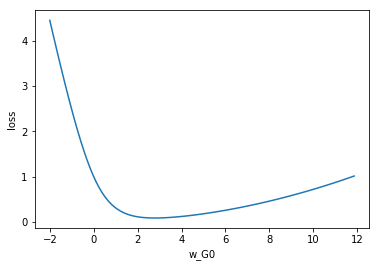

In [9]:
a = LogisticRegressionGradientDescent(alpha=0.1, step_size=0.01, init_w_recipe='zeros')
w_G0 = np.arange(-2,12,0.14)
W_G1 = np.zeros(100)
W_G = np.column_stack((w_G0,W_G1))
loss = []
grad = []
for i in range(100):
    loss.append(a.calc_loss(W_G[i], xbias_NG, y_N))
    grad.append(a.calc_grad(W_G[i], xbias_NG, y_N)[0])
#a.calc_grad( w_G, xbias_NG, y_N)

plt.plot(w_G0, loss)
plt.xlabel('w_G0');
plt.ylabel('loss');



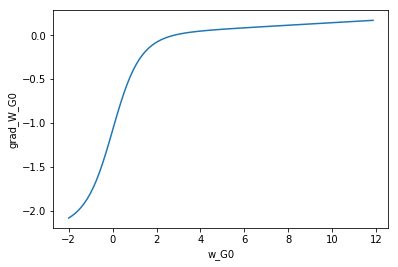

In [10]:
plt.plot(w_G0, grad)
plt.xlabel('w_G0');
plt.ylabel('grad_W_G0');


# 1b

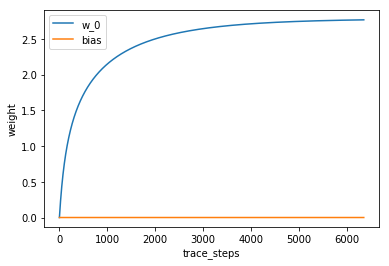

In [21]:
w1 = [a.trace_w[i][0] for i in range(a.trace_steps[-1])]
w2 = [a.trace_w[i][-1] for i in range(a.trace_steps[-1])]
plt.plot(w1, label='w_0')
plt.plot(w2,label='bias')
plt.ylabel('weight')
plt.xlabel('trace_steps')
plt.legend(loc='best')

# 1c

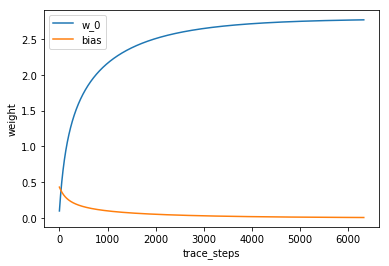

In [19]:
w1 = [a2.trace_w[i][0] for i in range(a2.trace_steps[-1])]
w2 = [a2.trace_w[i][-1] for i in range(a2.trace_steps[-1])]
plt.plot(w1, label='w_0')
plt.plot(w2,label='bias')
plt.ylabel('weight')
plt.xlabel('trace_steps')    
plt.legend(loc='best')

# Problem2

# 2a

In [1060]:
x_tr = np.loadtxt('data_digits_8_vs_9_noisy/x_train.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('data_digits_8_vs_9_noisy/y_train.csv', delimiter=',', skiprows=1)

In [1061]:
x_va = x_tr[0:2000]
y_va = y_tr[0:2000]
x_tra = x_tr[2000:11800]
y_tra = y_tr[2000:11800]

In [1065]:
w154_1 = [lr_2a1.trace_w[i][153] for i in range(lr_2a1.trace_steps[-1])]
wb_1 = [lr_2a1.trace_w[i][-1] for i in range(lr_2a1.trace_steps[-1])]
w154_2 = [lr_2a2.trace_w[i][153] for i in range(lr_2a2.trace_steps[-1])]
wb_2 = [lr_2a2.trace_w[i][-1] for i in range(lr_2a2.trace_steps[-1])]
w154_3 = [lr_2a3.trace_w[i][153] for i in range(lr_2a3.trace_steps[-1])]
wb_3 = [lr_2a3.trace_w[i][-1] for i in range(lr_2a3.trace_steps[-1])]


In [1064]:
lr_2a2 = LogisticRegressionGradientDescent(alpha=10, step_size=0.5, init_w_recipe='zeros')
lr_2a2.fit(x_tra, y_tra)

Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.5
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.024676  w[0]    0.000 bias    0.000
iter    1/30000  loss         0.652834  avg_L1_norm_grad         0.058458  w[0]   -0.001 bias    0.002
iter    2/30000  loss         4.480393  avg_L1_norm_grad         0.167414  w[0]    0.012 bias    0.145
iter    3/30000  loss         9.642480  avg_L1_norm_grad         0.151994  w[0]   -0.025 bias   -0.212
iter    4/30000  loss         1.741418  avg_L1_norm_grad         0.129421  w[0]    0.010 bias    0.151
iter    5/30000  loss         6.221672  avg_L1_norm_grad         0.151786  w[0]   -0.018 bias   -0.121
iter    6/30000  loss         2.955412  avg_L1_norm_grad         0.146658  w[0]    0.016 bias    0.241
iter    7/30000  loss         4.446966  avg_L1_norm_grad         0.147311  w[0]   -0.016 bias   -0.069
iter    8/30000  loss         2.279642  avg_L1_norm_grad

iter  620/30000  loss         0.102675  avg_L1_norm_grad         0.000109  w[0]   -0.058 bias    0.760
iter  621/30000  loss         0.102667  avg_L1_norm_grad         0.000109  w[0]   -0.058 bias    0.761
iter  640/30000  loss         0.102527  avg_L1_norm_grad         0.000105  w[0]   -0.058 bias    0.770
iter  641/30000  loss         0.102520  avg_L1_norm_grad         0.000105  w[0]   -0.058 bias    0.770
iter  660/30000  loss         0.102389  avg_L1_norm_grad         0.000101  w[0]   -0.058 bias    0.779
iter  661/30000  loss         0.102383  avg_L1_norm_grad         0.000101  w[0]   -0.058 bias    0.779
iter  680/30000  loss         0.102262  avg_L1_norm_grad         0.000097  w[0]   -0.057 bias    0.787
iter  681/30000  loss         0.102256  avg_L1_norm_grad         0.000097  w[0]   -0.057 bias    0.788
iter  700/30000  loss         0.102143  avg_L1_norm_grad         0.000094  w[0]   -0.057 bias    0.796
iter  701/30000  loss         0.102138  avg_L1_norm_grad         0.000094

iter 1420/30000  loss         0.100596  avg_L1_norm_grad         0.000029  w[0]   -0.051 bias    1.000
iter 1421/30000  loss         0.100596  avg_L1_norm_grad         0.000029  w[0]   -0.051 bias    1.000
iter 1440/30000  loss         0.100585  avg_L1_norm_grad         0.000028  w[0]   -0.051 bias    1.004
iter 1441/30000  loss         0.100585  avg_L1_norm_grad         0.000028  w[0]   -0.051 bias    1.004
iter 1460/30000  loss         0.100574  avg_L1_norm_grad         0.000027  w[0]   -0.051 bias    1.008
iter 1461/30000  loss         0.100574  avg_L1_norm_grad         0.000027  w[0]   -0.051 bias    1.008
iter 1480/30000  loss         0.100564  avg_L1_norm_grad         0.000027  w[0]   -0.051 bias    1.011
iter 1481/30000  loss         0.100564  avg_L1_norm_grad         0.000027  w[0]   -0.051 bias    1.011
iter 1500/30000  loss         0.100555  avg_L1_norm_grad         0.000026  w[0]   -0.051 bias    1.014
iter 1501/30000  loss         0.100554  avg_L1_norm_grad         0.000026

iter 2220/30000  loss         0.100407  avg_L1_norm_grad         0.000010  w[0]   -0.049 bias    1.102
iter 2221/30000  loss         0.100407  avg_L1_norm_grad         0.000010  w[0]   -0.049 bias    1.102
iter 2240/30000  loss         0.100406  avg_L1_norm_grad         0.000009  w[0]   -0.049 bias    1.103
iter 2241/30000  loss         0.100405  avg_L1_norm_grad         0.000009  w[0]   -0.049 bias    1.103
iter 2260/30000  loss         0.100404  avg_L1_norm_grad         0.000009  w[0]   -0.049 bias    1.105
iter 2261/30000  loss         0.100404  avg_L1_norm_grad         0.000009  w[0]   -0.049 bias    1.105
iter 2280/30000  loss         0.100403  avg_L1_norm_grad         0.000009  w[0]   -0.050 bias    1.106
iter 2281/30000  loss         0.100403  avg_L1_norm_grad         0.000009  w[0]   -0.050 bias    1.106
iter 2300/30000  loss         0.100402  avg_L1_norm_grad         0.000009  w[0]   -0.050 bias    1.108
iter 2301/30000  loss         0.100402  avg_L1_norm_grad         0.000009

iter 3020/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.148
iter 3021/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.148
iter 3040/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.149
iter 3041/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.149
iter 3060/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.150
iter 3061/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.150
iter 3080/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.150
iter 3081/30000  loss         0.100382  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.150
iter 3100/30000  loss         0.100381  avg_L1_norm_grad         0.000003  w[0]   -0.050 bias    1.151
iter 3101/30000  loss         0.100381  avg_L1_norm_grad         0.000003

iter 3820/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.170
iter 3821/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.170
iter 3840/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3841/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3860/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3861/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3880/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3881/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.171
iter 3900/30000  loss         0.100378  avg_L1_norm_grad         0.000001  w[0]   -0.050 bias    1.172
iter 3901/30000  loss         0.100378  avg_L1_norm_grad         0.000001

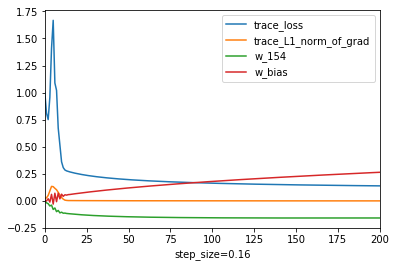

In [1037]:
plt.plot(lr_2a1.trace_loss, label='trace_loss')
plt.plot(lr_2a1.trace_L1_norm_of_grad, label='trace_L1_norm_of_grad')
plt.plot(w154_1, label='w_154')
plt.plot(wb_1, label='w_bias')

plt.xlim([0, 200]);

plt.ylabel('')
plt.xlabel('step_size=0.16')
plt.legend(loc='best')

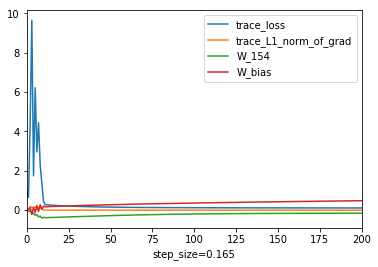

In [1066]:
plt.plot(lr_2a2.trace_loss, label='trace_loss')
plt.plot(lr_2a2.trace_L1_norm_of_grad, label='trace_L1_norm_of_grad')
plt.plot(w154_2, label='W_154')
plt.plot(wb_2, label='W_bias')

plt.xlim([0, 200]);


plt.ylabel('')
plt.xlabel('step_size=0.165')
plt.legend(loc='best')

Text(0.5, 0, 'loss')

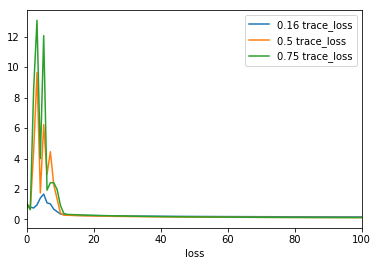

In [1084]:
plt.plot(lr_2a1.trace_loss, label='0.16 trace_loss')
plt.plot(lr_2a2.trace_loss, label='0.5 trace_loss')
plt.plot(lr_2a3.trace_loss, label='0.75 trace_loss')
plt.xlim([0, 100]);
plt.legend(loc='best')
plt.xlabel('loss')


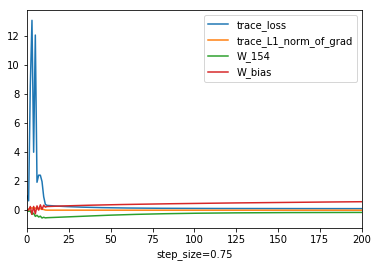

In [637]:
plt.plot(lr_2a3.trace_loss, label='trace_loss')
plt.plot(lr_2a3.trace_L1_norm_of_grad, label='trace_L1_norm_of_grad')
plt.plot(w154_3, label='W_154')
plt.plot(wb_3, label='W_bias')
plt.xlim([0, 200]);

plt.ylabel('')
plt.xlabel('step_size=0.75')
plt.legend(loc='best')

# 2b

Text(0.5, 0, 'error rate')

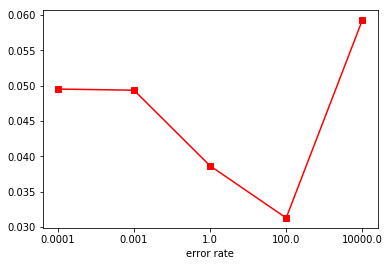

In [1054]:
er1 = np.array([0.0524, 0.0478, 0.0483])
er2 = np.array([0.0524, 0.0475, 0.0481])
er3 = np.array([0.0386, 0.0389, 0.0384])
er4 = np.array([0.0333, 0.0290, 0.0315])
er5 = np.array([0.0666, 0.0592, 0.0519])
er = np.array([np.mean(er1), np.mean(er2), np.mean(er3), np.mean(er4), np.mean(er5)])
alpah = np.array([0.0001, 0.001, 1, 100, 10000])

plt.plot(er, '-rs')
plt.xticks(range(5), alpah)
plt.xlabel('error rate')




# 2c

In [640]:
x_va = x_tr[0:3934]
y_va = y_tr[0:3934]
x_tra = x_tr[3934:11800]
y_tra = y_tr[3934:11800]

In [643]:
y_hat = lr2c.predict(x_va)
TP = 0
TN = 0
FP = 0
FN = 0
FP_list = list()
FN_list = list()


for i in range(len(y_hat)):
    if y_hat[i] == y_va[i]  == 1:
        TP = TP + 1
    elif y_hat[i] == y_va[i]  == 0:
        TN = TN + 1
    elif (y_hat[i] == 1) & (y_va[i]  == 0):
        FP = FP + 1
        FP_list.append(i)
    else:
        FN = FN + 1
        FN_list.append(i)
     
    
TP = TP/len(y_hat)
TN = TN/len(y_hat)
FP = FP/len(y_hat)
FN = FN/len(y_hat)
    

In [644]:
y_actu = pd.Series(y_va, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0.0,1860,62
1.0,69,1943


In [484]:
x_test_NF = np.loadtxt('data_digits_8_vs_9_noisy/x_test.csv', delimiter=',', skiprows=1)

yproba1_test_N = lr.predict_proba(x_test_NF)[:, 1]

np.savetxt('yproba3_test.txt', yproba1_test_N)

In [16]:
def show_images(X, y):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
    for ii in range(9):
        cur_ax = axes.flatten()[ii]
        cur_ax.imshow(X[ii].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')
        cur_ax.set_xticks([])
        cur_ax.set_yticks([])
        cur_ax.set_title('y=%d' % y[ii])



In [30]:
x_FP = [x_va[i] for i in FP_list]
y_FP = [y_va[i] for i in FP_list]
x_FP = x_FP[25:46]

x_FN = [x_va[i] for i in FN_list]
y_FN = [y_va[i] for i in FN_list]

x_FN = x_FN[23:43]


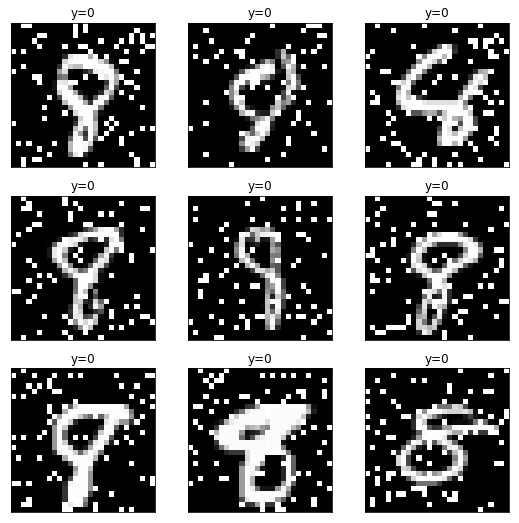

In [29]:
show_images(x_FP, y_FP)

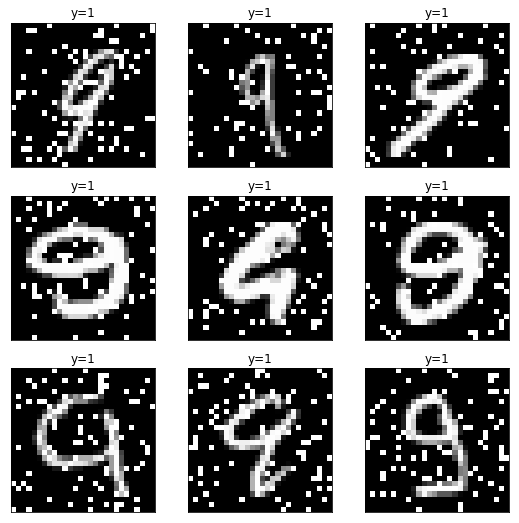

In [31]:
show_images(x_FN, y_FN)

We can see that, for the false positive, most of their's lower circle is not very obvious.
The lower circle is some kind like a straight line.

And for the false negative, most of their's lower straight line is not straight, which is bending, looks like a circle. 

# 2d

Text(0.5, 1.0, 'alpha is best')

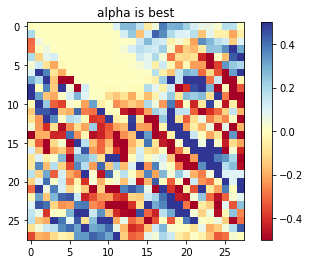

In [1055]:
import matplotlib.pyplot as plt
plt.imshow(lr.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()
plt.title('alpha is best')

It seems the pixels associated with a digit '8' gathers on the pixels which is difference parts of '8' and '9', and the pixels associated with a digit '9' gathers on the parts same partes of '8' and '9'.

The lower and upper left arc pixels are associated with a digit '8'.

The middle arc pixels are associated with a digit '8'.

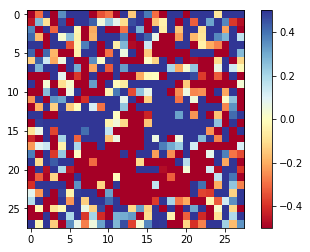

In [1043]:
import matplotlib.pyplot as plt
plt.imshow(lr_2d1.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()

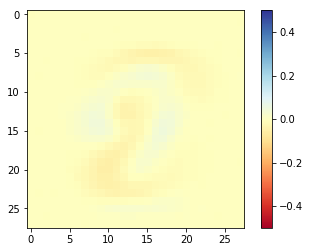

In [1042]:
import matplotlib.pyplot as plt


plt.imshow(lr_2d2.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()

# 2e

The error rate is 0.033787191124558746
The mean error rate of the 3-fold validation 0.031
They are match

# Problem 3

In [1021]:
x_tr = np.loadtxt('data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)


When I checked the data set, I noticed most of the picture are like this:

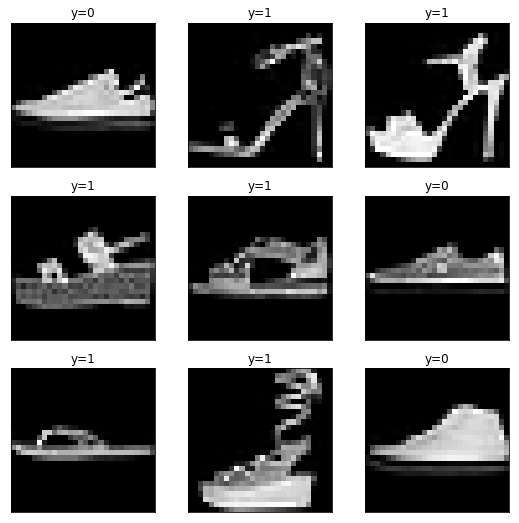

In [1051]:
show_images(x_tr, y_tr)

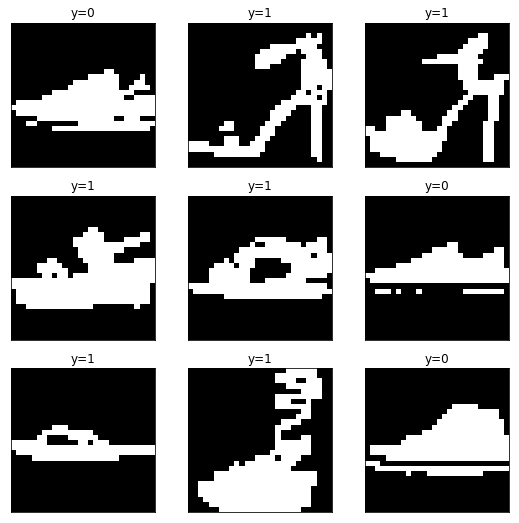

In [1052]:
show_images(x_trbw, y_tr)

In [1022]:
x_trbw = x_tr.copy()
x_tebw = x_te.copy()
for i in range(12000):
    x_trbw[i] = np.where(x_tr[i] < 0.1, x_trbw[i], 1)
    x_trbw[i] = np.where(x_tr[i] > 0.1, x_trbw[i], 0)

for i in range(2000):
    x_tebw[i] = np.where(x_te[i] < 0.1, x_tebw[i], 1)
    x_tebw[i] = np.where(x_te[i] > 0.1, x_tebw[i], 0)

In [920]:
lr_p3_bw = LogisticRegressionGradientDescent(alpha=1, step_size=0.1, init_w_recipe='zeros')
lr_p3_bw.fit(x_trbw, y_tr)


Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.048868  w[0]    0.000 bias    0.000
iter    1/30000  loss         1.004322  avg_L1_norm_grad         0.095532  w[0]    0.000 bias    0.000
iter    2/30000  loss         1.976237  avg_L1_norm_grad         0.179454  w[0]    0.000 bias    0.040
iter    3/30000  loss         3.361643  avg_L1_norm_grad         0.175121  w[0]    0.000 bias   -0.019
iter    4/30000  loss         0.881007  avg_L1_norm_grad         0.082850  w[0]    0.000 bias    0.050
iter    5/30000  loss         1.359259  avg_L1_norm_grad         0.114673  w[0]    0.000 bias    0.028
iter    6/30000  loss         1.440445  avg_L1_norm_grad         0.153459  w[0]    0.000 bias    0.077
iter    7/30000  loss         2.370728  avg_L1_norm_grad         0.147700  w[0]    0.000 bias    0.028
iter    8/30000  loss         0.843519  avg_L1_norm_grad

iter  620/30000  loss         0.171404  avg_L1_norm_grad         0.000510  w[0]    0.000 bias    1.261
iter  621/30000  loss         0.171346  avg_L1_norm_grad         0.000510  w[0]    0.000 bias    1.262
iter  640/30000  loss         0.170256  avg_L1_norm_grad         0.000500  w[0]    0.000 bias    1.284
iter  641/30000  loss         0.170200  avg_L1_norm_grad         0.000499  w[0]    0.000 bias    1.285
iter  660/30000  loss         0.169154  avg_L1_norm_grad         0.000489  w[0]    0.000 bias    1.308
iter  661/30000  loss         0.169100  avg_L1_norm_grad         0.000489  w[0]    0.000 bias    1.309
iter  680/30000  loss         0.168094  avg_L1_norm_grad         0.000480  w[0]    0.000 bias    1.331
iter  681/30000  loss         0.168042  avg_L1_norm_grad         0.000479  w[0]    0.000 bias    1.332
iter  700/30000  loss         0.167075  avg_L1_norm_grad         0.000470  w[0]    0.000 bias    1.353
iter  701/30000  loss         0.167025  avg_L1_norm_grad         0.000470

iter 1420/30000  loss         0.144952  avg_L1_norm_grad         0.000291  w[0]    0.000 bias    2.038
iter 1421/30000  loss         0.144932  avg_L1_norm_grad         0.000291  w[0]    0.000 bias    2.039
iter 1440/30000  loss         0.144563  avg_L1_norm_grad         0.000288  w[0]    0.000 bias    2.055
iter 1441/30000  loss         0.144544  avg_L1_norm_grad         0.000288  w[0]    0.000 bias    2.055
iter 1460/30000  loss         0.144182  avg_L1_norm_grad         0.000285  w[0]    0.000 bias    2.071
iter 1461/30000  loss         0.144163  avg_L1_norm_grad         0.000285  w[0]    0.000 bias    2.072
iter 1480/30000  loss         0.143808  avg_L1_norm_grad         0.000283  w[0]    0.000 bias    2.087
iter 1481/30000  loss         0.143789  avg_L1_norm_grad         0.000282  w[0]    0.000 bias    2.088
iter 1500/30000  loss         0.143440  avg_L1_norm_grad         0.000280  w[0]    0.000 bias    2.103
iter 1501/30000  loss         0.143422  avg_L1_norm_grad         0.000280

iter 2220/30000  loss         0.133347  avg_L1_norm_grad         0.000214  w[0]    0.000 bias    2.627
iter 2221/30000  loss         0.133336  avg_L1_norm_grad         0.000214  w[0]    0.000 bias    2.628
iter 2240/30000  loss         0.133130  avg_L1_norm_grad         0.000213  w[0]    0.000 bias    2.640
iter 2241/30000  loss         0.133119  avg_L1_norm_grad         0.000213  w[0]    0.000 bias    2.641
iter 2260/30000  loss         0.132915  avg_L1_norm_grad         0.000211  w[0]    0.000 bias    2.653
iter 2261/30000  loss         0.132904  avg_L1_norm_grad         0.000211  w[0]    0.000 bias    2.654
iter 2280/30000  loss         0.132703  avg_L1_norm_grad         0.000210  w[0]    0.000 bias    2.667
iter 2281/30000  loss         0.132692  avg_L1_norm_grad         0.000210  w[0]    0.000 bias    2.667
iter 2300/30000  loss         0.132493  avg_L1_norm_grad         0.000209  w[0]    0.000 bias    2.680
iter 2301/30000  loss         0.132482  avg_L1_norm_grad         0.000209

iter 3020/30000  loss         0.126208  avg_L1_norm_grad         0.000174  w[0]    0.000 bias    3.117
iter 3021/30000  loss         0.126201  avg_L1_norm_grad         0.000174  w[0]    0.000 bias    3.117
iter 3040/30000  loss         0.126062  avg_L1_norm_grad         0.000173  w[0]    0.000 bias    3.128
iter 3041/30000  loss         0.126054  avg_L1_norm_grad         0.000173  w[0]    0.000 bias    3.128
iter 3060/30000  loss         0.125917  avg_L1_norm_grad         0.000172  w[0]    0.000 bias    3.139
iter 3061/30000  loss         0.125909  avg_L1_norm_grad         0.000172  w[0]    0.000 bias    3.140
iter 3080/30000  loss         0.125773  avg_L1_norm_grad         0.000172  w[0]    0.000 bias    3.150
iter 3081/30000  loss         0.125766  avg_L1_norm_grad         0.000172  w[0]    0.000 bias    3.151
iter 3100/30000  loss         0.125630  avg_L1_norm_grad         0.000171  w[0]    0.000 bias    3.162
iter 3101/30000  loss         0.125623  avg_L1_norm_grad         0.000171

iter 3820/30000  loss         0.121169  avg_L1_norm_grad         0.000148  w[0]    0.000 bias    3.540
iter 3821/30000  loss         0.121164  avg_L1_norm_grad         0.000148  w[0]    0.000 bias    3.541
iter 3840/30000  loss         0.121061  avg_L1_norm_grad         0.000148  w[0]    0.000 bias    3.550
iter 3841/30000  loss         0.121056  avg_L1_norm_grad         0.000148  w[0]    0.000 bias    3.551
iter 3860/30000  loss         0.120954  avg_L1_norm_grad         0.000147  w[0]    0.000 bias    3.560
iter 3861/30000  loss         0.120949  avg_L1_norm_grad         0.000147  w[0]    0.000 bias    3.561
iter 3880/30000  loss         0.120848  avg_L1_norm_grad         0.000147  w[0]    0.000 bias    3.570
iter 3881/30000  loss         0.120842  avg_L1_norm_grad         0.000146  w[0]    0.000 bias    3.571
iter 3900/30000  loss         0.120742  avg_L1_norm_grad         0.000146  w[0]    0.000 bias    3.580
iter 3901/30000  loss         0.120736  avg_L1_norm_grad         0.000146

iter 4620/30000  loss         0.117347  avg_L1_norm_grad         0.000130  w[0]    0.000 bias    3.916
iter 4621/30000  loss         0.117343  avg_L1_norm_grad         0.000129  w[0]    0.000 bias    3.916
iter 4640/30000  loss         0.117263  avg_L1_norm_grad         0.000129  w[0]    0.000 bias    3.925
iter 4641/30000  loss         0.117259  avg_L1_norm_grad         0.000129  w[0]    0.000 bias    3.925
iter 4660/30000  loss         0.117180  avg_L1_norm_grad         0.000129  w[0]    0.000 bias    3.933
iter 4661/30000  loss         0.117175  avg_L1_norm_grad         0.000129  w[0]    0.000 bias    3.934
iter 4680/30000  loss         0.117096  avg_L1_norm_grad         0.000128  w[0]    0.000 bias    3.942
iter 4681/30000  loss         0.117092  avg_L1_norm_grad         0.000128  w[0]    0.000 bias    3.943
iter 4700/30000  loss         0.117014  avg_L1_norm_grad         0.000128  w[0]    0.000 bias    3.951
iter 4701/30000  loss         0.117010  avg_L1_norm_grad         0.000128

iter 5420/30000  loss         0.114319  avg_L1_norm_grad         0.000116  w[0]    0.000 bias    4.253
iter 5421/30000  loss         0.114316  avg_L1_norm_grad         0.000116  w[0]    0.000 bias    4.253
iter 5440/30000  loss         0.114251  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.261
iter 5441/30000  loss         0.114248  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.261
iter 5460/30000  loss         0.114184  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.269
iter 5461/30000  loss         0.114181  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.269
iter 5480/30000  loss         0.114117  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.277
iter 5481/30000  loss         0.114114  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.277
iter 5500/30000  loss         0.114050  avg_L1_norm_grad         0.000115  w[0]    0.000 bias    4.285
iter 5501/30000  loss         0.114047  avg_L1_norm_grad         0.000115

iter 6220/30000  loss         0.111850  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    4.559
iter 6221/30000  loss         0.111847  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    4.559
iter 6240/30000  loss         0.111794  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    4.566
iter 6241/30000  loss         0.111791  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    4.567
iter 6260/30000  loss         0.111738  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    4.574
iter 6261/30000  loss         0.111736  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    4.574
iter 6280/30000  loss         0.111683  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    4.581
iter 6281/30000  loss         0.111680  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    4.581
iter 6300/30000  loss         0.111628  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    4.588
iter 6301/30000  loss         0.111625  avg_L1_norm_grad         0.000104

iter 7020/30000  loss         0.109795  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.839
iter 7021/30000  loss         0.109793  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.839
iter 7040/30000  loss         0.109749  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.846
iter 7041/30000  loss         0.109746  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.846
iter 7060/30000  loss         0.109702  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.852
iter 7061/30000  loss         0.109699  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.853
iter 7080/30000  loss         0.109655  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.859
iter 7081/30000  loss         0.109653  avg_L1_norm_grad         0.000096  w[0]    0.000 bias    4.859
iter 7100/30000  loss         0.109609  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    4.866
iter 7101/30000  loss         0.109607  avg_L1_norm_grad         0.000095

iter 7820/30000  loss         0.108060  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    5.096
iter 7821/30000  loss         0.108058  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    5.097
iter 7840/30000  loss         0.108020  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    5.103
iter 7841/30000  loss         0.108018  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    5.103
iter 7860/30000  loss         0.107980  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    5.109
iter 7861/30000  loss         0.107978  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    5.109
iter 7880/30000  loss         0.107941  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    5.115
iter 7881/30000  loss         0.107939  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    5.115
iter 7900/30000  loss         0.107901  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    5.121
iter 7901/30000  loss         0.107899  avg_L1_norm_grad         0.000088

iter 8620/30000  loss         0.106576  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.334
iter 8621/30000  loss         0.106575  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.335
iter 8640/30000  loss         0.106542  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.340
iter 8641/30000  loss         0.106540  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.341
iter 8660/30000  loss         0.106508  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.346
iter 8661/30000  loss         0.106506  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.346
iter 8680/30000  loss         0.106474  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.352
iter 8681/30000  loss         0.106472  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.352
iter 8700/30000  loss         0.106440  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    5.357
iter 8701/30000  loss         0.106438  avg_L1_norm_grad         0.000082

iter 9420/30000  loss         0.105296  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.555
iter 9421/30000  loss         0.105295  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.556
iter 9440/30000  loss         0.105266  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.561
iter 9441/30000  loss         0.105265  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.561
iter 9460/30000  loss         0.105237  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.566
iter 9461/30000  loss         0.105235  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.566
iter 9480/30000  loss         0.105207  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.571
iter 9481/30000  loss         0.105206  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.572
iter 9500/30000  loss         0.105178  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    5.577
iter 9501/30000  loss         0.105176  avg_L1_norm_grad         0.000076

iter 10220/30000  loss         0.104182  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.761
iter 10221/30000  loss         0.104180  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.761
iter 10240/30000  loss         0.104156  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.766
iter 10241/30000  loss         0.104154  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.766
iter 10260/30000  loss         0.104130  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.771
iter 10261/30000  loss         0.104128  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.771
iter 10280/30000  loss         0.104104  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.776
iter 10281/30000  loss         0.104102  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.776
iter 10300/30000  loss         0.104078  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.781
iter 10301/30000  loss         0.104077  avg_L1_norm_grad       

iter 11020/30000  loss         0.103204  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.953
iter 11021/30000  loss         0.103203  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.953
iter 11040/30000  loss         0.103182  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.957
iter 11041/30000  loss         0.103180  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.958
iter 11060/30000  loss         0.103159  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.962
iter 11061/30000  loss         0.103158  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.962
iter 11080/30000  loss         0.103136  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.967
iter 11081/30000  loss         0.103135  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.967
iter 11100/30000  loss         0.103113  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.971
iter 11101/30000  loss         0.103112  avg_L1_norm_grad       

iter 11820/30000  loss         0.102342  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.132
iter 11821/30000  loss         0.102341  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.133
iter 11840/30000  loss         0.102322  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.137
iter 11841/30000  loss         0.102321  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.137
iter 11860/30000  loss         0.102302  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.141
iter 11861/30000  loss         0.102301  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.141
iter 11880/30000  loss         0.102282  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.145
iter 11881/30000  loss         0.102281  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.145
iter 11900/30000  loss         0.102262  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    6.150
iter 11901/30000  loss         0.102261  avg_L1_norm_grad       

iter 12620/30000  loss         0.101577  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.301
iter 12621/30000  loss         0.101576  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.301
iter 12640/30000  loss         0.101559  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.305
iter 12641/30000  loss         0.101558  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.305
iter 12660/30000  loss         0.101541  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.309
iter 12661/30000  loss         0.101540  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.309
iter 12680/30000  loss         0.101523  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.313
iter 12681/30000  loss         0.101522  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.313
iter 12700/30000  loss         0.101505  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.317
iter 12701/30000  loss         0.101505  avg_L1_norm_grad       

iter 13420/30000  loss         0.100895  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.459
iter 13421/30000  loss         0.100894  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.459
iter 13440/30000  loss         0.100879  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.463
iter 13441/30000  loss         0.100878  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.463
iter 13460/30000  loss         0.100863  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.466
iter 13461/30000  loss         0.100862  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.467
iter 13480/30000  loss         0.100847  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.470
iter 13481/30000  loss         0.100846  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.470
iter 13500/30000  loss         0.100831  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.474
iter 13501/30000  loss         0.100830  avg_L1_norm_grad       

iter 14220/30000  loss         0.100283  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.608
iter 14221/30000  loss         0.100282  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.608
iter 14240/30000  loss         0.100269  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.611
iter 14241/30000  loss         0.100268  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.611
iter 14260/30000  loss         0.100254  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.615
iter 14261/30000  loss         0.100254  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.615
iter 14280/30000  loss         0.100240  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.618
iter 14281/30000  loss         0.100239  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.619
iter 14300/30000  loss         0.100226  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.622
iter 14301/30000  loss         0.100225  avg_L1_norm_grad       

iter 15020/30000  loss         0.099733  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.748
iter 15021/30000  loss         0.099732  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.748
iter 15040/30000  loss         0.099720  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.751
iter 15041/30000  loss         0.099719  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.751
iter 15060/30000  loss         0.099707  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.755
iter 15061/30000  loss         0.099706  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.755
iter 15080/30000  loss         0.099694  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.758
iter 15081/30000  loss         0.099693  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.758
iter 15100/30000  loss         0.099681  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.761
iter 15101/30000  loss         0.099680  avg_L1_norm_grad       

iter 15820/30000  loss         0.099236  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    6.880
iter 15821/30000  loss         0.099235  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    6.880
iter 15840/30000  loss         0.099224  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.884
iter 15841/30000  loss         0.099223  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.884
iter 15860/30000  loss         0.099212  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.887
iter 15861/30000  loss         0.099212  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.887
iter 15880/30000  loss         0.099200  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.890
iter 15881/30000  loss         0.099200  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.890
iter 15900/30000  loss         0.099189  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.893
iter 15901/30000  loss         0.099188  avg_L1_norm_grad       

iter 16620/30000  loss         0.098785  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.005
iter 16621/30000  loss         0.098785  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.006
iter 16640/30000  loss         0.098774  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.009
iter 16641/30000  loss         0.098774  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.009
iter 16660/30000  loss         0.098764  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.012
iter 16661/30000  loss         0.098763  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.012
iter 16680/30000  loss         0.098753  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.015
iter 16681/30000  loss         0.098753  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.015
iter 16700/30000  loss         0.098742  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    7.018
iter 16701/30000  loss         0.098742  avg_L1_norm_grad       

iter 17420/30000  loss         0.098375  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.124
iter 17421/30000  loss         0.098375  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.124
iter 17440/30000  loss         0.098366  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.127
iter 17441/30000  loss         0.098365  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.127
iter 17460/30000  loss         0.098356  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.130
iter 17461/30000  loss         0.098355  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.130
iter 17480/30000  loss         0.098346  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.133
iter 17481/30000  loss         0.098346  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.133
iter 17500/30000  loss         0.098336  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.135
iter 17501/30000  loss         0.098336  avg_L1_norm_grad       

iter 18220/30000  loss         0.098002  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.236
iter 18221/30000  loss         0.098001  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.236
iter 18240/30000  loss         0.097993  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.239
iter 18241/30000  loss         0.097992  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.239
iter 18260/30000  loss         0.097984  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.242
iter 18261/30000  loss         0.097983  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.242
iter 18280/30000  loss         0.097975  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.244
iter 18281/30000  loss         0.097974  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.245
iter 18300/30000  loss         0.097966  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.247
iter 18301/30000  loss         0.097966  avg_L1_norm_grad       

iter 19020/30000  loss         0.097660  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.343
iter 19021/30000  loss         0.097659  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.343
iter 19040/30000  loss         0.097651  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.345
iter 19041/30000  loss         0.097651  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.345
iter 19060/30000  loss         0.097643  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.348
iter 19061/30000  loss         0.097643  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.348
iter 19080/30000  loss         0.097635  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.350
iter 19081/30000  loss         0.097635  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.351
iter 19100/30000  loss         0.097627  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    7.353
iter 19101/30000  loss         0.097627  avg_L1_norm_grad       

iter 19820/30000  loss         0.097346  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.444
iter 19821/30000  loss         0.097346  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.444
iter 19840/30000  loss         0.097339  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.446
iter 19841/30000  loss         0.097338  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.446
iter 19860/30000  loss         0.097331  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.449
iter 19861/30000  loss         0.097331  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.449
iter 19880/30000  loss         0.097324  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.451
iter 19881/30000  loss         0.097323  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.451
iter 19900/30000  loss         0.097316  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.454
iter 19901/30000  loss         0.097316  avg_L1_norm_grad       

iter 20620/30000  loss         0.097058  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.540
iter 20621/30000  loss         0.097058  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.540
iter 20640/30000  loss         0.097051  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.542
iter 20641/30000  loss         0.097051  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.542
iter 20660/30000  loss         0.097044  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.545
iter 20661/30000  loss         0.097044  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.545
iter 20680/30000  loss         0.097037  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.547
iter 20681/30000  loss         0.097037  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.547
iter 20700/30000  loss         0.097030  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.549
iter 20701/30000  loss         0.097030  avg_L1_norm_grad       

iter 21420/30000  loss         0.096792  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.631
iter 21421/30000  loss         0.096792  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.631
iter 21440/30000  loss         0.096786  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.634
iter 21441/30000  loss         0.096786  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.634
iter 21460/30000  loss         0.096780  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.636
iter 21461/30000  loss         0.096779  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.636
iter 21480/30000  loss         0.096773  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.638
iter 21481/30000  loss         0.096773  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.638
iter 21500/30000  loss         0.096767  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.640
iter 21501/30000  loss         0.096767  avg_L1_norm_grad       

iter 22220/30000  loss         0.096547  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.718
iter 22221/30000  loss         0.096547  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.718
iter 22240/30000  loss         0.096542  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.720
iter 22241/30000  loss         0.096541  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.720
iter 22260/30000  loss         0.096536  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.723
iter 22261/30000  loss         0.096535  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.723
iter 22280/30000  loss         0.096530  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.725
iter 22281/30000  loss         0.096530  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.725
iter 22300/30000  loss         0.096524  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    7.727
iter 22301/30000  loss         0.096524  avg_L1_norm_grad       

iter 23020/30000  loss         0.096321  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.801
iter 23021/30000  loss         0.096320  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.801
iter 23040/30000  loss         0.096315  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.803
iter 23041/30000  loss         0.096315  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.803
iter 23060/30000  loss         0.096310  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.805
iter 23061/30000  loss         0.096310  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.805
iter 23080/30000  loss         0.096304  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.807
iter 23081/30000  loss         0.096304  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.807
iter 23100/30000  loss         0.096299  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.809
iter 23101/30000  loss         0.096299  avg_L1_norm_grad       

iter 23820/30000  loss         0.096111  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.880
iter 23821/30000  loss         0.096110  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.880
iter 23840/30000  loss         0.096106  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.882
iter 23841/30000  loss         0.096105  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.882
iter 23860/30000  loss         0.096101  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.884
iter 23861/30000  loss         0.096100  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.884
iter 23880/30000  loss         0.096096  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.886
iter 23881/30000  loss         0.096095  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.886
iter 23900/30000  loss         0.096091  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.888
iter 23901/30000  loss         0.096090  avg_L1_norm_grad       

iter 24620/30000  loss         0.095916  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.955
iter 24621/30000  loss         0.095915  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.956
iter 24640/30000  loss         0.095911  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.957
iter 24641/30000  loss         0.095911  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.957
iter 24660/30000  loss         0.095906  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.959
iter 24661/30000  loss         0.095906  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.959
iter 24680/30000  loss         0.095902  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.961
iter 24681/30000  loss         0.095901  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.961
iter 24700/30000  loss         0.095897  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.963
iter 24701/30000  loss         0.095897  avg_L1_norm_grad       

iter 25420/30000  loss         0.095734  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.027
iter 25421/30000  loss         0.095734  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.028
iter 25440/30000  loss         0.095730  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.029
iter 25441/30000  loss         0.095730  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.029
iter 25460/30000  loss         0.095726  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.031
iter 25461/30000  loss         0.095725  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.031
iter 25480/30000  loss         0.095721  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.033
iter 25481/30000  loss         0.095721  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.033
iter 25500/30000  loss         0.095717  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.034
iter 25501/30000  loss         0.095717  avg_L1_norm_grad       

iter 26220/30000  loss         0.095565  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.096
iter 26221/30000  loss         0.095565  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.096
iter 26240/30000  loss         0.095561  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.098
iter 26241/30000  loss         0.095561  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.098
iter 26260/30000  loss         0.095557  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.099
iter 26261/30000  loss         0.095557  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.100
iter 26280/30000  loss         0.095553  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.101
iter 26281/30000  loss         0.095553  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.101
iter 26300/30000  loss         0.095549  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.103
iter 26301/30000  loss         0.095549  avg_L1_norm_grad       

iter 27020/30000  loss         0.095408  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.162
iter 27021/30000  loss         0.095408  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.162
iter 27040/30000  loss         0.095404  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.163
iter 27041/30000  loss         0.095404  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.163
iter 27060/30000  loss         0.095400  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.165
iter 27061/30000  loss         0.095400  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.165
iter 27080/30000  loss         0.095397  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.167
iter 27081/30000  loss         0.095396  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.167
iter 27100/30000  loss         0.095393  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.168
iter 27101/30000  loss         0.095393  avg_L1_norm_grad       

iter 27820/30000  loss         0.095261  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.225
iter 27821/30000  loss         0.095261  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.225
iter 27840/30000  loss         0.095257  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.226
iter 27841/30000  loss         0.095257  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.226
iter 27860/30000  loss         0.095254  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.228
iter 27861/30000  loss         0.095254  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.228
iter 27880/30000  loss         0.095250  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.229
iter 27881/30000  loss         0.095250  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.229
iter 27900/30000  loss         0.095247  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.231
iter 27901/30000  loss         0.095247  avg_L1_norm_grad       

iter 28620/30000  loss         0.095123  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.285
iter 28621/30000  loss         0.095123  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.285
iter 28640/30000  loss         0.095120  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.286
iter 28641/30000  loss         0.095120  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.286
iter 28660/30000  loss         0.095117  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.288
iter 28661/30000  loss         0.095116  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.288
iter 28680/30000  loss         0.095113  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.289
iter 28681/30000  loss         0.095113  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.289
iter 28700/30000  loss         0.095110  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.290
iter 28701/30000  loss         0.095110  avg_L1_norm_grad       

iter 29420/30000  loss         0.094994  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.342
iter 29421/30000  loss         0.094994  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.342
iter 29440/30000  loss         0.094991  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.343
iter 29441/30000  loss         0.094991  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.344
iter 29460/30000  loss         0.094988  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.345
iter 29461/30000  loss         0.094988  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.345
iter 29480/30000  loss         0.094985  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.346
iter 29481/30000  loss         0.094985  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.346
iter 29500/30000  loss         0.094982  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.348
iter 29501/30000  loss         0.094982  avg_L1_norm_grad       

In [1036]:
lr_p3_bw = LogisticRegressionGradientDescent(alpha=100, step_size=0.1, init_w_recipe='zeros')
lr_p3_bw.fit(x_tr, y_tr)

Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.031943  w[0]    0.000 bias    0.000
iter    1/30000  loss         0.905018  avg_L1_norm_grad         0.026338  w[0]    0.000 bias    0.000
iter    2/30000  loss         0.839647  avg_L1_norm_grad         0.018624  w[0]    0.000 bias    0.022
iter    3/30000  loss         0.796985  avg_L1_norm_grad         0.015870  w[0]    0.000 bias    0.028
iter    4/30000  loss         0.765567  avg_L1_norm_grad         0.012866  w[0]    0.000 bias    0.043
iter    5/30000  loss         0.741351  avg_L1_norm_grad         0.011733  w[0]    0.000 bias    0.053
iter    6/30000  loss         0.721433  avg_L1_norm_grad         0.010433  w[0]    0.000 bias    0.065
iter    7/30000  loss         0.704357  avg_L1_norm_grad         0.009763  w[0]    0.000 bias    0.075
iter    8/30000  loss         0.689274  avg_L1_norm_grad

iter  620/30000  loss         0.311856  avg_L1_norm_grad         0.000212  w[0]    0.000 bias    1.293
iter  621/30000  loss         0.311846  avg_L1_norm_grad         0.000212  w[0]    0.000 bias    1.294
iter  640/30000  loss         0.311667  avg_L1_norm_grad         0.000201  w[0]    0.000 bias    1.301
iter  641/30000  loss         0.311658  avg_L1_norm_grad         0.000201  w[0]    0.000 bias    1.301
iter  660/30000  loss         0.311499  avg_L1_norm_grad         0.000191  w[0]    0.000 bias    1.307
iter  661/30000  loss         0.311491  avg_L1_norm_grad         0.000190  w[0]    0.000 bias    1.308
iter  680/30000  loss         0.311347  avg_L1_norm_grad         0.000181  w[0]    0.000 bias    1.313
iter  681/30000  loss         0.311340  avg_L1_norm_grad         0.000181  w[0]    0.000 bias    1.314
iter  700/30000  loss         0.311211  avg_L1_norm_grad         0.000172  w[0]    0.000 bias    1.319
iter  701/30000  loss         0.311205  avg_L1_norm_grad         0.000172

iter 1420/30000  loss         0.309901  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    1.396
iter 1421/30000  loss         0.309900  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    1.396
iter 1440/30000  loss         0.309895  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    1.396
iter 1441/30000  loss         0.309895  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    1.396
iter 1460/30000  loss         0.309890  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    1.397
iter 1461/30000  loss         0.309889  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    1.397
iter 1480/30000  loss         0.309885  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    1.397
iter 1481/30000  loss         0.309885  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    1.397
iter 1500/30000  loss         0.309880  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    1.398
iter 1501/30000  loss         0.309880  avg_L1_norm_grad         0.000034

iter 2220/30000  loss         0.309822  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    1.403
iter 2221/30000  loss         0.309822  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    1.403
Done. Converged after 2223 iterations.


In [1023]:
y_hat = lr_p3_bw.predict(x_trbw)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0.0,5925,75
1.0,149,5851


In [1057]:
y_hat = lr_p3_bw.predict(x_tr)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0.0,5820,180
1.0,383,5617


In [1038]:
y_hat_p2 = lr_p3_bw.predict_proba(x_tr)

In [1039]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_tr, y_hat_p[:,1])
fpr2, tpr2, thresholds2 = sklearn.metrics.roc_curve(y_tr, y_hat_p2[:,1])

Text(0.5, 1.0, 'Threshold')

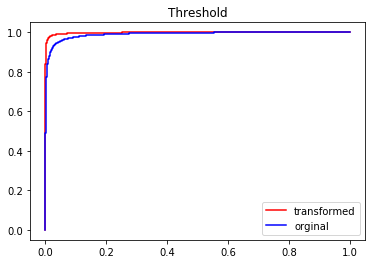

In [1085]:
plt.plot(fpr, tpr, '-r', label='transformed')
plt.plot(fpr2, tpr2, '-b', label='orginal')
plt.legend(loc='best')
plt.title('Threshold')

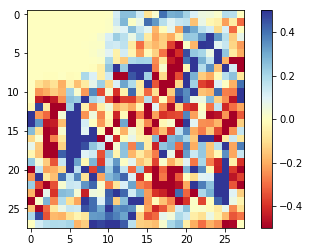

In [1025]:
import matplotlib.pyplot as plt


plt.imshow(lr_p3_bw.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()

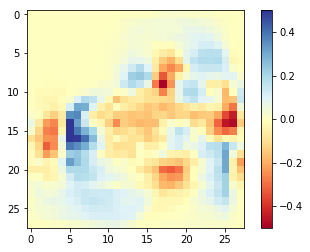

In [1048]:
import matplotlib.pyplot as plt


plt.imshow(lr_p3_bw.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()

In [1015]:
TP = 0
TN = 0
FP = 0
FN = 0
FP_list = list()
FN_list = list()

for i in range(len(y_hat)):
    if y_hat[i] == y_tr[i]  == 1:
        TP = TP + 1
    elif y_hat[i] == y_tr[i]  == 0:
        TN = TN + 1
    elif (y_hat[i] == 1) & (y_tr[i]  == 0):
        FP = FP + 1
        FP_list.append(i)
    else:
        FN = FN + 1
        FN_list.append(i)
        
x_FP = [x_trbw[i] for i in FP_list]
y_FP = [y_tr[i] for i in FP_list]
#x_FP = x_FP[25:46]

x_FN = [x_trbw[i] for i in FN_list]
y_FN = [y_tr[i] for i in FN_list]

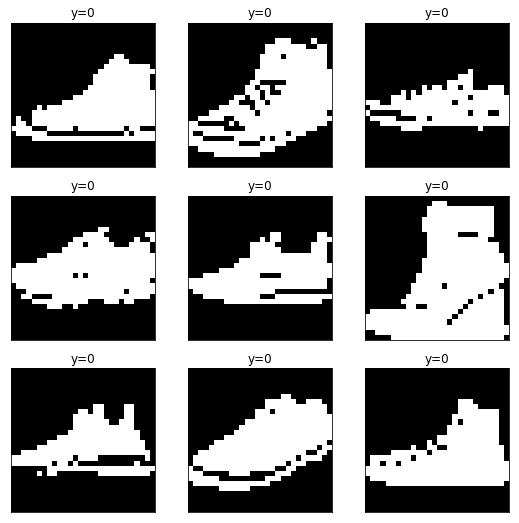

In [1016]:
show_images(x_FP, y_FP)

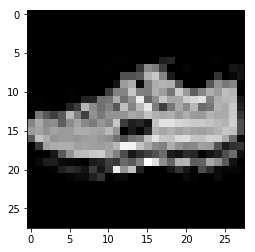

In [1017]:
plt.imshow(x_tr[FP_list[3]].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')

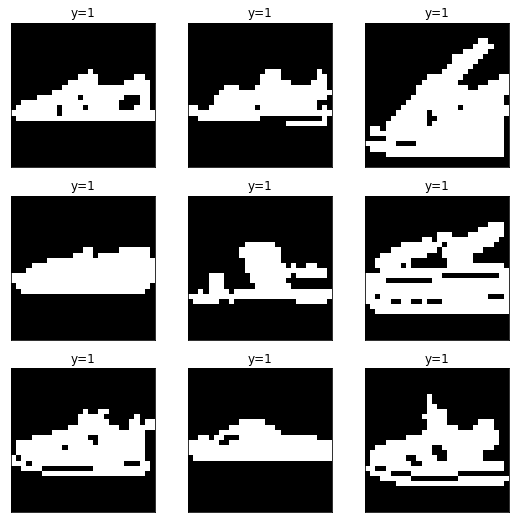

In [1018]:
show_images(x_FN, y_FN)

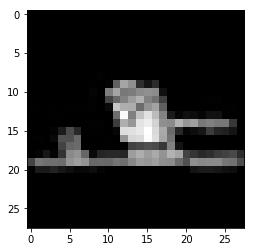

In [1012]:
plt.imshow(x_tr[FN_list[4]].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')

When 

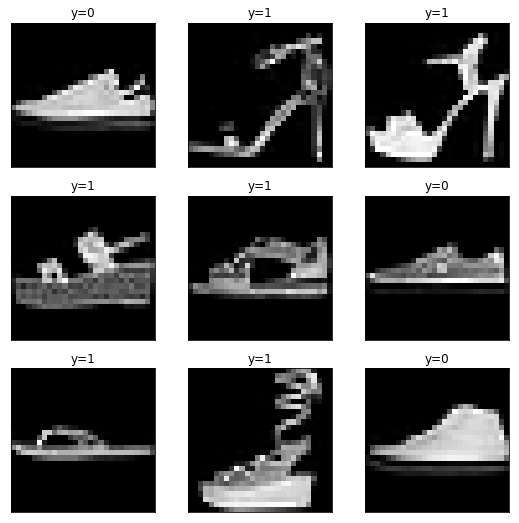

In [1049]:
show_images(x_tr, y_tr)

In [672]:
x_trbw_29 = np.zeros((12000,29,29))

for i in range(12000):
    for j in range(28):
        for k in range(28):
            x_trbw_29[i][j][k] = x_trbw[i].reshape(28,28)[j][k]
        x_trbw_29[i][j][28] = np.sum(x_trbw_29[i][j])/28
    x_trbw_29[i][28] = np.append(np.sum(x_trbw[i].reshape(28,28),axis=0),np.sum(x_trbw[i])/28)/28
    
    

In [673]:
x_trbw_29_2 = np.zeros((12000,841))
for i in range(12000):
    x_trbw_29_2[i] = x_trbw_29[i].reshape(841)
    

In [674]:
x_tebw_29 = np.zeros((2000,29,29))
for i in range(2000):
    for j in range(28):
        for k in range(28):
            x_tebw_29[i][j][k] = x_tebw[i].reshape(28,28)[j][k]
        x_tebw_29[i][j][28] = np.sum(x_tebw_29[i][j])/28
    x_tebw_29[i][28] = np.append(np.sum(x_tebw[i].reshape(28,28),axis=0),np.sum(x_trbw[i])/28)/28
    

    

In [675]:
b = np.zeros((12000, 4))
x_trbw_29_3 = np.column_stack((x_trbw_29_2,b))
for i in range(12000):
    x_trbw_29_3[i][-1] = (x_trbw_29_3[i][-20]+x_trbw_29_3[i][-19]+x_trbw_29_3[i][-18]+x_trbw_29_3[i][-17]+x_trbw_29_3[i][-16]+x_trbw_29_3[i][-15])/6
    x_trbw_29_3[i][-2] = (x_trbw_29_3[i][-5]+x_trbw_29_3[i][-6]+x_trbw_29_3[i][-7]+x_trbw_29_3[i][-8]+x_trbw_29_3[i][-9]+x_trbw_29_3[i][-10])/6
    x_trbw_29_3[i][-3] = (x_trbw_29_3[i][318]+x_trbw_29_3[i][347]+x_trbw_29_3[i][376]+x_trbw_29_3[i][405]+x_trbw_29_3[i][434]+x_trbw_29_3[i][463])/6
    x_trbw_29_3[i][-2] = (x_trbw_29_3[i][144]+x_trbw_29_3[i][173]+x_trbw_29_3[i][202]+x_trbw_29_3[i][231]+x_trbw_29_3[i][260]+x_trbw_29_3[i][289])/6

In [573]:
x_tebw_29_2 = np.zeros((2000,841))
for i in range(2000):
    x_tebw_29_2[i] = x_tebw_29[i].reshape(841)

In [677]:
b = np.zeros((2000, 4))
x_tebw_29_3 = np.column_stack((x_tebw_29_2,b))
for i in range(2000):
    x_tebw_29_3[i][-1] = (x_tebw_29_3[i][-20]+x_tebw_29_3[i][-19]+x_tebw_29_3[i][-18]+x_tebw_29_3[i][-17]+x_tebw_29_3[i][-16]+x_tebw_29_3[i][-15])/6
    x_tebw_29_3[i][-2] = (x_tebw_29_3[i][-5]+x_tebw_29_3[i][-6]+x_tebw_29_3[i][-7]+x_tebw_29_3[i][-8]+x_tebw_29_3[i][-9]+x_tebw_29_3[i][-10])/6
    x_tebw_29_3[i][-3] = (x_tebw_29_3[i][318]+x_tebw_29_3[i][347]+x_tebw_29_3[i][376]+x_tebw_29_3[i][405]+x_tebw_29_3[i][434]+x_tebw_29_3[i][463])/6
    x_tebw_29_3[i][-2] = (x_tebw_29_3[i][144]+x_tebw_29_3[i][173]+x_tebw_29_3[i][202]+x_tebw_29_3[i][231]+x_tebw_29_3[i][260]+x_tebw_29_3[i][289])/6

In [567]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_trbw_29_2)
x_trbw_29_3 = scaler.transform(x_trbw_29_2)

In [574]:
scaler = MinMaxScaler()
scaler.fit(x_tebw_29_2)
x_tebw_29_3 = scaler.transform(x_tebw_29_2)

array([1, 1], dtype=int32)

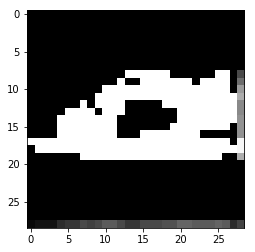

In [700]:
plt.imshow(x_trbw_29_2[4].reshape(29,29), interpolation='nearest', vmin=0, vmax=1, cmap='gray')

In [745]:
np.sum(x_trbw[202])

227.0

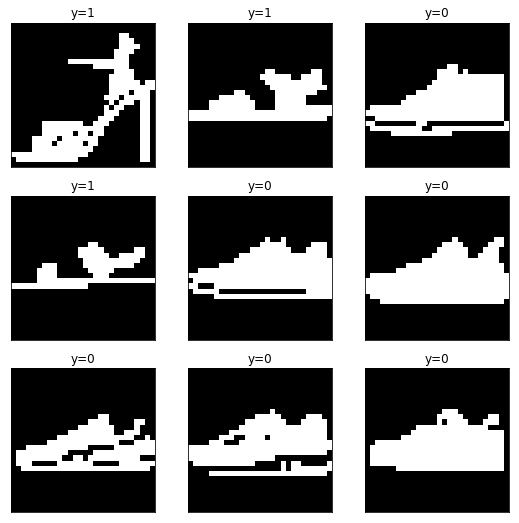

In [1024]:
show_images(x_trbw[200:], y_tr[200:])

In [272]:
x_c2 = np.array(x_c)
c_c2 = x_c2.reshape(12000,392)

In [678]:
x_trbw_29_3[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [688]:
lr_p3 = LogisticRegressionGradientDescent(alpha=1, step_size=0.1, init_w_recipe='zeros')
lr_p3.fit(x_trbw_29_3, y_tr)


Initializing w_G with 846 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.047714  w[0]    0.000 bias    0.000
iter    1/30000  loss         1.024628  avg_L1_norm_grad         0.099551  w[0]    0.000 bias    0.000
iter    2/30000  loss         2.233137  avg_L1_norm_grad         0.187640  w[0]    0.000 bias    0.041
iter    3/30000  loss         3.684080  avg_L1_norm_grad         0.177505  w[0]    0.000 bias   -0.021
iter    4/30000  loss         0.866383  avg_L1_norm_grad         0.077747  w[0]    0.000 bias    0.049
iter    5/30000  loss         1.345333  avg_L1_norm_grad         0.112638  w[0]    0.000 bias    0.029
iter    6/30000  loss         1.589600  avg_L1_norm_grad         0.162798  w[0]    0.000 bias    0.077
iter    7/30000  loss         2.708757  avg_L1_norm_grad         0.154391  w[0]    0.000 bias    0.025
iter    8/30000  loss         0.831000  avg_L1_norm_grad

iter  620/30000  loss         0.170754  avg_L1_norm_grad         0.000486  w[0]    0.000 bias    1.251
iter  621/30000  loss         0.170695  avg_L1_norm_grad         0.000485  w[0]    0.000 bias    1.252
iter  640/30000  loss         0.169604  avg_L1_norm_grad         0.000476  w[0]    0.000 bias    1.275
iter  641/30000  loss         0.169547  avg_L1_norm_grad         0.000475  w[0]    0.000 bias    1.276
iter  660/30000  loss         0.168499  avg_L1_norm_grad         0.000466  w[0]    0.000 bias    1.298
iter  661/30000  loss         0.168445  avg_L1_norm_grad         0.000466  w[0]    0.000 bias    1.299
iter  680/30000  loss         0.167437  avg_L1_norm_grad         0.000457  w[0]    0.000 bias    1.321
iter  681/30000  loss         0.167385  avg_L1_norm_grad         0.000456  w[0]    0.000 bias    1.322
iter  700/30000  loss         0.166415  avg_L1_norm_grad         0.000448  w[0]    0.000 bias    1.343
iter  701/30000  loss         0.166365  avg_L1_norm_grad         0.000448

iter 1420/30000  loss         0.144104  avg_L1_norm_grad         0.000278  w[0]    0.000 bias    2.026
iter 1421/30000  loss         0.144085  avg_L1_norm_grad         0.000278  w[0]    0.000 bias    2.027
iter 1440/30000  loss         0.143711  avg_L1_norm_grad         0.000275  w[0]    0.000 bias    2.042
iter 1441/30000  loss         0.143692  avg_L1_norm_grad         0.000275  w[0]    0.000 bias    2.043
iter 1460/30000  loss         0.143325  avg_L1_norm_grad         0.000273  w[0]    0.000 bias    2.058
iter 1461/30000  loss         0.143306  avg_L1_norm_grad         0.000273  w[0]    0.000 bias    2.059
iter 1480/30000  loss         0.142945  avg_L1_norm_grad         0.000270  w[0]    0.000 bias    2.075
iter 1481/30000  loss         0.142927  avg_L1_norm_grad         0.000270  w[0]    0.000 bias    2.075
iter 1500/30000  loss         0.142573  avg_L1_norm_grad         0.000268  w[0]    0.000 bias    2.091
iter 1501/30000  loss         0.142554  avg_L1_norm_grad         0.000268

iter 2220/30000  loss         0.132328  avg_L1_norm_grad         0.000205  w[0]    0.000 bias    2.614
iter 2221/30000  loss         0.132317  avg_L1_norm_grad         0.000205  w[0]    0.000 bias    2.615
iter 2240/30000  loss         0.132107  avg_L1_norm_grad         0.000203  w[0]    0.000 bias    2.627
iter 2241/30000  loss         0.132096  avg_L1_norm_grad         0.000203  w[0]    0.000 bias    2.628
iter 2260/30000  loss         0.131889  avg_L1_norm_grad         0.000202  w[0]    0.000 bias    2.640
iter 2261/30000  loss         0.131878  avg_L1_norm_grad         0.000202  w[0]    0.000 bias    2.641
iter 2280/30000  loss         0.131673  avg_L1_norm_grad         0.000201  w[0]    0.000 bias    2.654
iter 2281/30000  loss         0.131663  avg_L1_norm_grad         0.000201  w[0]    0.000 bias    2.654
iter 2300/30000  loss         0.131460  avg_L1_norm_grad         0.000200  w[0]    0.000 bias    2.667
iter 2301/30000  loss         0.131449  avg_L1_norm_grad         0.000200

iter 3020/30000  loss         0.125070  avg_L1_norm_grad         0.000166  w[0]    0.000 bias    3.104
iter 3021/30000  loss         0.125063  avg_L1_norm_grad         0.000166  w[0]    0.000 bias    3.104
iter 3040/30000  loss         0.124922  avg_L1_norm_grad         0.000165  w[0]    0.000 bias    3.115
iter 3041/30000  loss         0.124914  avg_L1_norm_grad         0.000165  w[0]    0.000 bias    3.116
iter 3060/30000  loss         0.124774  avg_L1_norm_grad         0.000164  w[0]    0.000 bias    3.126
iter 3061/30000  loss         0.124767  avg_L1_norm_grad         0.000164  w[0]    0.000 bias    3.127
iter 3080/30000  loss         0.124628  avg_L1_norm_grad         0.000164  w[0]    0.000 bias    3.138
iter 3081/30000  loss         0.124621  avg_L1_norm_grad         0.000164  w[0]    0.000 bias    3.138
iter 3100/30000  loss         0.124483  avg_L1_norm_grad         0.000163  w[0]    0.000 bias    3.149
iter 3101/30000  loss         0.124476  avg_L1_norm_grad         0.000163

iter 3820/30000  loss         0.119946  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.528
iter 3821/30000  loss         0.119940  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.529
iter 3840/30000  loss         0.119836  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    3.538
iter 3841/30000  loss         0.119830  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    3.539
iter 3860/30000  loss         0.119727  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    3.548
iter 3861/30000  loss         0.119721  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    3.549
iter 3880/30000  loss         0.119618  avg_L1_norm_grad         0.000139  w[0]    0.000 bias    3.558
iter 3881/30000  loss         0.119613  avg_L1_norm_grad         0.000139  w[0]    0.000 bias    3.559
iter 3900/30000  loss         0.119511  avg_L1_norm_grad         0.000139  w[0]    0.000 bias    3.568
iter 3901/30000  loss         0.119505  avg_L1_norm_grad         0.000139

iter 4620/30000  loss         0.116058  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.905
iter 4621/30000  loss         0.116054  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.905
iter 4640/30000  loss         0.115973  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.914
iter 4641/30000  loss         0.115968  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.914
iter 4660/30000  loss         0.115888  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    3.923
iter 4661/30000  loss         0.115883  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    3.923
iter 4680/30000  loss         0.115803  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    3.931
iter 4681/30000  loss         0.115799  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    3.932
iter 4700/30000  loss         0.115719  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    3.940
iter 4701/30000  loss         0.115715  avg_L1_norm_grad         0.000121

iter 5420/30000  loss         0.112978  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    4.243
iter 5421/30000  loss         0.112975  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    4.244
iter 5440/30000  loss         0.112909  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.251
iter 5441/30000  loss         0.112906  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.252
iter 5460/30000  loss         0.112841  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.260
iter 5461/30000  loss         0.112837  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.260
iter 5480/30000  loss         0.112772  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.268
iter 5481/30000  loss         0.112769  avg_L1_norm_grad         0.000109  w[0]    0.000 bias    4.268
iter 5500/30000  loss         0.112705  avg_L1_norm_grad         0.000108  w[0]    0.000 bias    4.276
iter 5501/30000  loss         0.112701  avg_L1_norm_grad         0.000108

iter 6220/30000  loss         0.110466  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.551
iter 6221/30000  loss         0.110463  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.552
iter 6240/30000  loss         0.110409  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.559
iter 6241/30000  loss         0.110407  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.559
iter 6260/30000  loss         0.110353  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.566
iter 6261/30000  loss         0.110350  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.566
iter 6280/30000  loss         0.110296  avg_L1_norm_grad         0.000098  w[0]    0.000 bias    4.573
iter 6281/30000  loss         0.110293  avg_L1_norm_grad         0.000098  w[0]    0.000 bias    4.574
iter 6300/30000  loss         0.110240  avg_L1_norm_grad         0.000098  w[0]    0.000 bias    4.580
iter 6301/30000  loss         0.110237  avg_L1_norm_grad         0.000098

iter 7020/30000  loss         0.108375  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.833
iter 7021/30000  loss         0.108373  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.833
iter 7040/30000  loss         0.108327  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.840
iter 7041/30000  loss         0.108325  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.840
iter 7060/30000  loss         0.108280  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.846
iter 7061/30000  loss         0.108277  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.847
iter 7080/30000  loss         0.108232  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.853
iter 7081/30000  loss         0.108230  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.854
iter 7100/30000  loss         0.108185  avg_L1_norm_grad         0.000090  w[0]    0.000 bias    4.860
iter 7101/30000  loss         0.108183  avg_L1_norm_grad         0.000090

iter 7820/30000  loss         0.106607  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.093
iter 7821/30000  loss         0.106605  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.093
iter 7840/30000  loss         0.106567  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.099
iter 7841/30000  loss         0.106565  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.099
iter 7860/30000  loss         0.106526  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.105
iter 7861/30000  loss         0.106524  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.105
iter 7880/30000  loss         0.106486  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.111
iter 7881/30000  loss         0.106484  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.112
iter 7900/30000  loss         0.106446  avg_L1_norm_grad         0.000083  w[0]    0.000 bias    5.117
iter 7901/30000  loss         0.106444  avg_L1_norm_grad         0.000083

iter 8620/30000  loss         0.105096  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.333
iter 8621/30000  loss         0.105094  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.333
iter 8640/30000  loss         0.105061  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.339
iter 8641/30000  loss         0.105059  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.339
iter 8660/30000  loss         0.105026  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.344
iter 8661/30000  loss         0.105024  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.345
iter 8680/30000  loss         0.104991  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.350
iter 8681/30000  loss         0.104989  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.350
iter 8700/30000  loss         0.104957  avg_L1_norm_grad         0.000077  w[0]    0.000 bias    5.356
iter 8701/30000  loss         0.104955  avg_L1_norm_grad         0.000077

iter 9420/30000  loss         0.103791  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.556
iter 9421/30000  loss         0.103789  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.556
iter 9440/30000  loss         0.103760  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.561
iter 9441/30000  loss         0.103759  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.562
iter 9460/30000  loss         0.103730  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.567
iter 9461/30000  loss         0.103728  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.567
iter 9480/30000  loss         0.103700  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.572
iter 9481/30000  loss         0.103698  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.572
iter 9500/30000  loss         0.103670  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    5.577
iter 9501/30000  loss         0.103668  avg_L1_norm_grad         0.000072

iter 10220/30000  loss         0.102655  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.764
iter 10221/30000  loss         0.102653  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.764
iter 10240/30000  loss         0.102628  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.769
iter 10241/30000  loss         0.102627  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    5.769
iter 10260/30000  loss         0.102602  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.774
iter 10261/30000  loss         0.102600  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.774
iter 10280/30000  loss         0.102575  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.779
iter 10281/30000  loss         0.102574  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.779
iter 10300/30000  loss         0.102549  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    5.784
iter 10301/30000  loss         0.102548  avg_L1_norm_grad       

iter 11020/30000  loss         0.101659  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.958
iter 11021/30000  loss         0.101658  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.959
iter 11040/30000  loss         0.101636  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.963
iter 11041/30000  loss         0.101634  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.963
iter 11060/30000  loss         0.101612  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.968
iter 11061/30000  loss         0.101611  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    5.968
iter 11080/30000  loss         0.101589  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    5.972
iter 11081/30000  loss         0.101588  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    5.973
iter 11100/30000  loss         0.101566  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    5.977
iter 11101/30000  loss         0.101565  avg_L1_norm_grad       

iter 11820/30000  loss         0.100781  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.140
iter 11821/30000  loss         0.100780  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.140
iter 11840/30000  loss         0.100760  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.145
iter 11841/30000  loss         0.100759  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.145
iter 11860/30000  loss         0.100739  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.149
iter 11861/30000  loss         0.100738  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.149
iter 11880/30000  loss         0.100719  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.153
iter 11881/30000  loss         0.100718  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.154
iter 11900/30000  loss         0.100698  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    6.158
iter 11901/30000  loss         0.100697  avg_L1_norm_grad       

iter 12620/30000  loss         0.100002  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.311
iter 12621/30000  loss         0.100001  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.311
iter 12640/30000  loss         0.099983  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.315
iter 12641/30000  loss         0.099982  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.315
iter 12660/30000  loss         0.099965  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.319
iter 12661/30000  loss         0.099964  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.320
iter 12680/30000  loss         0.099947  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.324
iter 12681/30000  loss         0.099946  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.324
iter 12700/30000  loss         0.099928  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    6.328
iter 12701/30000  loss         0.099928  avg_L1_norm_grad       

iter 13420/30000  loss         0.099307  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.472
iter 13421/30000  loss         0.099306  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.472
iter 13440/30000  loss         0.099290  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.476
iter 13441/30000  loss         0.099290  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.476
iter 13460/30000  loss         0.099274  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.480
iter 13461/30000  loss         0.099273  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.480
iter 13480/30000  loss         0.099258  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.483
iter 13481/30000  loss         0.099257  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.484
iter 13500/30000  loss         0.099242  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    6.487
iter 13501/30000  loss         0.099241  avg_L1_norm_grad       

iter 14220/30000  loss         0.098685  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.623
iter 14221/30000  loss         0.098684  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.623
iter 14240/30000  loss         0.098670  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.627
iter 14241/30000  loss         0.098669  avg_L1_norm_grad         0.000052  w[0]    0.000 bias    6.627
iter 14260/30000  loss         0.098655  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    6.631
iter 14261/30000  loss         0.098654  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    6.631
iter 14280/30000  loss         0.098641  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    6.634
iter 14281/30000  loss         0.098640  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    6.634
iter 14300/30000  loss         0.098626  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    6.638
iter 14301/30000  loss         0.098625  avg_L1_norm_grad       

iter 15020/30000  loss         0.098125  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.766
iter 15021/30000  loss         0.098124  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.766
iter 15040/30000  loss         0.098112  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.770
iter 15041/30000  loss         0.098111  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.770
iter 15060/30000  loss         0.098098  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.773
iter 15061/30000  loss         0.098098  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.773
iter 15080/30000  loss         0.098085  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.776
iter 15081/30000  loss         0.098084  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.777
iter 15100/30000  loss         0.098072  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    6.780
iter 15101/30000  loss         0.098071  avg_L1_norm_grad       

iter 15820/30000  loss         0.097619  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.901
iter 15821/30000  loss         0.097619  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.901
iter 15840/30000  loss         0.097607  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.904
iter 15841/30000  loss         0.097607  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.905
iter 15860/30000  loss         0.097595  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.908
iter 15861/30000  loss         0.097595  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.908
iter 15880/30000  loss         0.097583  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.911
iter 15881/30000  loss         0.097583  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.911
iter 15900/30000  loss         0.097571  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    6.914
iter 15901/30000  loss         0.097571  avg_L1_norm_grad       

iter 16620/30000  loss         0.097161  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.029
iter 16621/30000  loss         0.097161  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.029
iter 16640/30000  loss         0.097150  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.032
iter 16641/30000  loss         0.097150  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.032
iter 16660/30000  loss         0.097140  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.035
iter 16661/30000  loss         0.097139  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.035
iter 16680/30000  loss         0.097129  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.038
iter 16681/30000  loss         0.097128  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.038
iter 16700/30000  loss         0.097118  avg_L1_norm_grad         0.000045  w[0]    0.000 bias    7.041
iter 16701/30000  loss         0.097117  avg_L1_norm_grad       

iter 17420/30000  loss         0.096745  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.150
iter 17421/30000  loss         0.096744  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.150
iter 17440/30000  loss         0.096735  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.153
iter 17441/30000  loss         0.096734  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.153
iter 17460/30000  loss         0.096725  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.156
iter 17461/30000  loss         0.096725  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.156
iter 17480/30000  loss         0.096715  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.159
iter 17481/30000  loss         0.096715  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.159
iter 17500/30000  loss         0.096705  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    7.162
iter 17501/30000  loss         0.096705  avg_L1_norm_grad       

iter 18220/30000  loss         0.096365  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.265
iter 18221/30000  loss         0.096365  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.265
iter 18240/30000  loss         0.096356  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.268
iter 18241/30000  loss         0.096356  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.268
iter 18260/30000  loss         0.096347  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.270
iter 18261/30000  loss         0.096347  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.270
iter 18280/30000  loss         0.096338  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.273
iter 18281/30000  loss         0.096338  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.273
iter 18300/30000  loss         0.096329  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    7.276
iter 18301/30000  loss         0.096329  avg_L1_norm_grad       

iter 19020/30000  loss         0.096018  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.374
iter 19021/30000  loss         0.096017  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.374
iter 19040/30000  loss         0.096010  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.376
iter 19041/30000  loss         0.096009  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.377
iter 19060/30000  loss         0.096001  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.379
iter 19061/30000  loss         0.096001  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    7.379
iter 19080/30000  loss         0.095993  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.382
iter 19081/30000  loss         0.095993  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.382
iter 19100/30000  loss         0.095985  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    7.384
iter 19101/30000  loss         0.095984  avg_L1_norm_grad       

iter 19820/30000  loss         0.095700  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.477
iter 19821/30000  loss         0.095699  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.478
iter 19840/30000  loss         0.095692  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.480
iter 19841/30000  loss         0.095692  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.480
iter 19860/30000  loss         0.095684  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.483
iter 19861/30000  loss         0.095684  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.483
iter 19880/30000  loss         0.095677  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.485
iter 19881/30000  loss         0.095676  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.485
iter 19900/30000  loss         0.095669  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    7.488
iter 19901/30000  loss         0.095669  avg_L1_norm_grad       

iter 20620/30000  loss         0.095407  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.576
iter 20621/30000  loss         0.095407  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.576
iter 20640/30000  loss         0.095400  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.579
iter 20641/30000  loss         0.095400  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.579
iter 20660/30000  loss         0.095393  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.581
iter 20661/30000  loss         0.095393  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.581
iter 20680/30000  loss         0.095386  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.583
iter 20681/30000  loss         0.095386  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.583
iter 20700/30000  loss         0.095379  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    7.586
iter 20701/30000  loss         0.095379  avg_L1_norm_grad       

iter 21420/30000  loss         0.095138  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.670
iter 21421/30000  loss         0.095138  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.670
iter 21440/30000  loss         0.095131  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.672
iter 21441/30000  loss         0.095131  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.672
iter 21460/30000  loss         0.095125  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.675
iter 21461/30000  loss         0.095125  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.675
iter 21480/30000  loss         0.095119  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.677
iter 21481/30000  loss         0.095118  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.677
iter 21500/30000  loss         0.095112  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    7.679
iter 21501/30000  loss         0.095112  avg_L1_norm_grad       

iter 22220/30000  loss         0.094889  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.760
iter 22221/30000  loss         0.094889  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.760
iter 22240/30000  loss         0.094883  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.762
iter 22241/30000  loss         0.094883  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.762
iter 22260/30000  loss         0.094877  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.764
iter 22261/30000  loss         0.094877  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.764
iter 22280/30000  loss         0.094871  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.766
iter 22281/30000  loss         0.094871  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.766
iter 22300/30000  loss         0.094866  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    7.768
iter 22301/30000  loss         0.094865  avg_L1_norm_grad       

iter 23020/30000  loss         0.094660  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.845
iter 23021/30000  loss         0.094659  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.845
iter 23040/30000  loss         0.094654  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.847
iter 23041/30000  loss         0.094654  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.847
iter 23060/30000  loss         0.094648  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.849
iter 23061/30000  loss         0.094648  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.849
iter 23080/30000  loss         0.094643  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.851
iter 23081/30000  loss         0.094643  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.851
iter 23100/30000  loss         0.094637  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    7.853
iter 23101/30000  loss         0.094637  avg_L1_norm_grad       

iter 23820/30000  loss         0.094447  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.927
iter 23821/30000  loss         0.094446  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.927
iter 23840/30000  loss         0.094442  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.929
iter 23841/30000  loss         0.094441  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.929
iter 23860/30000  loss         0.094436  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.930
iter 23861/30000  loss         0.094436  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.931
iter 23880/30000  loss         0.094431  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.932
iter 23881/30000  loss         0.094431  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.933
iter 23900/30000  loss         0.094426  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    7.934
iter 23901/30000  loss         0.094426  avg_L1_norm_grad       

iter 24620/30000  loss         0.094249  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.004
iter 24621/30000  loss         0.094249  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.004
iter 24640/30000  loss         0.094244  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.006
iter 24641/30000  loss         0.094244  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.006
iter 24660/30000  loss         0.094240  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.008
iter 24661/30000  loss         0.094239  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.008
iter 24680/30000  loss         0.094235  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.010
iter 24681/30000  loss         0.094235  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.010
iter 24700/30000  loss         0.094230  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    8.012
iter 24701/30000  loss         0.094230  avg_L1_norm_grad       

iter 25420/30000  loss         0.094066  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.079
iter 25421/30000  loss         0.094065  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.079
iter 25440/30000  loss         0.094061  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.081
iter 25441/30000  loss         0.094061  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.081
iter 25460/30000  loss         0.094057  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.082
iter 25461/30000  loss         0.094057  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.082
iter 25480/30000  loss         0.094052  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.084
iter 25481/30000  loss         0.094052  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.084
iter 25500/30000  loss         0.094048  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    8.086
iter 25501/30000  loss         0.094048  avg_L1_norm_grad       

iter 26220/30000  loss         0.093895  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.150
iter 26221/30000  loss         0.093894  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.150
iter 26240/30000  loss         0.093891  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.152
iter 26241/30000  loss         0.093890  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.152
iter 26260/30000  loss         0.093886  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.153
iter 26261/30000  loss         0.093886  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.153
iter 26280/30000  loss         0.093882  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.155
iter 26281/30000  loss         0.093882  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.155
iter 26300/30000  loss         0.093878  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    8.157
iter 26301/30000  loss         0.093878  avg_L1_norm_grad       

iter 27020/30000  loss         0.093735  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.218
iter 27021/30000  loss         0.093735  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.218
iter 27040/30000  loss         0.093732  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.220
iter 27041/30000  loss         0.093731  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.220
iter 27060/30000  loss         0.093728  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.221
iter 27061/30000  loss         0.093728  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.221
iter 27080/30000  loss         0.093724  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.223
iter 27081/30000  loss         0.093724  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.223
iter 27100/30000  loss         0.093720  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    8.225
iter 27101/30000  loss         0.093720  avg_L1_norm_grad       

iter 27820/30000  loss         0.093587  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.283
iter 27821/30000  loss         0.093587  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.283
iter 27840/30000  loss         0.093583  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.285
iter 27841/30000  loss         0.093583  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.285
iter 27860/30000  loss         0.093580  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.286
iter 27861/30000  loss         0.093579  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.286
iter 27880/30000  loss         0.093576  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.288
iter 27881/30000  loss         0.093576  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.288
iter 27900/30000  loss         0.093572  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    8.290
iter 27901/30000  loss         0.093572  avg_L1_norm_grad       

iter 28620/30000  loss         0.093448  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.346
iter 28621/30000  loss         0.093448  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.346
iter 28640/30000  loss         0.093444  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.347
iter 28641/30000  loss         0.093444  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.347
iter 28660/30000  loss         0.093441  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.349
iter 28661/30000  loss         0.093441  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.349
iter 28680/30000  loss         0.093438  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.350
iter 28681/30000  loss         0.093437  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.350
iter 28700/30000  loss         0.093434  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    8.352
iter 28701/30000  loss         0.093434  avg_L1_norm_grad       

iter 29420/30000  loss         0.093318  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.405
iter 29421/30000  loss         0.093317  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.406
iter 29440/30000  loss         0.093314  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.407
iter 29441/30000  loss         0.093314  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.407
iter 29460/30000  loss         0.093311  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.408
iter 29461/30000  loss         0.093311  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.408
iter 29480/30000  loss         0.093308  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.410
iter 29481/30000  loss         0.093308  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.410
iter 29500/30000  loss         0.093305  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    8.411
iter 29501/30000  loss         0.093305  avg_L1_norm_grad       

In [ ]:
lr_p3

In [695]:
x_tebw_29_3.shape

(2000, 845)

In [719]:
x_trbw_29_4 = x_trbw_29_3
y_hat = lr_p3.predict(x_trbw_29_4)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion


Predicted,0,1
Actual,,
0.0,5937,63
1.0,149,5851


In [933]:
TP = 0
TN = 0
FP = 0
FN = 0
FP_list = list()
FN_list = list()

for i in range(len(y_hat)):
    if y_hat[i] == y_tr[i]  == 1:
        TP = TP + 1
    elif y_hat[i] == y_tr[i]  == 0:
        TN = TN + 1
    elif (y_hat[i] == 1) & (y_tr[i]  == 0):
        FP = FP + 1
        FP_list.append(i)
    else:
        FN = FN + 1
        FN_list.append(i)

In [934]:
x_FP = [x_trbw[i] for i in FP_list]
y_FP = [y_tr[i] for i in FP_list]
x_FP = x_FP[25:46]

x_FN = [x_trbw[i] for i in FN_list]
y_FN = [y_tr[i] for i in FN_list]

x_FN = x_FN[23:43]

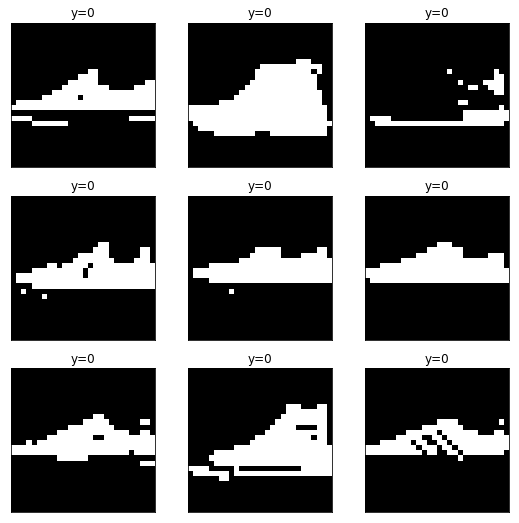

In [935]:
show_images(x_FP, y_FP)

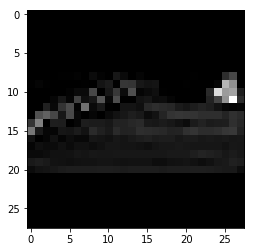

In [940]:
plt.imshow(x_tr[214].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')

In [938]:
FP_list

[214,
 290,
 321,
 536,
 579,
 774,
 882,
 919,
 926,
 1060,
 1141,
 1222,
 1235,
 1254,
 1267,
 1277,
 1338,
 1363,
 1380,
 1432,
 1469,
 1494,
 1542,
 1610,
 1689,
 1831,
 1877,
 1914,
 1920,
 1921,
 2023,
 2071,
 2169,
 2204,
 2299,
 2315,
 2537,
 2736,
 2823,
 2849,
 2906,
 2920,
 2951,
 2995,
 3042,
 3113,
 3212,
 3228,
 3285,
 3486,
 3524,
 3529,
 3534,
 3579,
 3588,
 3593,
 3678,
 3709,
 3750,
 3770,
 3790,
 3864,
 3926,
 3939,
 3996,
 4041,
 4232,
 4245,
 4258,
 4274,
 4275,
 4362,
 4618,
 4754,
 4783,
 4887,
 4968,
 5057,
 5071,
 5157,
 5160,
 5175,
 5183,
 5197,
 5223,
 5252,
 5321,
 5331,
 5352,
 5390,
 5440,
 5480,
 5546,
 5553,
 5708,
 5713,
 5748,
 5791,
 5871,
 6032,
 6070,
 6112,
 6230,
 6342,
 6393,
 6395,
 6648,
 6687,
 6826,
 7118,
 7191,
 7250,
 7264,
 7282,
 7309,
 7401,
 7454,
 7469,
 7581,
 7617,
 7696,
 7740,
 7779,
 7808,
 7845,
 7967,
 8039,
 8054,
 8116,
 8146,
 8149,
 8194,
 8275,
 8290,
 8305,
 8359,
 8437,
 8438,
 8471,
 8516,
 8548,
 8562,
 8599,
 8689,
 

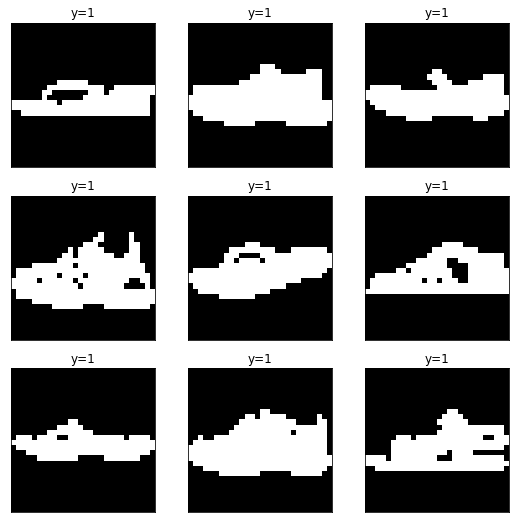

In [723]:
show_images(x_FN, y_FN)

In [729]:
np.sum(x_FN[4])

190.0

In [696]:
yproba1_test_N = lr_p3.predict_proba(x_tebw_29_3)[:, 1]

np.savetxt('yproba3_test.txt', yproba1_test_N)

In [555]:
x_trbw_2 = x_trbw

y_hat = lr.predict(x_trbw_2)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion


Predicted,0,1
Actual,,
0.0,3714,2286
1.0,1433,4567


In [886]:
x_trbw160 = np.zeros(784)
y_trbw160 = np.array([])
for i in range(12000):
    if np.sum(x_trbw[i]) > 200:
        x_trbw160 = np.row_stack((x_trbw160,x_trbw[i]))
        y_trbw160 = np.append(y_trbw160, y_tr[i])
    
x_trbw160 = np.delete(x_trbw160, 0, 0) 

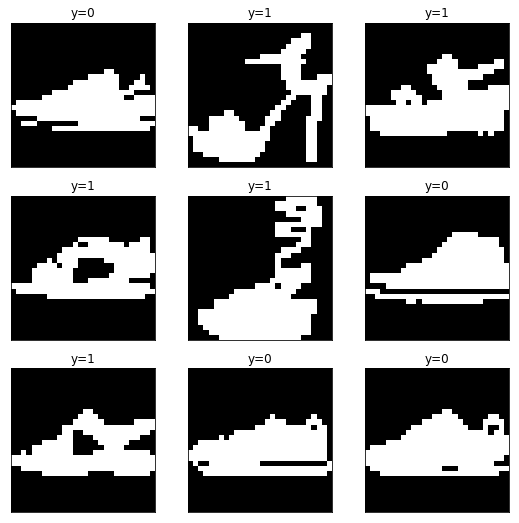

In [887]:
show_images(x_trbw160, y_trbw160)

In [911]:
x_tebw160 = np.zeros((2000, 784))
k = 0
for i in range(2000):
    if np.sum(x_tebw[i]) > 150:
        x_tebw160[i] = x_tebw[i]
        k = k + 1
    


In [912]:
k

1701

In [907]:
x_trbw160_2 = np.zeros((12000, 784))
k = 0
for i in range(12000):
    if np.sum(x_trbw[i]) > 150:
        x_trbw160_2[i] = x_trbw[i]
        k = k + 1

In [772]:
y_trbw160

array([], dtype=float64)

In [797]:
b = np.array([])
c = np.array([1,2,2,3])

In [804]:
b = np.append(b,c[2])

In [805]:
b

array([2., 2.])

In [865]:
len(y_trbw160)

10211

In [866]:
len(x_trbw160)

10211

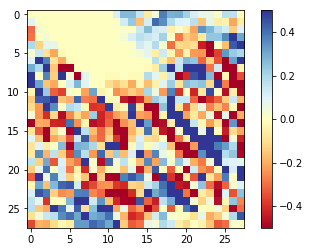

In [1050]:

plt.imshow(lr_p3.w_G[0:784].reshape(28,28), interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar()

In [867]:
lr_p3_150 = LogisticRegressionGradientDescent(alpha=1, step_size=0.1, init_w_recipe='zeros')
lr_p3_150.fit(x_trbw160, y_trbw160)


Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.071016  w[0]    0.000 bias    0.000
iter    1/30000  loss         1.221002  avg_L1_norm_grad         0.133613  w[0]    0.000 bias   -0.011
iter    2/30000  loss         2.467284  avg_L1_norm_grad         0.220407  w[0]    0.000 bias    0.035
iter    3/30000  loss         3.682488  avg_L1_norm_grad         0.173556  w[0]    0.000 bias   -0.040
iter    4/30000  loss         0.673632  avg_L1_norm_grad         0.026777  w[0]    0.000 bias    0.019
iter    5/30000  loss         0.637516  avg_L1_norm_grad         0.035729  w[0]    0.000 bias    0.030
iter    6/30000  loss         0.656031  avg_L1_norm_grad         0.045353  w[0]    0.000 bias    0.023
iter    7/30000  loss         0.723100  avg_L1_norm_grad         0.082291  w[0]    0.000 bias    0.041
iter    8/30000  loss         1.107061  avg_L1_norm_grad

iter  620/30000  loss         0.164245  avg_L1_norm_grad         0.000535  w[0]    0.000 bias    0.750
iter  621/30000  loss         0.164190  avg_L1_norm_grad         0.000534  w[0]    0.000 bias    0.751
iter  640/30000  loss         0.163175  avg_L1_norm_grad         0.000524  w[0]    0.000 bias    0.766
iter  641/30000  loss         0.163123  avg_L1_norm_grad         0.000524  w[0]    0.000 bias    0.767
iter  660/30000  loss         0.162148  avg_L1_norm_grad         0.000514  w[0]    0.000 bias    0.781
iter  661/30000  loss         0.162098  avg_L1_norm_grad         0.000514  w[0]    0.000 bias    0.782
iter  680/30000  loss         0.161161  avg_L1_norm_grad         0.000505  w[0]    0.000 bias    0.797
iter  681/30000  loss         0.161112  avg_L1_norm_grad         0.000504  w[0]    0.000 bias    0.797
iter  700/30000  loss         0.160211  avg_L1_norm_grad         0.000496  w[0]    0.000 bias    0.812
iter  701/30000  loss         0.160164  avg_L1_norm_grad         0.000495

iter 1420/30000  loss         0.139441  avg_L1_norm_grad         0.000316  w[0]    0.000 bias    1.274
iter 1421/30000  loss         0.139423  avg_L1_norm_grad         0.000316  w[0]    0.000 bias    1.274
iter 1440/30000  loss         0.139074  avg_L1_norm_grad         0.000313  w[0]    0.000 bias    1.285
iter 1441/30000  loss         0.139056  avg_L1_norm_grad         0.000313  w[0]    0.000 bias    1.285
iter 1460/30000  loss         0.138714  avg_L1_norm_grad         0.000310  w[0]    0.000 bias    1.296
iter 1461/30000  loss         0.138696  avg_L1_norm_grad         0.000310  w[0]    0.000 bias    1.297
iter 1480/30000  loss         0.138360  avg_L1_norm_grad         0.000308  w[0]    0.000 bias    1.307
iter 1481/30000  loss         0.138342  avg_L1_norm_grad         0.000307  w[0]    0.000 bias    1.308
iter 1500/30000  loss         0.138012  avg_L1_norm_grad         0.000305  w[0]    0.000 bias    1.318
iter 1501/30000  loss         0.137995  avg_L1_norm_grad         0.000305

iter 2220/30000  loss         0.128452  avg_L1_norm_grad         0.000235  w[0]    0.000 bias    1.683
iter 2221/30000  loss         0.128442  avg_L1_norm_grad         0.000235  w[0]    0.000 bias    1.683
iter 2240/30000  loss         0.128246  avg_L1_norm_grad         0.000234  w[0]    0.000 bias    1.692
iter 2241/30000  loss         0.128236  avg_L1_norm_grad         0.000233  w[0]    0.000 bias    1.693
iter 2260/30000  loss         0.128043  avg_L1_norm_grad         0.000232  w[0]    0.000 bias    1.702
iter 2261/30000  loss         0.128033  avg_L1_norm_grad         0.000232  w[0]    0.000 bias    1.702
iter 2280/30000  loss         0.127842  avg_L1_norm_grad         0.000231  w[0]    0.000 bias    1.711
iter 2281/30000  loss         0.127832  avg_L1_norm_grad         0.000231  w[0]    0.000 bias    1.711
iter 2300/30000  loss         0.127643  avg_L1_norm_grad         0.000229  w[0]    0.000 bias    1.720
iter 2301/30000  loss         0.127633  avg_L1_norm_grad         0.000229

iter 3020/30000  loss         0.121699  avg_L1_norm_grad         0.000191  w[0]    0.000 bias    2.033
iter 3021/30000  loss         0.121692  avg_L1_norm_grad         0.000190  w[0]    0.000 bias    2.033
iter 3040/30000  loss         0.121560  avg_L1_norm_grad         0.000190  w[0]    0.000 bias    2.041
iter 3041/30000  loss         0.121553  avg_L1_norm_grad         0.000190  w[0]    0.000 bias    2.041
iter 3060/30000  loss         0.121423  avg_L1_norm_grad         0.000189  w[0]    0.000 bias    2.049
iter 3061/30000  loss         0.121417  avg_L1_norm_grad         0.000189  w[0]    0.000 bias    2.050
iter 3080/30000  loss         0.121288  avg_L1_norm_grad         0.000188  w[0]    0.000 bias    2.057
iter 3081/30000  loss         0.121281  avg_L1_norm_grad         0.000188  w[0]    0.000 bias    2.058
iter 3100/30000  loss         0.121153  avg_L1_norm_grad         0.000187  w[0]    0.000 bias    2.065
iter 3101/30000  loss         0.121146  avg_L1_norm_grad         0.000187

iter 3820/30000  loss         0.116945  avg_L1_norm_grad         0.000162  w[0]    0.000 bias    2.344
iter 3821/30000  loss         0.116940  avg_L1_norm_grad         0.000162  w[0]    0.000 bias    2.344
iter 3840/30000  loss         0.116843  avg_L1_norm_grad         0.000161  w[0]    0.000 bias    2.351
iter 3841/30000  loss         0.116838  avg_L1_norm_grad         0.000161  w[0]    0.000 bias    2.351
iter 3860/30000  loss         0.116742  avg_L1_norm_grad         0.000161  w[0]    0.000 bias    2.358
iter 3861/30000  loss         0.116737  avg_L1_norm_grad         0.000161  w[0]    0.000 bias    2.359
iter 3880/30000  loss         0.116641  avg_L1_norm_grad         0.000160  w[0]    0.000 bias    2.366
iter 3881/30000  loss         0.116636  avg_L1_norm_grad         0.000160  w[0]    0.000 bias    2.366
iter 3900/30000  loss         0.116542  avg_L1_norm_grad         0.000160  w[0]    0.000 bias    2.373
iter 3901/30000  loss         0.116537  avg_L1_norm_grad         0.000160

iter 4620/30000  loss         0.113344  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.626
iter 4621/30000  loss         0.113340  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.626
iter 4640/30000  loss         0.113265  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.632
iter 4641/30000  loss         0.113261  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.633
iter 4660/30000  loss         0.113186  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.639
iter 4661/30000  loss         0.113182  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    2.639
iter 4680/30000  loss         0.113108  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    2.646
iter 4681/30000  loss         0.113104  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    2.646
iter 4700/30000  loss         0.113030  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    2.653
iter 4701/30000  loss         0.113026  avg_L1_norm_grad         0.000140

iter 5420/30000  loss         0.110491  avg_L1_norm_grad         0.000126  w[0]    0.000 bias    2.885
iter 5421/30000  loss         0.110488  avg_L1_norm_grad         0.000126  w[0]    0.000 bias    2.885
iter 5440/30000  loss         0.110428  avg_L1_norm_grad         0.000126  w[0]    0.000 bias    2.891
iter 5441/30000  loss         0.110424  avg_L1_norm_grad         0.000126  w[0]    0.000 bias    2.891
iter 5460/30000  loss         0.110364  avg_L1_norm_grad         0.000125  w[0]    0.000 bias    2.897
iter 5461/30000  loss         0.110361  avg_L1_norm_grad         0.000125  w[0]    0.000 bias    2.898
iter 5480/30000  loss         0.110301  avg_L1_norm_grad         0.000125  w[0]    0.000 bias    2.903
iter 5481/30000  loss         0.110298  avg_L1_norm_grad         0.000125  w[0]    0.000 bias    2.904
iter 5500/30000  loss         0.110238  avg_L1_norm_grad         0.000125  w[0]    0.000 bias    2.910
iter 5501/30000  loss         0.110235  avg_L1_norm_grad         0.000125

iter 6220/30000  loss         0.108163  avg_L1_norm_grad         0.000114  w[0]    0.000 bias    3.125
iter 6221/30000  loss         0.108161  avg_L1_norm_grad         0.000114  w[0]    0.000 bias    3.125
iter 6240/30000  loss         0.108110  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.131
iter 6241/30000  loss         0.108108  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.131
iter 6260/30000  loss         0.108058  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.137
iter 6261/30000  loss         0.108055  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.137
iter 6280/30000  loss         0.108006  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.142
iter 6281/30000  loss         0.108003  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.143
iter 6300/30000  loss         0.107953  avg_L1_norm_grad         0.000113  w[0]    0.000 bias    3.148
iter 6301/30000  loss         0.107951  avg_L1_norm_grad         0.000113

iter 7020/30000  loss         0.106222  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    3.349
iter 7021/30000  loss         0.106220  avg_L1_norm_grad         0.000104  w[0]    0.000 bias    3.349
iter 7040/30000  loss         0.106178  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.354
iter 7041/30000  loss         0.106175  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.354
iter 7060/30000  loss         0.106133  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.360
iter 7061/30000  loss         0.106131  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.360
iter 7080/30000  loss         0.106089  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.365
iter 7081/30000  loss         0.106087  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.365
iter 7100/30000  loss         0.106046  avg_L1_norm_grad         0.000103  w[0]    0.000 bias    3.370
iter 7101/30000  loss         0.106043  avg_L1_norm_grad         0.000103

iter 7820/30000  loss         0.104578  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.558
iter 7821/30000  loss         0.104576  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.559
iter 7840/30000  loss         0.104540  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.563
iter 7841/30000  loss         0.104538  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.564
iter 7860/30000  loss         0.104502  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.569
iter 7861/30000  loss         0.104500  avg_L1_norm_grad         0.000095  w[0]    0.000 bias    3.569
iter 7880/30000  loss         0.104465  avg_L1_norm_grad         0.000094  w[0]    0.000 bias    3.574
iter 7881/30000  loss         0.104463  avg_L1_norm_grad         0.000094  w[0]    0.000 bias    3.574
iter 7900/30000  loss         0.104427  avg_L1_norm_grad         0.000094  w[0]    0.000 bias    3.579
iter 7901/30000  loss         0.104425  avg_L1_norm_grad         0.000094

iter 8620/30000  loss         0.103168  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    3.755
iter 8621/30000  loss         0.103166  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    3.756
iter 8640/30000  loss         0.103135  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    3.760
iter 8641/30000  loss         0.103133  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    3.760
iter 8660/30000  loss         0.103102  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    3.765
iter 8661/30000  loss         0.103101  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    3.765
iter 8680/30000  loss         0.103070  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    3.770
iter 8681/30000  loss         0.103068  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    3.770
iter 8700/30000  loss         0.103038  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    3.774
iter 8701/30000  loss         0.103036  avg_L1_norm_grad         0.000087

iter 9420/30000  loss         0.101946  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    3.941
iter 9421/30000  loss         0.101944  avg_L1_norm_grad         0.000082  w[0]    0.000 bias    3.941
iter 9440/30000  loss         0.101917  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.945
iter 9441/30000  loss         0.101916  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.946
iter 9460/30000  loss         0.101889  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.950
iter 9461/30000  loss         0.101887  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.950
iter 9480/30000  loss         0.101861  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.954
iter 9481/30000  loss         0.101859  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.955
iter 9500/30000  loss         0.101832  avg_L1_norm_grad         0.000081  w[0]    0.000 bias    3.959
iter 9501/30000  loss         0.101831  avg_L1_norm_grad         0.000081

iter 10220/30000  loss         0.100878  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.116
iter 10221/30000  loss         0.100876  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.116
iter 10240/30000  loss         0.100853  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.120
iter 10241/30000  loss         0.100851  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.121
iter 10260/30000  loss         0.100828  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.125
iter 10261/30000  loss         0.100826  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.125
iter 10280/30000  loss         0.100803  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.129
iter 10281/30000  loss         0.100802  avg_L1_norm_grad         0.000076  w[0]    0.000 bias    4.129
iter 10300/30000  loss         0.100778  avg_L1_norm_grad         0.000075  w[0]    0.000 bias    4.133
iter 10301/30000  loss         0.100777  avg_L1_norm_grad       

iter 11020/30000  loss         0.099937  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.282
iter 11021/30000  loss         0.099936  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.282
iter 11040/30000  loss         0.099915  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.286
iter 11041/30000  loss         0.099914  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.286
iter 11060/30000  loss         0.099893  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.290
iter 11061/30000  loss         0.099892  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.290
iter 11080/30000  loss         0.099871  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.294
iter 11081/30000  loss         0.099870  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.294
iter 11100/30000  loss         0.099849  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    4.298
iter 11101/30000  loss         0.099848  avg_L1_norm_grad       

iter 11801/30000  loss         0.099122  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.436
iter 11820/30000  loss         0.099103  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.439
iter 11821/30000  loss         0.099102  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.440
iter 11840/30000  loss         0.099084  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.443
iter 11841/30000  loss         0.099083  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.443
iter 11860/30000  loss         0.099064  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.447
iter 11861/30000  loss         0.099063  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.447
iter 11880/30000  loss         0.099045  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.451
iter 11881/30000  loss         0.099044  avg_L1_norm_grad         0.000067  w[0]    0.000 bias    4.451
iter 11900/30000  loss         0.099025  avg_L1_norm_grad       

iter 12600/30000  loss         0.098378  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.585
iter 12601/30000  loss         0.098377  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.585
iter 12620/30000  loss         0.098360  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.589
iter 12621/30000  loss         0.098359  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.589
iter 12640/30000  loss         0.098343  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.593
iter 12641/30000  loss         0.098342  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.593
iter 12660/30000  loss         0.098325  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.596
iter 12661/30000  loss         0.098324  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.596
iter 12680/30000  loss         0.098308  avg_L1_norm_grad         0.000063  w[0]    0.000 bias    4.600
iter 12681/30000  loss         0.098307  avg_L1_norm_grad       

iter 13400/30000  loss         0.097710  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.728
iter 13401/30000  loss         0.097709  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.728
iter 13420/30000  loss         0.097694  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.731
iter 13421/30000  loss         0.097693  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.731
iter 13440/30000  loss         0.097678  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    4.735
iter 13441/30000  loss         0.097678  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    4.735
iter 13460/30000  loss         0.097663  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    4.738
iter 13461/30000  loss         0.097662  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    4.738
iter 13480/30000  loss         0.097647  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    4.742
iter 13481/30000  loss         0.097646  avg_L1_norm_grad       

iter 14200/30000  loss         0.097109  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.863
iter 14201/30000  loss         0.097108  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.864
iter 14220/30000  loss         0.097095  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.867
iter 14221/30000  loss         0.097094  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.867
iter 14240/30000  loss         0.097081  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.870
iter 14241/30000  loss         0.097080  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.870
iter 14260/30000  loss         0.097066  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.873
iter 14261/30000  loss         0.097066  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.873
iter 14280/30000  loss         0.097052  avg_L1_norm_grad         0.000056  w[0]    0.000 bias    4.877
iter 14281/30000  loss         0.097052  avg_L1_norm_grad       

iter 15000/30000  loss         0.096566  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.993
iter 15001/30000  loss         0.096565  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.993
iter 15020/30000  loss         0.096553  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.996
iter 15021/30000  loss         0.096553  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.996
iter 15040/30000  loss         0.096540  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.999
iter 15041/30000  loss         0.096540  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    4.999
iter 15060/30000  loss         0.096528  avg_L1_norm_grad         0.000053  w[0]    0.000 bias    5.002
iter 15061/30000  loss         0.096527  avg_L1_norm_grad         0.000053  w[0]    0.000 bias    5.002
iter 15080/30000  loss         0.096515  avg_L1_norm_grad         0.000053  w[0]    0.000 bias    5.005
iter 15081/30000  loss         0.096514  avg_L1_norm_grad       

iter 15800/30000  loss         0.096074  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.116
iter 15801/30000  loss         0.096073  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.117
iter 15820/30000  loss         0.096062  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.119
iter 15821/30000  loss         0.096061  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.120
iter 15840/30000  loss         0.096050  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.122
iter 15841/30000  loss         0.096050  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.123
iter 15860/30000  loss         0.096039  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.125
iter 15861/30000  loss         0.096038  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.126
iter 15880/30000  loss         0.096027  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.128
iter 15881/30000  loss         0.096026  avg_L1_norm_grad       

iter 16600/30000  loss         0.095626  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.235
iter 16601/30000  loss         0.095625  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.235
iter 16620/30000  loss         0.095615  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.238
iter 16621/30000  loss         0.095615  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.238
iter 16640/30000  loss         0.095604  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.240
iter 16641/30000  loss         0.095604  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.241
iter 16660/30000  loss         0.095594  avg_L1_norm_grad         0.000048  w[0]    0.000 bias    5.243
iter 16661/30000  loss         0.095593  avg_L1_norm_grad         0.000048  w[0]    0.000 bias    5.243
iter 16680/30000  loss         0.095583  avg_L1_norm_grad         0.000048  w[0]    0.000 bias    5.246
iter 16681/30000  loss         0.095583  avg_L1_norm_grad       

iter 17400/30000  loss         0.095217  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.348
iter 17401/30000  loss         0.095216  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.348
iter 17420/30000  loss         0.095207  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.351
iter 17421/30000  loss         0.095207  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.351
iter 17440/30000  loss         0.095197  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.353
iter 17441/30000  loss         0.095197  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.354
iter 17460/30000  loss         0.095188  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.356
iter 17461/30000  loss         0.095187  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.356
iter 17480/30000  loss         0.095178  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.359
iter 17481/30000  loss         0.095178  avg_L1_norm_grad       

iter 18200/30000  loss         0.094843  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.456
iter 18201/30000  loss         0.094842  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.456
iter 18220/30000  loss         0.094834  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.459
iter 18221/30000  loss         0.094834  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.459
iter 18240/30000  loss         0.094825  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.462
iter 18241/30000  loss         0.094825  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.462
iter 18260/30000  loss         0.094816  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.464
iter 18261/30000  loss         0.094816  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.464
iter 18280/30000  loss         0.094807  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.467
iter 18281/30000  loss         0.094807  avg_L1_norm_grad       

iter 19000/30000  loss         0.094500  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.560
iter 19001/30000  loss         0.094499  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.560
iter 19020/30000  loss         0.094492  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.563
iter 19021/30000  loss         0.094491  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.563
iter 19040/30000  loss         0.094483  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.565
iter 19041/30000  loss         0.094483  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.565
iter 19060/30000  loss         0.094475  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.568
iter 19061/30000  loss         0.094475  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.568
iter 19080/30000  loss         0.094467  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.570
iter 19081/30000  loss         0.094467  avg_L1_norm_grad       

iter 19800/30000  loss         0.094185  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.660
iter 19801/30000  loss         0.094184  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.660
iter 19820/30000  loss         0.094177  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.662
iter 19821/30000  loss         0.094177  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.663
iter 19840/30000  loss         0.094169  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.665
iter 19841/30000  loss         0.094169  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.665
iter 19860/30000  loss         0.094162  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.667
iter 19861/30000  loss         0.094162  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.667
iter 19880/30000  loss         0.094154  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    5.670
iter 19881/30000  loss         0.094154  avg_L1_norm_grad       

iter 20600/30000  loss         0.093894  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.756
iter 20601/30000  loss         0.093894  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.756
iter 20620/30000  loss         0.093887  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.758
iter 20621/30000  loss         0.093887  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.758
iter 20640/30000  loss         0.093880  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.761
iter 20641/30000  loss         0.093880  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.761
iter 20660/30000  loss         0.093873  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.763
iter 20661/30000  loss         0.093873  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.763
iter 20680/30000  loss         0.093866  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.765
iter 20681/30000  loss         0.093866  avg_L1_norm_grad       

iter 21400/30000  loss         0.093626  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.848
iter 21401/30000  loss         0.093626  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.848
iter 21420/30000  loss         0.093620  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.850
iter 21421/30000  loss         0.093619  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.850
iter 21440/30000  loss         0.093613  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.852
iter 21441/30000  loss         0.093613  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.853
iter 21460/30000  loss         0.093607  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.855
iter 21461/30000  loss         0.093607  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.855
iter 21480/30000  loss         0.093601  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.857
iter 21481/30000  loss         0.093600  avg_L1_norm_grad       

iter 22200/30000  loss         0.093379  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.937
iter 22201/30000  loss         0.093378  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.937
iter 22220/30000  loss         0.093373  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.939
iter 22221/30000  loss         0.093372  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.939
iter 22240/30000  loss         0.093367  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.941
iter 22241/30000  loss         0.093366  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.941
iter 22260/30000  loss         0.093361  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.943
iter 22261/30000  loss         0.093360  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.943
iter 22280/30000  loss         0.093355  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.945
iter 22281/30000  loss         0.093355  avg_L1_norm_grad       

iter 23000/30000  loss         0.093149  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.022
iter 23001/30000  loss         0.093149  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.022
iter 23020/30000  loss         0.093144  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.024
iter 23021/30000  loss         0.093143  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.024
iter 23040/30000  loss         0.093138  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.026
iter 23041/30000  loss         0.093138  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.026
iter 23060/30000  loss         0.093133  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.028
iter 23061/30000  loss         0.093133  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.028
iter 23080/30000  loss         0.093127  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    6.030
iter 23081/30000  loss         0.093127  avg_L1_norm_grad       

iter 23800/30000  loss         0.092937  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.104
iter 23801/30000  loss         0.092936  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.104
iter 23820/30000  loss         0.092932  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.106
iter 23821/30000  loss         0.092931  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.106
iter 23840/30000  loss         0.092927  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.108
iter 23841/30000  loss         0.092926  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.108
iter 23860/30000  loss         0.092921  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.110
iter 23861/30000  loss         0.092921  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.110
iter 23880/30000  loss         0.092916  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    6.112
iter 23881/30000  loss         0.092916  avg_L1_norm_grad       

iter 24600/30000  loss         0.092739  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.183
iter 24601/30000  loss         0.092739  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.183
iter 24620/30000  loss         0.092735  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.185
iter 24621/30000  loss         0.092734  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.185
iter 24640/30000  loss         0.092730  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.187
iter 24641/30000  loss         0.092730  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.187
iter 24660/30000  loss         0.092725  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.189
iter 24661/30000  loss         0.092725  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.189
iter 24680/30000  loss         0.092721  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    6.191
iter 24681/30000  loss         0.092720  avg_L1_norm_grad       

iter 25400/30000  loss         0.092556  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.259
iter 25401/30000  loss         0.092556  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.259
iter 25420/30000  loss         0.092552  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.261
iter 25421/30000  loss         0.092551  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.261
iter 25440/30000  loss         0.092547  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.263
iter 25441/30000  loss         0.092547  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.263
iter 25460/30000  loss         0.092543  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.265
iter 25461/30000  loss         0.092543  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.265
iter 25480/30000  loss         0.092538  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    6.267
iter 25481/30000  loss         0.092538  avg_L1_norm_grad       

iter 26200/30000  loss         0.092385  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.333
iter 26201/30000  loss         0.092385  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.333
iter 26220/30000  loss         0.092381  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.334
iter 26221/30000  loss         0.092381  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.335
iter 26240/30000  loss         0.092377  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.336
iter 26241/30000  loss         0.092377  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.336
iter 26260/30000  loss         0.092373  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.338
iter 26261/30000  loss         0.092373  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    6.338
iter 26280/30000  loss         0.092369  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    6.340
iter 26281/30000  loss         0.092369  avg_L1_norm_grad       

iter 27000/30000  loss         0.092227  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    6.404
iter 27001/30000  loss         0.092226  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    6.404
iter 27020/30000  loss         0.092223  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    6.405
iter 27021/30000  loss         0.092222  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    6.405
iter 27040/30000  loss         0.092219  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.407
iter 27041/30000  loss         0.092219  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.407
iter 27060/30000  loss         0.092215  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.409
iter 27061/30000  loss         0.092215  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.409
iter 27080/30000  loss         0.092211  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.411
iter 27081/30000  loss         0.092211  avg_L1_norm_grad       

iter 27800/30000  loss         0.092078  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.472
iter 27801/30000  loss         0.092078  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    6.472
iter 27820/30000  loss         0.092075  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.474
iter 27821/30000  loss         0.092075  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.474
iter 27840/30000  loss         0.092071  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.475
iter 27841/30000  loss         0.092071  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.475
iter 27860/30000  loss         0.092068  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.477
iter 27861/30000  loss         0.092067  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.477
iter 27880/30000  loss         0.092064  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.479
iter 27881/30000  loss         0.092064  avg_L1_norm_grad       

iter 28600/30000  loss         0.091940  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.538
iter 28601/30000  loss         0.091940  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.538
iter 28620/30000  loss         0.091937  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.540
iter 28621/30000  loss         0.091936  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.540
iter 28640/30000  loss         0.091933  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.541
iter 28641/30000  loss         0.091933  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    6.541
iter 28660/30000  loss         0.091930  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.543
iter 28661/30000  loss         0.091930  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.543
iter 28680/30000  loss         0.091927  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.545
iter 28681/30000  loss         0.091926  avg_L1_norm_grad       

iter 29400/30000  loss         0.091811  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.602
iter 29401/30000  loss         0.091810  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.602
iter 29420/30000  loss         0.091807  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.604
iter 29421/30000  loss         0.091807  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.604
iter 29440/30000  loss         0.091804  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.605
iter 29441/30000  loss         0.091804  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.605
iter 29460/30000  loss         0.091801  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.607
iter 29461/30000  loss         0.091801  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.607
iter 29480/30000  loss         0.091798  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    6.608
iter 29481/30000  loss         0.091798  avg_L1_norm_grad       

In [873]:
w = np.zeros((2,784))
lr_p3_150.predict(w)

array([1, 1], dtype=int32)

In [908]:
y_hat = lr_p3_150.predict(x_trbw160_2)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion


Predicted,0,1
Actual,,
0.0,5812,188
1.0,124,5876


In [913]:
x_test_NF = x_tebw160

yproba1_test_N = lr_p3_150.predict_proba(x_tebw160)[:, 1]

np.savetxt('yproba1_test.txt', yproba1_test_N)

In [407]:
lr_2 = LogisticRegressionGradientDescent(alpha=1, step_size=0.1, init_w_recipe='zeros')
lr_2.fit(x_trbw, y_tr)


Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.045961  w[0]    0.000 bias    0.000
iter    1/30000  loss         0.944547  avg_L1_norm_grad         0.076056  w[0]    0.000 bias    0.000
iter    2/30000  loss         1.351906  avg_L1_norm_grad         0.128900  w[0]    0.000 bias    0.036
iter    3/30000  loss         2.200685  avg_L1_norm_grad         0.144238  w[0]    0.000 bias   -0.009
iter    4/30000  loss         0.997120  avg_L1_norm_grad         0.095839  w[0]    0.000 bias    0.055
iter    5/30000  loss         1.397807  avg_L1_norm_grad         0.108933  w[0]    0.000 bias    0.025
iter    6/30000  loss         0.988553  avg_L1_norm_grad         0.097326  w[0]    0.000 bias    0.076
iter    7/30000  loss         1.285242  avg_L1_norm_grad         0.099734  w[0]    0.000 bias    0.045
iter    8/30000  loss         0.851579  avg_L1_norm_grad

iter  620/30000  loss         0.184439  avg_L1_norm_grad         0.000497  w[0]    0.000 bias    1.412
iter  621/30000  loss         0.184382  avg_L1_norm_grad         0.000497  w[0]    0.000 bias    1.413
iter  640/30000  loss         0.183331  avg_L1_norm_grad         0.000487  w[0]    0.000 bias    1.437
iter  641/30000  loss         0.183277  avg_L1_norm_grad         0.000486  w[0]    0.000 bias    1.438
iter  660/30000  loss         0.182269  avg_L1_norm_grad         0.000477  w[0]    0.000 bias    1.462
iter  661/30000  loss         0.182217  avg_L1_norm_grad         0.000476  w[0]    0.000 bias    1.463
iter  680/30000  loss         0.181251  avg_L1_norm_grad         0.000467  w[0]    0.000 bias    1.486
iter  681/30000  loss         0.181201  avg_L1_norm_grad         0.000467  w[0]    0.000 bias    1.487
iter  700/30000  loss         0.180273  avg_L1_norm_grad         0.000458  w[0]    0.000 bias    1.510
iter  701/30000  loss         0.180225  avg_L1_norm_grad         0.000458

iter 1420/30000  loss         0.159543  avg_L1_norm_grad         0.000283  w[0]    0.000 bias    2.200
iter 1421/30000  loss         0.159526  avg_L1_norm_grad         0.000283  w[0]    0.000 bias    2.200
iter 1440/30000  loss         0.159191  avg_L1_norm_grad         0.000280  w[0]    0.000 bias    2.215
iter 1441/30000  loss         0.159174  avg_L1_norm_grad         0.000280  w[0]    0.000 bias    2.216
iter 1460/30000  loss         0.158846  avg_L1_norm_grad         0.000278  w[0]    0.000 bias    2.231
iter 1461/30000  loss         0.158828  avg_L1_norm_grad         0.000278  w[0]    0.000 bias    2.232
iter 1480/30000  loss         0.158507  avg_L1_norm_grad         0.000275  w[0]    0.000 bias    2.246
iter 1481/30000  loss         0.158490  avg_L1_norm_grad         0.000275  w[0]    0.000 bias    2.247
iter 1500/30000  loss         0.158175  avg_L1_norm_grad         0.000273  w[0]    0.000 bias    2.262
iter 1501/30000  loss         0.158158  avg_L1_norm_grad         0.000273

iter 2220/30000  loss         0.149302  avg_L1_norm_grad         0.000208  w[0]    0.000 bias    2.738
iter 2221/30000  loss         0.149292  avg_L1_norm_grad         0.000208  w[0]    0.000 bias    2.738
iter 2240/30000  loss         0.149117  avg_L1_norm_grad         0.000207  w[0]    0.000 bias    2.749
iter 2241/30000  loss         0.149108  avg_L1_norm_grad         0.000207  w[0]    0.000 bias    2.750
iter 2260/30000  loss         0.148935  avg_L1_norm_grad         0.000206  w[0]    0.000 bias    2.761
iter 2261/30000  loss         0.148926  avg_L1_norm_grad         0.000206  w[0]    0.000 bias    2.761
iter 2280/30000  loss         0.148755  avg_L1_norm_grad         0.000204  w[0]    0.000 bias    2.772
iter 2281/30000  loss         0.148746  avg_L1_norm_grad         0.000204  w[0]    0.000 bias    2.773
iter 2300/30000  loss         0.148577  avg_L1_norm_grad         0.000203  w[0]    0.000 bias    2.783
iter 2301/30000  loss         0.148569  avg_L1_norm_grad         0.000203

iter 3020/30000  loss         0.143417  avg_L1_norm_grad         0.000168  w[0]    0.000 bias    3.146
iter 3021/30000  loss         0.143411  avg_L1_norm_grad         0.000168  w[0]    0.000 bias    3.147
iter 3040/30000  loss         0.143301  avg_L1_norm_grad         0.000167  w[0]    0.000 bias    3.155
iter 3041/30000  loss         0.143295  avg_L1_norm_grad         0.000167  w[0]    0.000 bias    3.156
iter 3060/30000  loss         0.143186  avg_L1_norm_grad         0.000166  w[0]    0.000 bias    3.164
iter 3061/30000  loss         0.143180  avg_L1_norm_grad         0.000166  w[0]    0.000 bias    3.165
iter 3080/30000  loss         0.143072  avg_L1_norm_grad         0.000165  w[0]    0.000 bias    3.173
iter 3081/30000  loss         0.143066  avg_L1_norm_grad         0.000165  w[0]    0.000 bias    3.173
iter 3100/30000  loss         0.142959  avg_L1_norm_grad         0.000165  w[0]    0.000 bias    3.182
iter 3101/30000  loss         0.142954  avg_L1_norm_grad         0.000165

iter 3820/30000  loss         0.139532  avg_L1_norm_grad         0.000142  w[0]    0.000 bias    3.471
iter 3821/30000  loss         0.139528  avg_L1_norm_grad         0.000142  w[0]    0.000 bias    3.471
iter 3840/30000  loss         0.139452  avg_L1_norm_grad         0.000142  w[0]    0.000 bias    3.478
iter 3841/30000  loss         0.139448  avg_L1_norm_grad         0.000142  w[0]    0.000 bias    3.478
iter 3860/30000  loss         0.139372  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.485
iter 3861/30000  loss         0.139368  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.486
iter 3880/30000  loss         0.139293  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.493
iter 3881/30000  loss         0.139289  avg_L1_norm_grad         0.000141  w[0]    0.000 bias    3.493
iter 3900/30000  loss         0.139214  avg_L1_norm_grad         0.000140  w[0]    0.000 bias    3.500
iter 3901/30000  loss         0.139210  avg_L1_norm_grad         0.000140

iter 4620/30000  loss         0.136757  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.736
iter 4621/30000  loss         0.136754  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.736
iter 4640/30000  loss         0.136698  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.742
iter 4641/30000  loss         0.136695  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.742
iter 4660/30000  loss         0.136639  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.748
iter 4661/30000  loss         0.136636  avg_L1_norm_grad         0.000124  w[0]    0.000 bias    3.748
iter 4680/30000  loss         0.136580  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.754
iter 4681/30000  loss         0.136578  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.754
iter 4700/30000  loss         0.136522  avg_L1_norm_grad         0.000123  w[0]    0.000 bias    3.760
iter 4701/30000  loss         0.136520  avg_L1_norm_grad         0.000123

iter 5420/30000  loss         0.134670  avg_L1_norm_grad         0.000111  w[0]    0.000 bias    3.957
iter 5421/30000  loss         0.134668  avg_L1_norm_grad         0.000111  w[0]    0.000 bias    3.957
iter 5440/30000  loss         0.134624  avg_L1_norm_grad         0.000111  w[0]    0.000 bias    3.962
iter 5441/30000  loss         0.134622  avg_L1_norm_grad         0.000111  w[0]    0.000 bias    3.962
iter 5460/30000  loss         0.134579  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    3.967
iter 5461/30000  loss         0.134577  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    3.967
iter 5480/30000  loss         0.134534  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    3.972
iter 5481/30000  loss         0.134532  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    3.972
iter 5500/30000  loss         0.134489  avg_L1_norm_grad         0.000110  w[0]    0.000 bias    3.977
iter 5501/30000  loss         0.134487  avg_L1_norm_grad         0.000110

iter 6220/30000  loss         0.133041  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.144
iter 6221/30000  loss         0.133039  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.144
iter 6240/30000  loss         0.133005  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.148
iter 6241/30000  loss         0.133003  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.148
iter 6260/30000  loss         0.132969  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.152
iter 6261/30000  loss         0.132967  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.152
iter 6280/30000  loss         0.132933  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.157
iter 6281/30000  loss         0.132931  avg_L1_norm_grad         0.000100  w[0]    0.000 bias    4.157
iter 6300/30000  loss         0.132897  avg_L1_norm_grad         0.000099  w[0]    0.000 bias    4.161
iter 6301/30000  loss         0.132896  avg_L1_norm_grad         0.000099

iter 7020/30000  loss         0.131733  avg_L1_norm_grad         0.000092  w[0]    0.000 bias    4.303
iter 7021/30000  loss         0.131731  avg_L1_norm_grad         0.000092  w[0]    0.000 bias    4.303
iter 7040/30000  loss         0.131703  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.307
iter 7041/30000  loss         0.131702  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.307
iter 7060/30000  loss         0.131674  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.310
iter 7061/30000  loss         0.131673  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.311
iter 7080/30000  loss         0.131645  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.314
iter 7081/30000  loss         0.131644  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.314
iter 7100/30000  loss         0.131616  avg_L1_norm_grad         0.000091  w[0]    0.000 bias    4.318
iter 7101/30000  loss         0.131615  avg_L1_norm_grad         0.000091

iter 7820/30000  loss         0.130659  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.440
iter 7821/30000  loss         0.130658  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.441
iter 7840/30000  loss         0.130635  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.444
iter 7841/30000  loss         0.130633  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.444
iter 7860/30000  loss         0.130610  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.447
iter 7861/30000  loss         0.130609  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.447
iter 7880/30000  loss         0.130586  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.450
iter 7881/30000  loss         0.130585  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.450
iter 7900/30000  loss         0.130562  avg_L1_norm_grad         0.000084  w[0]    0.000 bias    4.453
iter 7901/30000  loss         0.130561  avg_L1_norm_grad         0.000084

iter 8620/30000  loss         0.129762  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.560
iter 8621/30000  loss         0.129761  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.560
iter 8640/30000  loss         0.129741  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.562
iter 8641/30000  loss         0.129740  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.563
iter 8660/30000  loss         0.129721  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.565
iter 8661/30000  loss         0.129720  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.565
iter 8680/30000  loss         0.129700  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.568
iter 8681/30000  loss         0.129699  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.568
iter 8700/30000  loss         0.129680  avg_L1_norm_grad         0.000078  w[0]    0.000 bias    4.571
iter 8701/30000  loss         0.129679  avg_L1_norm_grad         0.000078

iter 9420/30000  loss         0.129000  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.664
iter 9421/30000  loss         0.128999  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.664
iter 9440/30000  loss         0.128983  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.666
iter 9441/30000  loss         0.128982  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.666
iter 9460/30000  loss         0.128965  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.669
iter 9461/30000  loss         0.128964  avg_L1_norm_grad         0.000073  w[0]    0.000 bias    4.669
iter 9480/30000  loss         0.128948  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    4.671
iter 9481/30000  loss         0.128947  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    4.671
iter 9500/30000  loss         0.128930  avg_L1_norm_grad         0.000072  w[0]    0.000 bias    4.674
iter 9501/30000  loss         0.128929  avg_L1_norm_grad         0.000072

iter 10220/30000  loss         0.128346  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.755
iter 10221/30000  loss         0.128345  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.755
iter 10240/30000  loss         0.128331  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.757
iter 10241/30000  loss         0.128330  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.758
iter 10260/30000  loss         0.128316  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.760
iter 10261/30000  loss         0.128315  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.760
iter 10280/30000  loss         0.128301  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.762
iter 10281/30000  loss         0.128300  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.762
iter 10300/30000  loss         0.128286  avg_L1_norm_grad         0.000068  w[0]    0.000 bias    4.764
iter 10301/30000  loss         0.128285  avg_L1_norm_grad       

iter 11020/30000  loss         0.127778  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.836
iter 11021/30000  loss         0.127777  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.836
iter 11040/30000  loss         0.127764  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.838
iter 11041/30000  loss         0.127764  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.838
iter 11060/30000  loss         0.127751  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.840
iter 11061/30000  loss         0.127751  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.840
iter 11080/30000  loss         0.127738  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.842
iter 11081/30000  loss         0.127737  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.842
iter 11100/30000  loss         0.127725  avg_L1_norm_grad         0.000064  w[0]    0.000 bias    4.843
iter 11101/30000  loss         0.127724  avg_L1_norm_grad       

iter 11820/30000  loss         0.127280  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.907
iter 11821/30000  loss         0.127279  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.907
iter 11840/30000  loss         0.127268  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.909
iter 11841/30000  loss         0.127267  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.909
iter 11860/30000  loss         0.127256  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.911
iter 11861/30000  loss         0.127256  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.911
iter 11880/30000  loss         0.127245  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.912
iter 11881/30000  loss         0.127244  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.912
iter 11900/30000  loss         0.127233  avg_L1_norm_grad         0.000060  w[0]    0.000 bias    4.914
iter 11901/30000  loss         0.127233  avg_L1_norm_grad       

iter 12620/30000  loss         0.126840  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.971
iter 12621/30000  loss         0.126839  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.971
iter 12640/30000  loss         0.126829  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.972
iter 12641/30000  loss         0.126829  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.972
iter 12660/30000  loss         0.126819  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.974
iter 12661/30000  loss         0.126818  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.974
iter 12680/30000  loss         0.126809  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.975
iter 12681/30000  loss         0.126808  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.975
iter 12700/30000  loss         0.126798  avg_L1_norm_grad         0.000057  w[0]    0.000 bias    4.977
iter 12701/30000  loss         0.126798  avg_L1_norm_grad       

iter 13420/30000  loss         0.126448  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.027
iter 13421/30000  loss         0.126447  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.027
iter 13440/30000  loss         0.126438  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.029
iter 13441/30000  loss         0.126438  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.029
iter 13460/30000  loss         0.126429  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.030
iter 13461/30000  loss         0.126429  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.030
iter 13480/30000  loss         0.126420  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.031
iter 13481/30000  loss         0.126420  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.031
iter 13500/30000  loss         0.126411  avg_L1_norm_grad         0.000054  w[0]    0.000 bias    5.033
iter 13501/30000  loss         0.126410  avg_L1_norm_grad       

iter 14220/30000  loss         0.126097  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.078
iter 14221/30000  loss         0.126096  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.078
iter 14240/30000  loss         0.126088  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.079
iter 14241/30000  loss         0.126088  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.079
iter 14260/30000  loss         0.126080  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.080
iter 14261/30000  loss         0.126080  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.080
iter 14280/30000  loss         0.126072  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.082
iter 14281/30000  loss         0.126071  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.082
iter 14300/30000  loss         0.126064  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    5.083
iter 14301/30000  loss         0.126063  avg_L1_norm_grad       

iter 15020/30000  loss         0.125780  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.123
iter 15021/30000  loss         0.125780  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.123
iter 15040/30000  loss         0.125773  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.124
iter 15041/30000  loss         0.125773  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.124
iter 15060/30000  loss         0.125765  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.125
iter 15061/30000  loss         0.125765  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.125
iter 15080/30000  loss         0.125758  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.126
iter 15081/30000  loss         0.125758  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.127
iter 15100/30000  loss         0.125751  avg_L1_norm_grad         0.000049  w[0]    0.000 bias    5.128
iter 15101/30000  loss         0.125750  avg_L1_norm_grad       

iter 15820/30000  loss         0.125494  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    5.164
iter 15821/30000  loss         0.125494  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    5.164
iter 15840/30000  loss         0.125487  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    5.165
iter 15841/30000  loss         0.125487  avg_L1_norm_grad         0.000047  w[0]    0.000 bias    5.165
iter 15860/30000  loss         0.125480  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.166
iter 15861/30000  loss         0.125480  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.166
iter 15880/30000  loss         0.125474  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.167
iter 15881/30000  loss         0.125473  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.167
iter 15900/30000  loss         0.125467  avg_L1_norm_grad         0.000046  w[0]    0.000 bias    5.168
iter 15901/30000  loss         0.125466  avg_L1_norm_grad       

iter 16620/30000  loss         0.125233  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.201
iter 16621/30000  loss         0.125233  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.201
iter 16640/30000  loss         0.125227  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.201
iter 16641/30000  loss         0.125227  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.202
iter 16660/30000  loss         0.125221  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.202
iter 16661/30000  loss         0.125220  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.202
iter 16680/30000  loss         0.125215  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.203
iter 16681/30000  loss         0.125214  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.203
iter 16700/30000  loss         0.125208  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    5.204
iter 16701/30000  loss         0.125208  avg_L1_norm_grad       

iter 17420/30000  loss         0.124995  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    5.234
iter 17421/30000  loss         0.124995  avg_L1_norm_grad         0.000043  w[0]    0.000 bias    5.234
iter 17440/30000  loss         0.124989  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.234
iter 17441/30000  loss         0.124989  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.234
iter 17460/30000  loss         0.124984  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.235
iter 17461/30000  loss         0.124983  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.235
iter 17480/30000  loss         0.124978  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.236
iter 17481/30000  loss         0.124978  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.236
iter 17500/30000  loss         0.124972  avg_L1_norm_grad         0.000042  w[0]    0.000 bias    5.237
iter 17501/30000  loss         0.124972  avg_L1_norm_grad       

iter 18220/30000  loss         0.124776  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.263
iter 18221/30000  loss         0.124776  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.264
iter 18240/30000  loss         0.124771  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.264
iter 18241/30000  loss         0.124771  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.264
iter 18260/30000  loss         0.124766  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.265
iter 18261/30000  loss         0.124766  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.265
iter 18280/30000  loss         0.124761  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.266
iter 18281/30000  loss         0.124760  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.266
iter 18300/30000  loss         0.124755  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    5.266
iter 18301/30000  loss         0.124755  avg_L1_norm_grad       

iter 19020/30000  loss         0.124575  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.290
iter 19021/30000  loss         0.124575  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.290
iter 19040/30000  loss         0.124570  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.291
iter 19041/30000  loss         0.124570  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.291
iter 19060/30000  loss         0.124565  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.292
iter 19061/30000  loss         0.124565  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.292
iter 19080/30000  loss         0.124561  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.292
iter 19081/30000  loss         0.124560  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.292
iter 19100/30000  loss         0.124556  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    5.293
iter 19101/30000  loss         0.124556  avg_L1_norm_grad       

iter 19820/30000  loss         0.124389  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.315
iter 19821/30000  loss         0.124389  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.315
iter 19840/30000  loss         0.124385  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.315
iter 19841/30000  loss         0.124384  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.316
iter 19860/30000  loss         0.124380  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.316
iter 19861/30000  loss         0.124380  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.316
iter 19880/30000  loss         0.124376  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.317
iter 19881/30000  loss         0.124376  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.317
iter 19900/30000  loss         0.124371  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    5.317
iter 19901/30000  loss         0.124371  avg_L1_norm_grad       

iter 20620/30000  loss         0.124217  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.337
iter 20621/30000  loss         0.124217  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.337
iter 20640/30000  loss         0.124213  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.338
iter 20641/30000  loss         0.124213  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.338
iter 20660/30000  loss         0.124209  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.338
iter 20661/30000  loss         0.124208  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.338
iter 20680/30000  loss         0.124204  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.339
iter 20681/30000  loss         0.124204  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.339
iter 20700/30000  loss         0.124200  avg_L1_norm_grad         0.000036  w[0]    0.000 bias    5.339
iter 20701/30000  loss         0.124200  avg_L1_norm_grad       

iter 21420/30000  loss         0.124057  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.357
iter 21421/30000  loss         0.124057  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.357
iter 21440/30000  loss         0.124053  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.358
iter 21441/30000  loss         0.124053  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.358
iter 21460/30000  loss         0.124049  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.358
iter 21461/30000  loss         0.124049  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.358
iter 21480/30000  loss         0.124045  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.359
iter 21481/30000  loss         0.124045  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    5.359
iter 21500/30000  loss         0.124041  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    5.359
iter 21501/30000  loss         0.124041  avg_L1_norm_grad       

iter 22220/30000  loss         0.123908  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.376
iter 22221/30000  loss         0.123908  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.376
iter 22240/30000  loss         0.123904  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.376
iter 22241/30000  loss         0.123904  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.376
iter 22260/30000  loss         0.123901  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.376
iter 22261/30000  loss         0.123900  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.377
iter 22280/30000  loss         0.123897  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.377
iter 22281/30000  loss         0.123897  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.377
iter 22300/30000  loss         0.123893  avg_L1_norm_grad         0.000033  w[0]    0.000 bias    5.377
iter 22301/30000  loss         0.123893  avg_L1_norm_grad       

iter 23020/30000  loss         0.123769  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.392
iter 23021/30000  loss         0.123769  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.392
iter 23040/30000  loss         0.123765  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.393
iter 23041/30000  loss         0.123765  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.393
iter 23060/30000  loss         0.123762  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.393
iter 23061/30000  loss         0.123762  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.393
iter 23080/30000  loss         0.123759  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.394
iter 23081/30000  loss         0.123758  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.394
iter 23100/30000  loss         0.123755  avg_L1_norm_grad         0.000032  w[0]    0.000 bias    5.394
iter 23101/30000  loss         0.123755  avg_L1_norm_grad       

iter 23820/30000  loss         0.123639  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23821/30000  loss         0.123638  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23840/30000  loss         0.123635  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23841/30000  loss         0.123635  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23860/30000  loss         0.123632  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23861/30000  loss         0.123632  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.408
iter 23880/30000  loss         0.123629  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.409
iter 23881/30000  loss         0.123629  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.409
iter 23900/30000  loss         0.123626  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    5.409
iter 23901/30000  loss         0.123626  avg_L1_norm_grad       

iter 24620/30000  loss         0.123517  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.421
iter 24621/30000  loss         0.123516  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.421
iter 24640/30000  loss         0.123514  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24641/30000  loss         0.123514  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24660/30000  loss         0.123511  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24661/30000  loss         0.123511  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24680/30000  loss         0.123508  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24681/30000  loss         0.123508  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.422
iter 24700/30000  loss         0.123505  avg_L1_norm_grad         0.000030  w[0]    0.000 bias    5.423
iter 24701/30000  loss         0.123505  avg_L1_norm_grad       

iter 25420/30000  loss         0.123402  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.434
iter 25421/30000  loss         0.123402  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.434
iter 25440/30000  loss         0.123399  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.434
iter 25441/30000  loss         0.123399  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.434
iter 25460/30000  loss         0.123397  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.435
iter 25461/30000  loss         0.123396  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.435
iter 25480/30000  loss         0.123394  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.435
iter 25481/30000  loss         0.123394  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.435
iter 25500/30000  loss         0.123391  avg_L1_norm_grad         0.000029  w[0]    0.000 bias    5.435
iter 25501/30000  loss         0.123391  avg_L1_norm_grad       

iter 26220/30000  loss         0.123294  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26221/30000  loss         0.123294  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26240/30000  loss         0.123292  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26241/30000  loss         0.123292  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26260/30000  loss         0.123289  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26261/30000  loss         0.123289  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.446
iter 26280/30000  loss         0.123287  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.447
iter 26281/30000  loss         0.123286  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.447
iter 26300/30000  loss         0.123284  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    5.447
iter 26301/30000  loss         0.123284  avg_L1_norm_grad       

iter 27020/30000  loss         0.123193  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.456
iter 27021/30000  loss         0.123193  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.456
iter 27040/30000  loss         0.123190  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27041/30000  loss         0.123190  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27060/30000  loss         0.123188  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27061/30000  loss         0.123188  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27080/30000  loss         0.123185  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27081/30000  loss         0.123185  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27100/30000  loss         0.123183  avg_L1_norm_grad         0.000027  w[0]    0.000 bias    5.457
iter 27101/30000  loss         0.123183  avg_L1_norm_grad       

iter 27820/30000  loss         0.123097  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.466
iter 27821/30000  loss         0.123097  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.466
iter 27840/30000  loss         0.123095  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.466
iter 27841/30000  loss         0.123095  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.466
iter 27860/30000  loss         0.123092  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.467
iter 27861/30000  loss         0.123092  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.467
iter 27880/30000  loss         0.123090  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.467
iter 27881/30000  loss         0.123090  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.467
iter 27900/30000  loss         0.123088  avg_L1_norm_grad         0.000026  w[0]    0.000 bias    5.467
iter 27901/30000  loss         0.123088  avg_L1_norm_grad       

iter 28620/30000  loss         0.123007  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28621/30000  loss         0.123007  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28640/30000  loss         0.123004  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28641/30000  loss         0.123004  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28660/30000  loss         0.123002  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28661/30000  loss         0.123002  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.475
iter 28680/30000  loss         0.123000  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.476
iter 28681/30000  loss         0.123000  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.476
iter 28700/30000  loss         0.122998  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.476
iter 28701/30000  loss         0.122998  avg_L1_norm_grad       

iter 29420/30000  loss         0.122921  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.483
iter 29421/30000  loss         0.122921  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.483
iter 29440/30000  loss         0.122919  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.483
iter 29441/30000  loss         0.122919  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.483
iter 29460/30000  loss         0.122917  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.484
iter 29461/30000  loss         0.122917  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.484
iter 29480/30000  loss         0.122915  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.484
iter 29481/30000  loss         0.122915  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.484
iter 29500/30000  loss         0.122913  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    5.484
iter 29501/30000  loss         0.122913  avg_L1_norm_grad       

In [600]:
x_test_NF = x_tebw

yproba1_test_N = lr.predict_proba(x_tebw_29_3)[:, 1]

np.savetxt('yproba3_test.txt', yproba1_test_N)

In [408]:
y_hat = lr_2.predict(x_trbw)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0.0,5857,143
1.0,196,5804


In [355]:
np.random.seed(1)
x_rad = np.random.rand(784,300)
x_rad

array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
        7.96260777e-02, 9.82817114e-01, 1.81612851e-01],
       [8.11858698e-01, 8.74961645e-01, 6.88413252e-01, ...,
        3.77082599e-01, 2.66278847e-02, 1.10920369e-01],
       [6.74564024e-01, 7.99776537e-01, 8.05295271e-02, ...,
        5.52767597e-01, 8.89131089e-01, 3.54952851e-01],
       ...,
       [1.50901322e-01, 6.51542740e-01, 1.42803772e-01, ...,
        1.77559727e-01, 7.79021186e-01, 5.94109396e-02],
       [6.95665012e-01, 8.84282243e-01, 7.43374491e-01, ...,
        5.52912768e-01, 3.11197213e-01, 8.04303725e-01],
       [8.20619230e-01, 6.78628601e-02, 8.63862058e-01, ...,
        9.18034672e-01, 7.38040818e-02, 8.76249555e-01]])

In [377]:
x_tr_comp_bw = np.dot(x_trbw, x_rad)
for i in range(12000):
    x_tr_comp_bw[i] = (x_tr_comp_bw[i]-np.min(x_tr_comp_bw[i])) / (np.max(x_tr_comp_bw[i])-np.min(x_tr_comp_bw[i]))
    
x_te_comp_bw = np.dot(x_tebw, x_rad)
for i in range(2000):
    x_te_comp_bw[i] = (x_te_comp_bw[i]-np.min(x_te_comp_bw[i])) / (np.max(x_te_comp_bw[i])-np.min(x_te_comp_bw[i]))
    

In [379]:
np.min(x_tr_comp_bw)

0.0

In [381]:
lrcomp = LogisticRegressionGradientDescent(alpha=1, step_size=0.1, init_w_recipe='zeros')
lrcomp.fit(x_tr_comp_bw, y_tr)

Initializing w_G with 301 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.1
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.017132  w[0]    0.000 bias    0.000
iter    1/30000  loss         0.986641  avg_L1_norm_grad         0.017026  w[0]    0.001 bias    0.000
iter    2/30000  loss         0.973916  avg_L1_norm_grad         0.016867  w[0]    0.002 bias    0.001
iter    3/30000  loss         0.961884  avg_L1_norm_grad         0.017677  w[0]    0.002 bias    0.000
iter    4/30000  loss         0.950743  avg_L1_norm_grad         0.019062  w[0]    0.003 bias    0.003
iter    5/30000  loss         0.941033  avg_L1_norm_grad         0.024526  w[0]    0.003 bias    0.000
iter    6/30000  loss         0.934106  avg_L1_norm_grad         0.031637  w[0]    0.005 bias    0.005
iter    7/30000  loss         0.933249  avg_L1_norm_grad         0.053089  w[0]    0.003 bias   -0.001
iter    8/30000  loss         0.945781  avg_L1_norm_grad

iter  620/30000  loss         0.341730  avg_L1_norm_grad         0.001675  w[0]   -0.189 bias    0.453
iter  621/30000  loss         0.341594  avg_L1_norm_grad         0.001673  w[0]   -0.189 bias    0.454
iter  640/30000  loss         0.339085  avg_L1_norm_grad         0.001635  w[0]   -0.192 bias    0.465
iter  641/30000  loss         0.338956  avg_L1_norm_grad         0.001634  w[0]   -0.192 bias    0.466
iter  660/30000  loss         0.336562  avg_L1_norm_grad         0.001598  w[0]   -0.195 bias    0.477
iter  661/30000  loss         0.336438  avg_L1_norm_grad         0.001596  w[0]   -0.196 bias    0.478
iter  680/30000  loss         0.334151  avg_L1_norm_grad         0.001562  w[0]   -0.199 bias    0.489
iter  681/30000  loss         0.334034  avg_L1_norm_grad         0.001560  w[0]   -0.199 bias    0.490
iter  700/30000  loss         0.331846  avg_L1_norm_grad         0.001528  w[0]   -0.202 bias    0.501
iter  701/30000  loss         0.331733  avg_L1_norm_grad         0.001526

iter 1420/30000  loss         0.285103  avg_L1_norm_grad         0.000886  w[0]   -0.280 bias    0.866
iter 1421/30000  loss         0.285064  avg_L1_norm_grad         0.000885  w[0]   -0.280 bias    0.866
iter 1440/30000  loss         0.284339  avg_L1_norm_grad         0.000876  w[0]   -0.281 bias    0.875
iter 1441/30000  loss         0.284301  avg_L1_norm_grad         0.000876  w[0]   -0.281 bias    0.875
iter 1460/30000  loss         0.283591  avg_L1_norm_grad         0.000867  w[0]   -0.283 bias    0.883
iter 1461/30000  loss         0.283554  avg_L1_norm_grad         0.000867  w[0]   -0.283 bias    0.884
iter 1480/30000  loss         0.282859  avg_L1_norm_grad         0.000858  w[0]   -0.284 bias    0.892
iter 1481/30000  loss         0.282822  avg_L1_norm_grad         0.000858  w[0]   -0.284 bias    0.893
iter 1500/30000  loss         0.282141  avg_L1_norm_grad         0.000849  w[0]   -0.285 bias    0.901
iter 1501/30000  loss         0.282105  avg_L1_norm_grad         0.000849

iter 2220/30000  loss         0.263119  avg_L1_norm_grad         0.000633  w[0]   -0.326 bias    1.186
iter 2221/30000  loss         0.263099  avg_L1_norm_grad         0.000633  w[0]   -0.326 bias    1.186
iter 2240/30000  loss         0.262724  avg_L1_norm_grad         0.000629  w[0]   -0.327 bias    1.193
iter 2241/30000  loss         0.262705  avg_L1_norm_grad         0.000629  w[0]   -0.327 bias    1.193
iter 2260/30000  loss         0.262335  avg_L1_norm_grad         0.000625  w[0]   -0.328 bias    1.200
iter 2261/30000  loss         0.262315  avg_L1_norm_grad         0.000625  w[0]   -0.328 bias    1.201
iter 2280/30000  loss         0.261950  avg_L1_norm_grad         0.000621  w[0]   -0.329 bias    1.207
iter 2281/30000  loss         0.261931  avg_L1_norm_grad         0.000620  w[0]   -0.329 bias    1.208
iter 2300/30000  loss         0.261570  avg_L1_norm_grad         0.000617  w[0]   -0.330 bias    1.215
iter 2301/30000  loss         0.261551  avg_L1_norm_grad         0.000617

iter 3020/30000  loss         0.250446  avg_L1_norm_grad         0.000506  w[0]   -0.355 bias    1.454
iter 3021/30000  loss         0.250434  avg_L1_norm_grad         0.000506  w[0]   -0.355 bias    1.454
iter 3040/30000  loss         0.250193  avg_L1_norm_grad         0.000504  w[0]   -0.356 bias    1.460
iter 3041/30000  loss         0.250181  avg_L1_norm_grad         0.000504  w[0]   -0.356 bias    1.460
iter 3060/30000  loss         0.249942  avg_L1_norm_grad         0.000502  w[0]   -0.357 bias    1.466
iter 3061/30000  loss         0.249930  avg_L1_norm_grad         0.000502  w[0]   -0.357 bias    1.466
iter 3080/30000  loss         0.249694  avg_L1_norm_grad         0.000499  w[0]   -0.357 bias    1.472
iter 3081/30000  loss         0.249682  avg_L1_norm_grad         0.000499  w[0]   -0.357 bias    1.472
iter 3100/30000  loss         0.249448  avg_L1_norm_grad         0.000497  w[0]   -0.358 bias    1.478
iter 3101/30000  loss         0.249436  avg_L1_norm_grad         0.000497

iter 3820/30000  loss         0.241867  avg_L1_norm_grad         0.000430  w[0]   -0.375 bias    1.686
iter 3821/30000  loss         0.241857  avg_L1_norm_grad         0.000430  w[0]   -0.375 bias    1.687
iter 3840/30000  loss         0.241686  avg_L1_norm_grad         0.000428  w[0]   -0.376 bias    1.692
iter 3841/30000  loss         0.241677  avg_L1_norm_grad         0.000428  w[0]   -0.376 bias    1.692
iter 3860/30000  loss         0.241506  avg_L1_norm_grad         0.000427  w[0]   -0.376 bias    1.697
iter 3861/30000  loss         0.241497  avg_L1_norm_grad         0.000427  w[0]   -0.376 bias    1.697
iter 3880/30000  loss         0.241328  avg_L1_norm_grad         0.000425  w[0]   -0.377 bias    1.703
iter 3881/30000  loss         0.241319  avg_L1_norm_grad         0.000425  w[0]   -0.377 bias    1.703
iter 3900/30000  loss         0.241151  avg_L1_norm_grad         0.000424  w[0]   -0.377 bias    1.708
iter 3901/30000  loss         0.241142  avg_L1_norm_grad         0.000424

iter 4620/30000  loss         0.235534  avg_L1_norm_grad         0.000376  w[0]   -0.390 bias    1.893
iter 4621/30000  loss         0.235527  avg_L1_norm_grad         0.000376  w[0]   -0.390 bias    1.894
iter 4640/30000  loss         0.235396  avg_L1_norm_grad         0.000375  w[0]   -0.390 bias    1.898
iter 4641/30000  loss         0.235389  avg_L1_norm_grad         0.000375  w[0]   -0.390 bias    1.899
iter 4660/30000  loss         0.235259  avg_L1_norm_grad         0.000374  w[0]   -0.391 bias    1.903
iter 4661/30000  loss         0.235252  avg_L1_norm_grad         0.000374  w[0]   -0.391 bias    1.904
iter 4680/30000  loss         0.235123  avg_L1_norm_grad         0.000373  w[0]   -0.391 bias    1.908
iter 4681/30000  loss         0.235116  avg_L1_norm_grad         0.000373  w[0]   -0.391 bias    1.908
iter 4700/30000  loss         0.234987  avg_L1_norm_grad         0.000372  w[0]   -0.391 bias    1.913
iter 4701/30000  loss         0.234981  avg_L1_norm_grad         0.000372

iter 5420/30000  loss         0.230604  avg_L1_norm_grad         0.000336  w[0]   -0.401 bias    2.081
iter 5421/30000  loss         0.230599  avg_L1_norm_grad         0.000336  w[0]   -0.401 bias    2.081
iter 5440/30000  loss         0.230495  avg_L1_norm_grad         0.000335  w[0]   -0.402 bias    2.085
iter 5441/30000  loss         0.230489  avg_L1_norm_grad         0.000335  w[0]   -0.402 bias    2.086
iter 5460/30000  loss         0.230386  avg_L1_norm_grad         0.000334  w[0]   -0.402 bias    2.090
iter 5461/30000  loss         0.230380  avg_L1_norm_grad         0.000334  w[0]   -0.402 bias    2.090
iter 5480/30000  loss         0.230277  avg_L1_norm_grad         0.000333  w[0]   -0.402 bias    2.094
iter 5481/30000  loss         0.230272  avg_L1_norm_grad         0.000333  w[0]   -0.402 bias    2.095
iter 5500/30000  loss         0.230169  avg_L1_norm_grad         0.000332  w[0]   -0.402 bias    2.099
iter 5501/30000  loss         0.230164  avg_L1_norm_grad         0.000332

iter 6220/30000  loss         0.226626  avg_L1_norm_grad         0.000304  w[0]   -0.410 bias    2.253
iter 6221/30000  loss         0.226622  avg_L1_norm_grad         0.000304  w[0]   -0.410 bias    2.253
iter 6240/30000  loss         0.226536  avg_L1_norm_grad         0.000303  w[0]   -0.410 bias    2.257
iter 6241/30000  loss         0.226532  avg_L1_norm_grad         0.000303  w[0]   -0.410 bias    2.257
iter 6260/30000  loss         0.226447  avg_L1_norm_grad         0.000302  w[0]   -0.411 bias    2.261
iter 6261/30000  loss         0.226442  avg_L1_norm_grad         0.000302  w[0]   -0.411 bias    2.261
iter 6280/30000  loss         0.226358  avg_L1_norm_grad         0.000301  w[0]   -0.411 bias    2.265
iter 6281/30000  loss         0.226353  avg_L1_norm_grad         0.000301  w[0]   -0.411 bias    2.265
iter 6300/30000  loss         0.226269  avg_L1_norm_grad         0.000301  w[0]   -0.411 bias    2.269
iter 6301/30000  loss         0.226265  avg_L1_norm_grad         0.000301

iter 7020/30000  loss         0.223331  avg_L1_norm_grad         0.000277  w[0]   -0.417 bias    2.412
iter 7021/30000  loss         0.223328  avg_L1_norm_grad         0.000277  w[0]   -0.417 bias    2.412
iter 7040/30000  loss         0.223256  avg_L1_norm_grad         0.000277  w[0]   -0.418 bias    2.415
iter 7041/30000  loss         0.223253  avg_L1_norm_grad         0.000277  w[0]   -0.418 bias    2.416
iter 7060/30000  loss         0.223181  avg_L1_norm_grad         0.000276  w[0]   -0.418 bias    2.419
iter 7061/30000  loss         0.223178  avg_L1_norm_grad         0.000276  w[0]   -0.418 bias    2.419
iter 7080/30000  loss         0.223107  avg_L1_norm_grad         0.000276  w[0]   -0.418 bias    2.423
iter 7081/30000  loss         0.223103  avg_L1_norm_grad         0.000276  w[0]   -0.418 bias    2.423
iter 7100/30000  loss         0.223032  avg_L1_norm_grad         0.000275  w[0]   -0.418 bias    2.427
iter 7101/30000  loss         0.223029  avg_L1_norm_grad         0.000275

iter 7820/30000  loss         0.220549  avg_L1_norm_grad         0.000256  w[0]   -0.424 bias    2.560
iter 7821/30000  loss         0.220546  avg_L1_norm_grad         0.000256  w[0]   -0.424 bias    2.560
iter 7840/30000  loss         0.220485  avg_L1_norm_grad         0.000255  w[0]   -0.424 bias    2.563
iter 7841/30000  loss         0.220482  avg_L1_norm_grad         0.000255  w[0]   -0.424 bias    2.563
iter 7860/30000  loss         0.220421  avg_L1_norm_grad         0.000255  w[0]   -0.424 bias    2.567
iter 7861/30000  loss         0.220418  avg_L1_norm_grad         0.000255  w[0]   -0.424 bias    2.567
iter 7880/30000  loss         0.220358  avg_L1_norm_grad         0.000254  w[0]   -0.424 bias    2.570
iter 7881/30000  loss         0.220354  avg_L1_norm_grad         0.000254  w[0]   -0.424 bias    2.570
iter 7900/30000  loss         0.220294  avg_L1_norm_grad         0.000254  w[0]   -0.424 bias    2.574
iter 7901/30000  loss         0.220291  avg_L1_norm_grad         0.000254

iter 8620/30000  loss         0.218163  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.698
iter 8621/30000  loss         0.218160  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.698
iter 8640/30000  loss         0.218107  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.701
iter 8641/30000  loss         0.218105  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.702
iter 8660/30000  loss         0.218052  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.705
iter 8661/30000  loss         0.218050  avg_L1_norm_grad         0.000237  w[0]   -0.429 bias    2.705
iter 8680/30000  loss         0.217997  avg_L1_norm_grad         0.000236  w[0]   -0.429 bias    2.708
iter 8681/30000  loss         0.217995  avg_L1_norm_grad         0.000236  w[0]   -0.429 bias    2.708
iter 8700/30000  loss         0.217943  avg_L1_norm_grad         0.000236  w[0]   -0.429 bias    2.712
iter 8701/30000  loss         0.217940  avg_L1_norm_grad         0.000236

iter 9420/30000  loss         0.216090  avg_L1_norm_grad         0.000222  w[0]   -0.433 bias    2.829
iter 9421/30000  loss         0.216088  avg_L1_norm_grad         0.000222  w[0]   -0.433 bias    2.829
iter 9440/30000  loss         0.216042  avg_L1_norm_grad         0.000221  w[0]   -0.433 bias    2.832
iter 9441/30000  loss         0.216040  avg_L1_norm_grad         0.000221  w[0]   -0.433 bias    2.832
iter 9460/30000  loss         0.215994  avg_L1_norm_grad         0.000221  w[0]   -0.434 bias    2.835
iter 9461/30000  loss         0.215991  avg_L1_norm_grad         0.000221  w[0]   -0.434 bias    2.835
iter 9480/30000  loss         0.215946  avg_L1_norm_grad         0.000221  w[0]   -0.434 bias    2.838
iter 9481/30000  loss         0.215943  avg_L1_norm_grad         0.000221  w[0]   -0.434 bias    2.838
iter 9500/30000  loss         0.215898  avg_L1_norm_grad         0.000220  w[0]   -0.434 bias    2.841
iter 9501/30000  loss         0.215896  avg_L1_norm_grad         0.000220

iter 10220/30000  loss         0.214272  avg_L1_norm_grad         0.000208  w[0]   -0.437 bias    2.952
iter 10221/30000  loss         0.214270  avg_L1_norm_grad         0.000208  w[0]   -0.437 bias    2.952
iter 10240/30000  loss         0.214229  avg_L1_norm_grad         0.000208  w[0]   -0.438 bias    2.955
iter 10241/30000  loss         0.214227  avg_L1_norm_grad         0.000208  w[0]   -0.438 bias    2.955
iter 10260/30000  loss         0.214187  avg_L1_norm_grad         0.000207  w[0]   -0.438 bias    2.958
iter 10261/30000  loss         0.214185  avg_L1_norm_grad         0.000207  w[0]   -0.438 bias    2.958
iter 10280/30000  loss         0.214145  avg_L1_norm_grad         0.000207  w[0]   -0.438 bias    2.961
iter 10281/30000  loss         0.214142  avg_L1_norm_grad         0.000207  w[0]   -0.438 bias    2.961
iter 10300/30000  loss         0.214102  avg_L1_norm_grad         0.000207  w[0]   -0.438 bias    2.964
iter 10301/30000  loss         0.214100  avg_L1_norm_grad       

iter 11020/30000  loss         0.212662  avg_L1_norm_grad         0.000196  w[0]   -0.441 bias    3.069
iter 11021/30000  loss         0.212660  avg_L1_norm_grad         0.000196  w[0]   -0.441 bias    3.069
iter 11040/30000  loss         0.212624  avg_L1_norm_grad         0.000196  w[0]   -0.441 bias    3.072
iter 11041/30000  loss         0.212623  avg_L1_norm_grad         0.000196  w[0]   -0.441 bias    3.072
iter 11060/30000  loss         0.212587  avg_L1_norm_grad         0.000195  w[0]   -0.441 bias    3.074
iter 11061/30000  loss         0.212585  avg_L1_norm_grad         0.000195  w[0]   -0.441 bias    3.075
iter 11080/30000  loss         0.212549  avg_L1_norm_grad         0.000195  w[0]   -0.441 bias    3.077
iter 11081/30000  loss         0.212547  avg_L1_norm_grad         0.000195  w[0]   -0.441 bias    3.077
iter 11100/30000  loss         0.212511  avg_L1_norm_grad         0.000195  w[0]   -0.442 bias    3.080
iter 11101/30000  loss         0.212510  avg_L1_norm_grad       

iter 11820/30000  loss         0.211227  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.180
iter 11821/30000  loss         0.211225  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.180
iter 11840/30000  loss         0.211193  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.183
iter 11841/30000  loss         0.211191  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.183
iter 11860/30000  loss         0.211159  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.185
iter 11861/30000  loss         0.211158  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.185
iter 11880/30000  loss         0.211126  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.188
iter 11881/30000  loss         0.211124  avg_L1_norm_grad         0.000185  w[0]   -0.445 bias    3.188
iter 11900/30000  loss         0.211092  avg_L1_norm_grad         0.000184  w[0]   -0.445 bias    3.191
iter 11901/30000  loss         0.211090  avg_L1_norm_grad       

iter 12620/30000  loss         0.209939  avg_L1_norm_grad         0.000176  w[0]   -0.448 bias    3.286
iter 12621/30000  loss         0.209937  avg_L1_norm_grad         0.000176  w[0]   -0.448 bias    3.286
iter 12640/30000  loss         0.209908  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.288
iter 12641/30000  loss         0.209906  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.289
iter 12660/30000  loss         0.209878  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.291
iter 12661/30000  loss         0.209876  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.291
iter 12680/30000  loss         0.209847  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.294
iter 12681/30000  loss         0.209846  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.294
iter 12700/30000  loss         0.209817  avg_L1_norm_grad         0.000175  w[0]   -0.448 bias    3.296
iter 12701/30000  loss         0.209815  avg_L1_norm_grad       

iter 13420/30000  loss         0.208776  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.387
iter 13421/30000  loss         0.208774  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.387
iter 13440/30000  loss         0.208748  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.390
iter 13441/30000  loss         0.208747  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.390
iter 13460/30000  loss         0.208720  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.392
iter 13461/30000  loss         0.208719  avg_L1_norm_grad         0.000167  w[0]   -0.451 bias    3.392
iter 13480/30000  loss         0.208693  avg_L1_norm_grad         0.000166  w[0]   -0.451 bias    3.395
iter 13481/30000  loss         0.208691  avg_L1_norm_grad         0.000166  w[0]   -0.451 bias    3.395
iter 13500/30000  loss         0.208665  avg_L1_norm_grad         0.000166  w[0]   -0.451 bias    3.397
iter 13501/30000  loss         0.208664  avg_L1_norm_grad       

iter 14220/30000  loss         0.207721  avg_L1_norm_grad         0.000159  w[0]   -0.453 bias    3.484
iter 14221/30000  loss         0.207719  avg_L1_norm_grad         0.000159  w[0]   -0.453 bias    3.484
iter 14240/30000  loss         0.207695  avg_L1_norm_grad         0.000159  w[0]   -0.454 bias    3.487
iter 14241/30000  loss         0.207694  avg_L1_norm_grad         0.000159  w[0]   -0.454 bias    3.487
iter 14260/30000  loss         0.207670  avg_L1_norm_grad         0.000159  w[0]   -0.454 bias    3.489
iter 14261/30000  loss         0.207669  avg_L1_norm_grad         0.000159  w[0]   -0.454 bias    3.489
iter 14280/30000  loss         0.207645  avg_L1_norm_grad         0.000158  w[0]   -0.454 bias    3.491
iter 14281/30000  loss         0.207644  avg_L1_norm_grad         0.000158  w[0]   -0.454 bias    3.491
iter 14300/30000  loss         0.207620  avg_L1_norm_grad         0.000158  w[0]   -0.454 bias    3.494
iter 14301/30000  loss         0.207619  avg_L1_norm_grad       

iter 15020/30000  loss         0.206759  avg_L1_norm_grad         0.000152  w[0]   -0.456 bias    3.577
iter 15021/30000  loss         0.206758  avg_L1_norm_grad         0.000152  w[0]   -0.456 bias    3.577
iter 15040/30000  loss         0.206736  avg_L1_norm_grad         0.000152  w[0]   -0.456 bias    3.579
iter 15041/30000  loss         0.206735  avg_L1_norm_grad         0.000152  w[0]   -0.456 bias    3.580
iter 15060/30000  loss         0.206713  avg_L1_norm_grad         0.000151  w[0]   -0.456 bias    3.582
iter 15061/30000  loss         0.206712  avg_L1_norm_grad         0.000151  w[0]   -0.456 bias    3.582
iter 15080/30000  loss         0.206691  avg_L1_norm_grad         0.000151  w[0]   -0.456 bias    3.584
iter 15081/30000  loss         0.206689  avg_L1_norm_grad         0.000151  w[0]   -0.456 bias    3.584
iter 15100/30000  loss         0.206668  avg_L1_norm_grad         0.000151  w[0]   -0.456 bias    3.586
iter 15101/30000  loss         0.206667  avg_L1_norm_grad       

iter 15820/30000  loss         0.205880  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.667
iter 15821/30000  loss         0.205879  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.667
iter 15840/30000  loss         0.205859  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.669
iter 15841/30000  loss         0.205858  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.669
iter 15860/30000  loss         0.205838  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.671
iter 15861/30000  loss         0.205837  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.671
iter 15880/30000  loss         0.205817  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.673
iter 15881/30000  loss         0.205816  avg_L1_norm_grad         0.000145  w[0]   -0.459 bias    3.673
iter 15900/30000  loss         0.205796  avg_L1_norm_grad         0.000144  w[0]   -0.459 bias    3.675
iter 15901/30000  loss         0.205795  avg_L1_norm_grad       

iter 16620/30000  loss         0.205073  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.753
iter 16621/30000  loss         0.205072  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.753
iter 16640/30000  loss         0.205054  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.755
iter 16641/30000  loss         0.205053  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.755
iter 16660/30000  loss         0.205034  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.757
iter 16661/30000  loss         0.205033  avg_L1_norm_grad         0.000139  w[0]   -0.461 bias    3.757
iter 16680/30000  loss         0.205015  avg_L1_norm_grad         0.000138  w[0]   -0.461 bias    3.759
iter 16681/30000  loss         0.205014  avg_L1_norm_grad         0.000138  w[0]   -0.461 bias    3.759
iter 16700/30000  loss         0.204996  avg_L1_norm_grad         0.000138  w[0]   -0.461 bias    3.761
iter 16701/30000  loss         0.204995  avg_L1_norm_grad       

iter 17420/30000  loss         0.204330  avg_L1_norm_grad         0.000133  w[0]   -0.463 bias    3.835
iter 17421/30000  loss         0.204329  avg_L1_norm_grad         0.000133  w[0]   -0.463 bias    3.835
iter 17440/30000  loss         0.204312  avg_L1_norm_grad         0.000133  w[0]   -0.463 bias    3.837
iter 17441/30000  loss         0.204311  avg_L1_norm_grad         0.000133  w[0]   -0.463 bias    3.837
iter 17460/30000  loss         0.204294  avg_L1_norm_grad         0.000133  w[0]   -0.464 bias    3.839
iter 17461/30000  loss         0.204293  avg_L1_norm_grad         0.000133  w[0]   -0.464 bias    3.839
iter 17480/30000  loss         0.204277  avg_L1_norm_grad         0.000133  w[0]   -0.464 bias    3.841
iter 17481/30000  loss         0.204276  avg_L1_norm_grad         0.000133  w[0]   -0.464 bias    3.842
iter 17500/30000  loss         0.204259  avg_L1_norm_grad         0.000133  w[0]   -0.464 bias    3.843
iter 17501/30000  loss         0.204258  avg_L1_norm_grad       

iter 18220/30000  loss         0.203644  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.915
iter 18221/30000  loss         0.203643  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.915
iter 18240/30000  loss         0.203627  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.917
iter 18241/30000  loss         0.203627  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.917
iter 18260/30000  loss         0.203611  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.919
iter 18261/30000  loss         0.203610  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.919
iter 18280/30000  loss         0.203594  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.921
iter 18281/30000  loss         0.203594  avg_L1_norm_grad         0.000128  w[0]   -0.466 bias    3.921
iter 18300/30000  loss         0.203578  avg_L1_norm_grad         0.000127  w[0]   -0.466 bias    3.923
iter 18301/30000  loss         0.203577  avg_L1_norm_grad       

iter 19020/30000  loss         0.203009  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.992
iter 19021/30000  loss         0.203008  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.992
iter 19040/30000  loss         0.202993  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.994
iter 19041/30000  loss         0.202993  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.994
iter 19060/30000  loss         0.202978  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.996
iter 19061/30000  loss         0.202977  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.996
iter 19080/30000  loss         0.202963  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.998
iter 19081/30000  loss         0.202962  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    3.998
iter 19100/30000  loss         0.202948  avg_L1_norm_grad         0.000123  w[0]   -0.468 bias    4.000
iter 19101/30000  loss         0.202947  avg_L1_norm_grad       

iter 19820/30000  loss         0.202419  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.067
iter 19821/30000  loss         0.202419  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.067
iter 19840/30000  loss         0.202405  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.068
iter 19841/30000  loss         0.202404  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.069
iter 19860/30000  loss         0.202391  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.070
iter 19861/30000  loss         0.202390  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.070
iter 19880/30000  loss         0.202377  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.072
iter 19881/30000  loss         0.202376  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.072
iter 19900/30000  loss         0.202363  avg_L1_norm_grad         0.000118  w[0]   -0.470 bias    4.074
iter 19901/30000  loss         0.202362  avg_L1_norm_grad       

iter 20620/30000  loss         0.201871  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.139
iter 20621/30000  loss         0.201871  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.139
iter 20640/30000  loss         0.201858  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.140
iter 20641/30000  loss         0.201857  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.140
iter 20660/30000  loss         0.201845  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.142
iter 20661/30000  loss         0.201844  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.142
iter 20680/30000  loss         0.201832  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.144
iter 20681/30000  loss         0.201831  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.144
iter 20700/30000  loss         0.201819  avg_L1_norm_grad         0.000114  w[0]   -0.472 bias    4.146
iter 20701/30000  loss         0.201818  avg_L1_norm_grad       

iter 21420/30000  loss         0.201361  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.208
iter 21421/30000  loss         0.201360  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.208
iter 21440/30000  loss         0.201348  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.210
iter 21441/30000  loss         0.201348  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.210
iter 21460/30000  loss         0.201336  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.212
iter 21461/30000  loss         0.201336  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.212
iter 21480/30000  loss         0.201324  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.213
iter 21481/30000  loss         0.201323  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.213
iter 21500/30000  loss         0.201312  avg_L1_norm_grad         0.000110  w[0]   -0.474 bias    4.215
iter 21501/30000  loss         0.201311  avg_L1_norm_grad       

iter 22220/30000  loss         0.200884  avg_L1_norm_grad         0.000107  w[0]   -0.476 bias    4.276
iter 22221/30000  loss         0.200884  avg_L1_norm_grad         0.000107  w[0]   -0.476 bias    4.276
iter 22240/30000  loss         0.200873  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.277
iter 22241/30000  loss         0.200872  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.277
iter 22260/30000  loss         0.200861  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.279
iter 22261/30000  loss         0.200861  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.279
iter 22280/30000  loss         0.200850  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.281
iter 22281/30000  loss         0.200849  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.281
iter 22300/30000  loss         0.200838  avg_L1_norm_grad         0.000106  w[0]   -0.476 bias    4.282
iter 22301/30000  loss         0.200838  avg_L1_norm_grad       

iter 23020/30000  loss         0.200439  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.341
iter 23021/30000  loss         0.200438  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.341
iter 23040/30000  loss         0.200428  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.343
iter 23041/30000  loss         0.200428  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.343
iter 23060/30000  loss         0.200417  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.344
iter 23061/30000  loss         0.200417  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.344
iter 23080/30000  loss         0.200407  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.346
iter 23081/30000  loss         0.200406  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.346
iter 23100/30000  loss         0.200396  avg_L1_norm_grad         0.000103  w[0]   -0.478 bias    4.347
iter 23101/30000  loss         0.200395  avg_L1_norm_grad       

iter 23820/30000  loss         0.200022  avg_L1_norm_grad         0.000100  w[0]   -0.480 bias    4.404
iter 23821/30000  loss         0.200021  avg_L1_norm_grad         0.000100  w[0]   -0.480 bias    4.404
iter 23840/30000  loss         0.200012  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.406
iter 23841/30000  loss         0.200011  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.406
iter 23860/30000  loss         0.200002  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.407
iter 23861/30000  loss         0.200001  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.407
iter 23880/30000  loss         0.199992  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.409
iter 23881/30000  loss         0.199991  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.409
iter 23900/30000  loss         0.199982  avg_L1_norm_grad         0.000099  w[0]   -0.480 bias    4.410
iter 23901/30000  loss         0.199981  avg_L1_norm_grad       

iter 24620/30000  loss         0.199631  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.466
iter 24621/30000  loss         0.199630  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.466
iter 24640/30000  loss         0.199621  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.467
iter 24641/30000  loss         0.199621  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.467
iter 24660/30000  loss         0.199612  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.469
iter 24661/30000  loss         0.199612  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.469
iter 24680/30000  loss         0.199603  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.470
iter 24681/30000  loss         0.199602  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.470
iter 24700/30000  loss         0.199593  avg_L1_norm_grad         0.000096  w[0]   -0.482 bias    4.472
iter 24701/30000  loss         0.199593  avg_L1_norm_grad       

iter 25420/30000  loss         0.199264  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.525
iter 25421/30000  loss         0.199263  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.525
iter 25440/30000  loss         0.199255  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.527
iter 25441/30000  loss         0.199255  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.527
iter 25460/30000  loss         0.199246  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.528
iter 25461/30000  loss         0.199246  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.528
iter 25480/30000  loss         0.199237  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.530
iter 25481/30000  loss         0.199237  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.530
iter 25500/30000  loss         0.199228  avg_L1_norm_grad         0.000093  w[0]   -0.484 bias    4.531
iter 25501/30000  loss         0.199228  avg_L1_norm_grad       

iter 26220/30000  loss         0.198919  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.583
iter 26221/30000  loss         0.198919  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.583
iter 26240/30000  loss         0.198911  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.585
iter 26241/30000  loss         0.198910  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.585
iter 26260/30000  loss         0.198902  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.586
iter 26261/30000  loss         0.198902  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.586
iter 26280/30000  loss         0.198894  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.588
iter 26281/30000  loss         0.198894  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.588
iter 26300/30000  loss         0.198886  avg_L1_norm_grad         0.000090  w[0]   -0.486 bias    4.589
iter 26301/30000  loss         0.198885  avg_L1_norm_grad       

iter 27020/30000  loss         0.198594  avg_L1_norm_grad         0.000088  w[0]   -0.487 bias    4.639
iter 27021/30000  loss         0.198594  avg_L1_norm_grad         0.000088  w[0]   -0.487 bias    4.640
iter 27040/30000  loss         0.198587  avg_L1_norm_grad         0.000088  w[0]   -0.487 bias    4.641
iter 27041/30000  loss         0.198586  avg_L1_norm_grad         0.000088  w[0]   -0.487 bias    4.641
iter 27060/30000  loss         0.198579  avg_L1_norm_grad         0.000088  w[0]   -0.487 bias    4.642
iter 27061/30000  loss         0.198578  avg_L1_norm_grad         0.000088  w[0]   -0.488 bias    4.642
iter 27080/30000  loss         0.198571  avg_L1_norm_grad         0.000087  w[0]   -0.488 bias    4.644
iter 27081/30000  loss         0.198570  avg_L1_norm_grad         0.000087  w[0]   -0.488 bias    4.644
iter 27100/30000  loss         0.198563  avg_L1_norm_grad         0.000087  w[0]   -0.488 bias    4.645
iter 27101/30000  loss         0.198563  avg_L1_norm_grad       

iter 27820/30000  loss         0.198289  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.694
iter 27821/30000  loss         0.198288  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.694
iter 27840/30000  loss         0.198281  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.695
iter 27841/30000  loss         0.198281  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.696
iter 27860/30000  loss         0.198274  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.697
iter 27861/30000  loss         0.198273  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.697
iter 27880/30000  loss         0.198266  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.698
iter 27881/30000  loss         0.198266  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.698
iter 27900/30000  loss         0.198259  avg_L1_norm_grad         0.000085  w[0]   -0.489 bias    4.700
iter 27901/30000  loss         0.198259  avg_L1_norm_grad       

iter 28620/30000  loss         0.198000  avg_L1_norm_grad         0.000083  w[0]   -0.491 bias    4.747
iter 28621/30000  loss         0.198000  avg_L1_norm_grad         0.000083  w[0]   -0.491 bias    4.747
iter 28640/30000  loss         0.197993  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.749
iter 28641/30000  loss         0.197993  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.749
iter 28660/30000  loss         0.197986  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.750
iter 28661/30000  loss         0.197986  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.750
iter 28680/30000  loss         0.197979  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.751
iter 28681/30000  loss         0.197979  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.751
iter 28700/30000  loss         0.197973  avg_L1_norm_grad         0.000082  w[0]   -0.491 bias    4.753
iter 28701/30000  loss         0.197972  avg_L1_norm_grad       

iter 29420/30000  loss         0.197728  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.799
iter 29421/30000  loss         0.197728  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.799
iter 29440/30000  loss         0.197722  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.800
iter 29441/30000  loss         0.197721  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.800
iter 29460/30000  loss         0.197715  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.802
iter 29461/30000  loss         0.197715  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.802
iter 29480/30000  loss         0.197709  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.803
iter 29481/30000  loss         0.197708  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.803
iter 29500/30000  loss         0.197702  avg_L1_norm_grad         0.000080  w[0]   -0.493 bias    4.804
iter 29501/30000  loss         0.197702  avg_L1_norm_grad       

In [383]:
y_hat = lrcomp.predict(x_tr_comp_bw)
y_actu = pd.Series(y_tr, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0.0,5814,186
1.0,354,5646


In [188]:
lrt = LogisticRegressionGradientDescent(alpha=1, step_size=0.4, init_w_recipe='zeros')
lrt.fit(x_tr, y_tr)

Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.4
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.031943  w[0]    0.000 bias    0.000
iter    1/30000  loss         1.335703  avg_L1_norm_grad         0.073675  w[0]    0.000 bias    0.000
iter    2/30000  loss         3.891628  avg_L1_norm_grad         0.118814  w[0]    0.000 bias    0.214
iter    3/30000  loss         4.676634  avg_L1_norm_grad         0.096872  w[0]    0.000 bias   -0.062
iter    4/30000  loss         0.746810  avg_L1_norm_grad         0.015438  w[0]    0.000 bias    0.218
iter    5/30000  loss         0.677926  avg_L1_norm_grad         0.018846  w[0]    0.000 bias    0.231
iter    6/30000  loss         0.789034  avg_L1_norm_grad         0.048012  w[0]    0.000 bias    0.310
iter    7/30000  loss         1.693644  avg_L1_norm_grad         0.068707  w[0]    0.000 bias    0.227
iter    8/30000  loss         1.680874  avg_L1_norm_grad

iter  620/30000  loss         0.164218  avg_L1_norm_grad         0.000213  w[0]    0.000 bias    2.531
iter  621/30000  loss         0.164182  avg_L1_norm_grad         0.000213  w[0]    0.000 bias    2.532
iter  640/30000  loss         0.163526  avg_L1_norm_grad         0.000209  w[0]    0.000 bias    2.544
iter  641/30000  loss         0.163492  avg_L1_norm_grad         0.000209  w[0]    0.000 bias    2.545
iter  660/30000  loss         0.162865  avg_L1_norm_grad         0.000205  w[0]    0.000 bias    2.557
iter  661/30000  loss         0.162832  avg_L1_norm_grad         0.000204  w[0]    0.000 bias    2.557
iter  680/30000  loss         0.162231  avg_L1_norm_grad         0.000200  w[0]    0.000 bias    2.569
iter  681/30000  loss         0.162200  avg_L1_norm_grad         0.000200  w[0]    0.000 bias    2.569
iter  700/30000  loss         0.161624  avg_L1_norm_grad         0.000197  w[0]    0.000 bias    2.580
iter  701/30000  loss         0.161595  avg_L1_norm_grad         0.000196

iter 1420/30000  loss         0.149032  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    2.780
iter 1421/30000  loss         0.149021  avg_L1_norm_grad         0.000122  w[0]    0.000 bias    2.780
iter 1440/30000  loss         0.148822  avg_L1_norm_grad         0.000120  w[0]    0.000 bias    2.782
iter 1441/30000  loss         0.148812  avg_L1_norm_grad         0.000120  w[0]    0.000 bias    2.782
iter 1460/30000  loss         0.148617  avg_L1_norm_grad         0.000119  w[0]    0.000 bias    2.785
iter 1461/30000  loss         0.148606  avg_L1_norm_grad         0.000119  w[0]    0.000 bias    2.785
iter 1480/30000  loss         0.148415  avg_L1_norm_grad         0.000118  w[0]    0.000 bias    2.787
iter 1481/30000  loss         0.148405  avg_L1_norm_grad         0.000118  w[0]    0.000 bias    2.787
iter 1500/30000  loss         0.148218  avg_L1_norm_grad         0.000117  w[0]    0.000 bias    2.789
iter 1501/30000  loss         0.148208  avg_L1_norm_grad         0.000117

iter 2220/30000  loss         0.142989  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    2.838
iter 2221/30000  loss         0.142984  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    2.838
iter 2240/30000  loss         0.142881  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    2.839
iter 2241/30000  loss         0.142876  avg_L1_norm_grad         0.000089  w[0]    0.000 bias    2.839
iter 2260/30000  loss         0.142775  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    2.840
iter 2261/30000  loss         0.142770  avg_L1_norm_grad         0.000088  w[0]    0.000 bias    2.840
iter 2280/30000  loss         0.142670  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    2.840
iter 2281/30000  loss         0.142665  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    2.841
iter 2300/30000  loss         0.142566  avg_L1_norm_grad         0.000087  w[0]    0.000 bias    2.841
iter 2301/30000  loss         0.142561  avg_L1_norm_grad         0.000087

iter 3020/30000  loss         0.139568  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    2.860
iter 3021/30000  loss         0.139565  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    2.860
iter 3040/30000  loss         0.139501  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    2.861
iter 3041/30000  loss         0.139497  avg_L1_norm_grad         0.000071  w[0]    0.000 bias    2.861
iter 3060/30000  loss         0.139434  avg_L1_norm_grad         0.000070  w[0]    0.000 bias    2.861
iter 3061/30000  loss         0.139431  avg_L1_norm_grad         0.000070  w[0]    0.000 bias    2.861
iter 3080/30000  loss         0.139369  avg_L1_norm_grad         0.000070  w[0]    0.000 bias    2.861
iter 3081/30000  loss         0.139365  avg_L1_norm_grad         0.000070  w[0]    0.000 bias    2.861
iter 3100/30000  loss         0.139304  avg_L1_norm_grad         0.000070  w[0]    0.000 bias    2.862
iter 3101/30000  loss         0.139300  avg_L1_norm_grad         0.000070

iter 3820/30000  loss         0.137340  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.872
iter 3821/30000  loss         0.137338  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.872
iter 3840/30000  loss         0.137294  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.872
iter 3841/30000  loss         0.137292  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.872
iter 3860/30000  loss         0.137249  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.873
iter 3861/30000  loss         0.137246  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.873
iter 3880/30000  loss         0.137204  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.873
iter 3881/30000  loss         0.137202  avg_L1_norm_grad         0.000059  w[0]    0.000 bias    2.873
iter 3900/30000  loss         0.137159  avg_L1_norm_grad         0.000058  w[0]    0.000 bias    2.873
iter 3901/30000  loss         0.137157  avg_L1_norm_grad         0.000058

iter 4620/30000  loss         0.135777  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    2.881
iter 4621/30000  loss         0.135775  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    2.881
iter 4640/30000  loss         0.135744  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    2.881
iter 4641/30000  loss         0.135742  avg_L1_norm_grad         0.000051  w[0]    0.000 bias    2.881
iter 4660/30000  loss         0.135711  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    2.881
iter 4661/30000  loss         0.135710  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    2.881
iter 4680/30000  loss         0.135679  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    2.881
iter 4681/30000  loss         0.135677  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    2.881
iter 4700/30000  loss         0.135647  avg_L1_norm_grad         0.000050  w[0]    0.000 bias    2.881
iter 4701/30000  loss         0.135645  avg_L1_norm_grad         0.000050

iter 5420/30000  loss         0.134629  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5421/30000  loss         0.134628  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5440/30000  loss         0.134604  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5441/30000  loss         0.134603  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5460/30000  loss         0.134580  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5461/30000  loss         0.134579  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5480/30000  loss         0.134555  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5481/30000  loss         0.134554  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5500/30000  loss         0.134531  avg_L1_norm_grad         0.000044  w[0]    0.000 bias    2.888
iter 5501/30000  loss         0.134530  avg_L1_norm_grad         0.000044

iter 6220/30000  loss         0.133759  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6221/30000  loss         0.133758  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6240/30000  loss         0.133740  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6241/30000  loss         0.133739  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6260/30000  loss         0.133721  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6261/30000  loss         0.133720  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6280/30000  loss         0.133702  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6281/30000  loss         0.133701  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.894
iter 6300/30000  loss         0.133683  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    2.894
iter 6301/30000  loss         0.133682  avg_L1_norm_grad         0.000038

iter 7020/30000  loss         0.133083  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    2.899
iter 7021/30000  loss         0.133082  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    2.899
iter 7040/30000  loss         0.133068  avg_L1_norm_grad         0.000035  w[0]    0.000 bias    2.899
iter 7041/30000  loss         0.133067  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.899
iter 7060/30000  loss         0.133053  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.899
iter 7061/30000  loss         0.133052  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.899
iter 7080/30000  loss         0.133038  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.899
iter 7081/30000  loss         0.133038  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.899
iter 7100/30000  loss         0.133024  avg_L1_norm_grad         0.000034  w[0]    0.000 bias    2.900
iter 7101/30000  loss         0.133023  avg_L1_norm_grad         0.000034

iter 7820/30000  loss         0.132549  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7821/30000  loss         0.132548  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7840/30000  loss         0.132537  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7841/30000  loss         0.132537  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7860/30000  loss         0.132525  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7861/30000  loss         0.132525  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7880/30000  loss         0.132514  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7881/30000  loss         0.132513  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7900/30000  loss         0.132502  avg_L1_norm_grad         0.000031  w[0]    0.000 bias    2.904
iter 7901/30000  loss         0.132501  avg_L1_norm_grad         0.000031

iter 8620/30000  loss         0.132121  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8621/30000  loss         0.132120  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8640/30000  loss         0.132111  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8641/30000  loss         0.132111  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8660/30000  loss         0.132102  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8661/30000  loss         0.132101  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.908
iter 8680/30000  loss         0.132092  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.909
iter 8681/30000  loss         0.132092  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.909
iter 8700/30000  loss         0.132083  avg_L1_norm_grad         0.000028  w[0]    0.000 bias    2.909
iter 8701/30000  loss         0.132082  avg_L1_norm_grad         0.000028

iter 9420/30000  loss         0.131773  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9421/30000  loss         0.131773  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9440/30000  loss         0.131766  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9441/30000  loss         0.131765  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9460/30000  loss         0.131758  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9461/30000  loss         0.131758  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9480/30000  loss         0.131750  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9481/30000  loss         0.131750  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9500/30000  loss         0.131742  avg_L1_norm_grad         0.000025  w[0]    0.000 bias    2.912
iter 9501/30000  loss         0.131742  avg_L1_norm_grad         0.000025

iter 10220/30000  loss         0.131489  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10221/30000  loss         0.131488  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10240/30000  loss         0.131482  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10241/30000  loss         0.131482  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10260/30000  loss         0.131476  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10261/30000  loss         0.131476  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10280/30000  loss         0.131469  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10281/30000  loss         0.131469  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10300/30000  loss         0.131463  avg_L1_norm_grad         0.000023  w[0]    0.000 bias    2.916
iter 10301/30000  loss         0.131463  avg_L1_norm_grad       

iter 11020/30000  loss         0.131253  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11021/30000  loss         0.131253  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11040/30000  loss         0.131248  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11041/30000  loss         0.131248  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11060/30000  loss         0.131243  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11061/30000  loss         0.131242  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11080/30000  loss         0.131237  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11081/30000  loss         0.131237  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11100/30000  loss         0.131232  avg_L1_norm_grad         0.000021  w[0]    0.000 bias    2.919
iter 11101/30000  loss         0.131232  avg_L1_norm_grad       

iter 11820/30000  loss         0.131057  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11821/30000  loss         0.131057  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11840/30000  loss         0.131052  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11841/30000  loss         0.131052  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11860/30000  loss         0.131048  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11861/30000  loss         0.131048  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11880/30000  loss         0.131044  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11881/30000  loss         0.131043  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11900/30000  loss         0.131039  avg_L1_norm_grad         0.000019  w[0]    0.000 bias    2.922
iter 11901/30000  loss         0.131039  avg_L1_norm_grad       

iter 12620/30000  loss         0.130892  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12621/30000  loss         0.130892  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12640/30000  loss         0.130888  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12641/30000  loss         0.130888  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12660/30000  loss         0.130885  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12661/30000  loss         0.130885  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12680/30000  loss         0.130881  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12681/30000  loss         0.130881  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12700/30000  loss         0.130877  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.924
iter 12701/30000  loss         0.130877  avg_L1_norm_grad       

iter 13420/30000  loss         0.130753  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13421/30000  loss         0.130753  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13440/30000  loss         0.130750  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13441/30000  loss         0.130750  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13460/30000  loss         0.130747  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13461/30000  loss         0.130747  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13480/30000  loss         0.130744  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13481/30000  loss         0.130744  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13500/30000  loss         0.130741  avg_L1_norm_grad         0.000016  w[0]    0.000 bias    2.926
iter 13501/30000  loss         0.130740  avg_L1_norm_grad       

iter 14220/30000  loss         0.130635  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14221/30000  loss         0.130635  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14240/30000  loss         0.130633  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14241/30000  loss         0.130632  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14260/30000  loss         0.130630  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14261/30000  loss         0.130630  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14280/30000  loss         0.130627  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14281/30000  loss         0.130627  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14300/30000  loss         0.130624  avg_L1_norm_grad         0.000015  w[0]    0.000 bias    2.928
iter 14301/30000  loss         0.130624  avg_L1_norm_grad       

iter 15020/30000  loss         0.130535  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15021/30000  loss         0.130535  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15040/30000  loss         0.130532  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15041/30000  loss         0.130532  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15060/30000  loss         0.130530  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15061/30000  loss         0.130530  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15080/30000  loss         0.130528  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15081/30000  loss         0.130528  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15100/30000  loss         0.130525  avg_L1_norm_grad         0.000014  w[0]    0.000 bias    2.930
iter 15101/30000  loss         0.130525  avg_L1_norm_grad       

iter 15820/30000  loss         0.130449  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15821/30000  loss         0.130448  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15840/30000  loss         0.130447  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15841/30000  loss         0.130446  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15860/30000  loss         0.130445  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15861/30000  loss         0.130444  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15880/30000  loss         0.130443  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15881/30000  loss         0.130443  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15900/30000  loss         0.130441  avg_L1_norm_grad         0.000013  w[0]    0.000 bias    2.931
iter 15901/30000  loss         0.130441  avg_L1_norm_grad       

iter 16620/30000  loss         0.130375  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16621/30000  loss         0.130374  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16640/30000  loss         0.130373  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16641/30000  loss         0.130373  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16660/30000  loss         0.130371  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16661/30000  loss         0.130371  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16680/30000  loss         0.130369  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16681/30000  loss         0.130369  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16700/30000  loss         0.130368  avg_L1_norm_grad         0.000012  w[0]    0.000 bias    2.933
iter 16701/30000  loss         0.130368  avg_L1_norm_grad       

iter 17420/30000  loss         0.130311  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17421/30000  loss         0.130311  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17440/30000  loss         0.130309  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17441/30000  loss         0.130309  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17460/30000  loss         0.130308  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17461/30000  loss         0.130308  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17480/30000  loss         0.130306  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17481/30000  loss         0.130306  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17500/30000  loss         0.130305  avg_L1_norm_grad         0.000011  w[0]    0.000 bias    2.934
iter 17501/30000  loss         0.130305  avg_L1_norm_grad       

iter 18220/30000  loss         0.130255  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18221/30000  loss         0.130255  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18240/30000  loss         0.130254  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18241/30000  loss         0.130254  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18260/30000  loss         0.130253  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18261/30000  loss         0.130253  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18280/30000  loss         0.130252  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18281/30000  loss         0.130252  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18300/30000  loss         0.130250  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.935
iter 18301/30000  loss         0.130250  avg_L1_norm_grad       

iter 19020/30000  loss         0.130208  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19021/30000  loss         0.130207  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19040/30000  loss         0.130206  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19041/30000  loss         0.130206  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19060/30000  loss         0.130205  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19061/30000  loss         0.130205  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19080/30000  loss         0.130204  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19081/30000  loss         0.130204  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19100/30000  loss         0.130203  avg_L1_norm_grad         0.000010  w[0]    0.000 bias    2.936
iter 19101/30000  loss         0.130203  avg_L1_norm_grad       

iter 19820/30000  loss         0.130166  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.936
iter 19821/30000  loss         0.130166  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.936
iter 19840/30000  loss         0.130165  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.936
iter 19841/30000  loss         0.130165  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.936
iter 19860/30000  loss         0.130164  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.937
iter 19861/30000  loss         0.130164  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.937
iter 19880/30000  loss         0.130163  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.937
iter 19881/30000  loss         0.130163  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.937
iter 19900/30000  loss         0.130162  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.937
iter 19901/30000  loss         0.130162  avg_L1_norm_grad       

iter 20620/30000  loss         0.130129  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20621/30000  loss         0.130129  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20640/30000  loss         0.130129  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20641/30000  loss         0.130129  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20660/30000  loss         0.130128  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20661/30000  loss         0.130128  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20680/30000  loss         0.130127  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20681/30000  loss         0.130127  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20700/30000  loss         0.130126  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.937
iter 20701/30000  loss         0.130126  avg_L1_norm_grad       

iter 21420/30000  loss         0.130098  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21421/30000  loss         0.130098  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21440/30000  loss         0.130097  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21441/30000  loss         0.130097  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21460/30000  loss         0.130096  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21461/30000  loss         0.130096  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21480/30000  loss         0.130095  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21481/30000  loss         0.130095  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21500/30000  loss         0.130095  avg_L1_norm_grad         0.000008  w[0]    0.000 bias    2.938
iter 21501/30000  loss         0.130095  avg_L1_norm_grad       

iter 22220/30000  loss         0.130070  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22221/30000  loss         0.130070  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22240/30000  loss         0.130069  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22241/30000  loss         0.130069  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22260/30000  loss         0.130068  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22261/30000  loss         0.130068  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22280/30000  loss         0.130068  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22281/30000  loss         0.130068  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22300/30000  loss         0.130067  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.938
iter 22301/30000  loss         0.130067  avg_L1_norm_grad       

iter 23020/30000  loss         0.130045  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23021/30000  loss         0.130045  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23040/30000  loss         0.130045  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23041/30000  loss         0.130045  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23060/30000  loss         0.130044  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23061/30000  loss         0.130044  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23080/30000  loss         0.130044  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23081/30000  loss         0.130043  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23100/30000  loss         0.130043  avg_L1_norm_grad         0.000007  w[0]    0.000 bias    2.939
iter 23101/30000  loss         0.130043  avg_L1_norm_grad       

iter 23820/30000  loss         0.130024  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23821/30000  loss         0.130024  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23840/30000  loss         0.130023  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23841/30000  loss         0.130023  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23860/30000  loss         0.130023  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23861/30000  loss         0.130023  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23880/30000  loss         0.130022  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23881/30000  loss         0.130022  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23900/30000  loss         0.130022  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 23901/30000  loss         0.130022  avg_L1_norm_grad       

iter 24620/30000  loss         0.130005  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24621/30000  loss         0.130005  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24640/30000  loss         0.130004  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24641/30000  loss         0.130004  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24660/30000  loss         0.130004  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24661/30000  loss         0.130004  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24680/30000  loss         0.130003  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24681/30000  loss         0.130003  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24700/30000  loss         0.130003  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.939
iter 24701/30000  loss         0.130003  avg_L1_norm_grad       

iter 25420/30000  loss         0.129988  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25421/30000  loss         0.129988  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25440/30000  loss         0.129988  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25441/30000  loss         0.129988  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25460/30000  loss         0.129987  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25461/30000  loss         0.129987  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25480/30000  loss         0.129987  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25481/30000  loss         0.129987  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25500/30000  loss         0.129986  avg_L1_norm_grad         0.000006  w[0]    0.000 bias    2.940
iter 25501/30000  loss         0.129986  avg_L1_norm_grad       

iter 26220/30000  loss         0.129973  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26221/30000  loss         0.129973  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26240/30000  loss         0.129973  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26241/30000  loss         0.129973  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26260/30000  loss         0.129972  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26261/30000  loss         0.129972  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26280/30000  loss         0.129972  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26281/30000  loss         0.129972  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26300/30000  loss         0.129972  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 26301/30000  loss         0.129972  avg_L1_norm_grad       

iter 27020/30000  loss         0.129960  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27021/30000  loss         0.129960  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27040/30000  loss         0.129960  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27041/30000  loss         0.129960  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27060/30000  loss         0.129959  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27061/30000  loss         0.129959  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27080/30000  loss         0.129959  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27081/30000  loss         0.129959  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27100/30000  loss         0.129959  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27101/30000  loss         0.129959  avg_L1_norm_grad       

iter 27820/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27821/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27840/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27841/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27860/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27861/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27880/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27881/30000  loss         0.129948  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27900/30000  loss         0.129947  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.940
iter 27901/30000  loss         0.129947  avg_L1_norm_grad       

iter 28620/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28621/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28640/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28641/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28660/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28661/30000  loss         0.129938  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28680/30000  loss         0.129937  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28681/30000  loss         0.129937  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28700/30000  loss         0.129937  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 28701/30000  loss         0.129937  avg_L1_norm_grad       

iter 29420/30000  loss         0.129929  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29421/30000  loss         0.129929  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29440/30000  loss         0.129929  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29441/30000  loss         0.129929  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29460/30000  loss         0.129928  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29461/30000  loss         0.129928  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29480/30000  loss         0.129928  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29481/30000  loss         0.129928  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29500/30000  loss         0.129928  avg_L1_norm_grad         0.000004  w[0]    0.000 bias    2.941
iter 29501/30000  loss         0.129928  avg_L1_norm_grad       

In [187]:
y_hat = lr.predict(x_te)
y_actu = pd.Series(y_va, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion


Predicted,0,1
Actual,,
0.0,498,478
1.0,516,508


In [384]:
lr2 = LogisticRegressionGradientDescent(alpha=10, step_size=0.5, init_w_recipe='zeros')
lr2.fit(x_tr, y_tr)

Initializing w_G with 785 features using recipe: zeros
Running up to 30000 iters of gradient descent with step_size 0.5
iter    0/30000  loss         1.000000  avg_L1_norm_grad         0.031943  w[0]    0.000 bias    0.000
iter    1/30000  loss         1.571866  avg_L1_norm_grad         0.078659  w[0]    0.000 bias    0.000
iter    2/30000  loss         5.444314  avg_L1_norm_grad         0.120871  w[0]    0.000 bias    0.285
iter    3/30000  loss         5.602124  avg_L1_norm_grad         0.097375  w[0]    0.000 bias   -0.070
iter    4/30000  loss         0.868057  avg_L1_norm_grad         0.022085  w[0]    0.000 bias    0.282
iter    5/30000  loss         0.880806  avg_L1_norm_grad         0.030923  w[0]    0.000 bias    0.274
iter    6/30000  loss         1.463265  avg_L1_norm_grad         0.081640  w[0]    0.000 bias    0.416
iter    7/30000  loss         3.976648  avg_L1_norm_grad         0.087309  w[0]    0.000 bias    0.205
iter    8/30000  loss         0.931472  avg_L1_norm_grad

iter  620/30000  loss         0.189174  avg_L1_norm_grad         0.000116  w[0]    0.000 bias    2.350
iter  621/30000  loss         0.189161  avg_L1_norm_grad         0.000116  w[0]    0.000 bias    2.350
iter  640/30000  loss         0.188935  avg_L1_norm_grad         0.000112  w[0]    0.000 bias    2.354
iter  641/30000  loss         0.188923  avg_L1_norm_grad         0.000112  w[0]    0.000 bias    2.354
iter  660/30000  loss         0.188712  avg_L1_norm_grad         0.000108  w[0]    0.000 bias    2.358
iter  661/30000  loss         0.188701  avg_L1_norm_grad         0.000108  w[0]    0.000 bias    2.358
iter  680/30000  loss         0.188504  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    2.361
iter  681/30000  loss         0.188494  avg_L1_norm_grad         0.000105  w[0]    0.000 bias    2.361
iter  700/30000  loss         0.188309  avg_L1_norm_grad         0.000102  w[0]    0.000 bias    2.364
iter  701/30000  loss         0.188300  avg_L1_norm_grad         0.000101

iter 1420/30000  loss         0.185449  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    2.382
iter 1421/30000  loss         0.185448  avg_L1_norm_grad         0.000041  w[0]    0.000 bias    2.382
iter 1440/30000  loss         0.185421  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    2.382
iter 1441/30000  loss         0.185420  avg_L1_norm_grad         0.000040  w[0]    0.000 bias    2.382
iter 1460/30000  loss         0.185395  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.381
iter 1461/30000  loss         0.185394  avg_L1_norm_grad         0.000039  w[0]    0.000 bias    2.381
iter 1480/30000  loss         0.185370  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    2.381
iter 1481/30000  loss         0.185369  avg_L1_norm_grad         0.000038  w[0]    0.000 bias    2.381
iter 1500/30000  loss         0.185346  avg_L1_norm_grad         0.000037  w[0]    0.000 bias    2.381
iter 1501/30000  loss         0.185345  avg_L1_norm_grad         0.000037

iter 2220/30000  loss         0.184904  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2221/30000  loss         0.184903  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2240/30000  loss         0.184898  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2241/30000  loss         0.184898  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2260/30000  loss         0.184893  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2261/30000  loss         0.184893  avg_L1_norm_grad         0.000018  w[0]    0.000 bias    2.370
iter 2280/30000  loss         0.184888  avg_L1_norm_grad         0.000017  w[0]    0.000 bias    2.369
iter 2281/30000  loss         0.184888  avg_L1_norm_grad         0.000017  w[0]    0.000 bias    2.369
iter 2300/30000  loss         0.184883  avg_L1_norm_grad         0.000017  w[0]    0.000 bias    2.369
iter 2301/30000  loss         0.184883  avg_L1_norm_grad         0.000017

iter 3020/30000  loss         0.184786  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3021/30000  loss         0.184785  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3040/30000  loss         0.184784  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3041/30000  loss         0.184784  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3060/30000  loss         0.184783  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3061/30000  loss         0.184783  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.364
iter 3080/30000  loss         0.184782  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.363
iter 3081/30000  loss         0.184782  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.363
iter 3100/30000  loss         0.184781  avg_L1_norm_grad         0.000009  w[0]    0.000 bias    2.363
iter 3101/30000  loss         0.184780  avg_L1_norm_grad         0.000009

iter 3820/30000  loss         0.184756  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3821/30000  loss         0.184756  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3840/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3841/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3860/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3861/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3880/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3881/30000  loss         0.184755  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3900/30000  loss         0.184754  avg_L1_norm_grad         0.000005  w[0]    0.000 bias    2.361
iter 3901/30000  loss         0.184754  avg_L1_norm_grad         0.000005